In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import optuna
import joblib

import torch

from darts import TimeSeries
from darts.models import  RandomForest, LinearRegressionModel, LightGBMModel, \
                        CatBoostModel, XGBModel,  BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel

from sklearn.svm import SVR
from sklearn.linear_model import PoissonRegressor

from statsmodels.tsa.statespace.sarimax import SARIMAX


from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [2]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [3]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
cities = ['Hà Nội','Hải Phòng','Quảng Ninh','Nam Định','Thái Bình','Quảng Nam','Quảng Ngãi', 'Phú Yên',
          'Ninh Thuận', 'Bình Thuận', 'Tây Ninh', 'Bình Phước', 'An Giang', 'Tiền Giang','Cần Thơ', 'Trà Vinh']
cities = ['An Giang', 'BR Vũng Tàu', 'Bình Phước']

In [4]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [5]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [6]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [7]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [8]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Dengue fever rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Dengue_fever_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [9]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [10]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

In [11]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y).reshape(len(y))

In [12]:
def train_and_evaluate(df_train, df_eval, model, feature_list , labels, scaler, is_dl_algo, is_sklearn_model,nstep):
  """
  $df: pandas.DataFrame object containing data for training and testing model:
  $model: darts model object
  $feature_list: Names of the features used as model input
  $label: the value the model will be trained to predict
  $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
  $lags: how much to look back into the past to output prediction
  $split_index: the point at which to divide train and test_data

  """
  

  if is_dl_algo == 1:
    print("🍋")
  else:
    if is_sklearn_model == 1:
      
      train = df_train[feature_list+[args.labels]].iloc[:,:].to_numpy()
      test = df_eval[feature_list+[args.labels]].iloc[:,:].to_numpy()
      x_train,y_train = to_supervised(train, d_out=nstep, d_in=args.look_back )
      x_train = x_train.reshape(len(x_train),x_train.shape[1]*x_train.shape[2])
      x_test,y_test = to_supervised(test, d_out=nstep, d_in=args.look_back )
      x_test = x_test.reshape(len(x_test),x_test.shape[1]*x_test.shape[2])
      model = model.fit(x_train,y_train)
      prediction = model.predict(x_test)
      
      df_eval_true_inverse = df_eval_pred_inverse = df_eval[-args.test_size:]
      y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))

      df_eval_pred_inverse[labels]= prediction
      y_pred = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))  

    else:
      x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
      y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)

      x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
      y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

      model.fit(y_train, past_covariates = x_train)
      prediction = model.predict(args.test_size, past_covariates = x_test, num_samples=1)

      df_eval_true_inverse = df_eval_pred_inverse = df_eval[-args.test_size:]
      y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))

      df_eval_pred_inverse[labels]= np.array(prediction._xa).squeeze()
      y_pred = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(len(prediction))


    df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
    df_compare_test_predict.plot()
    plt.legend()
    plt.show()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mse**0.5
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"mean_squared_error: {mse:.4f}")
    print(f"rmse: {rmse}")
    print(f"mape: {mape}")
    return model, y_true, y_pred, mse, mae, rmse, mape


In [13]:
def output_prediction_for_location(df_train, df_eval, model, location, feature_list, 
                                                labels, scaler, is_dl_algo, is_sklearn_model ,nstep):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate(df_train, df_eval, model, feature_list, labels, scaler,is_dl_algo, is_sklearn_model,nstep)
    df_prediction = pd.DataFrame({"Date": df_eval["year_month"][-len(prediction_inverse):],
                                  "Observed": y_true[-len(prediction_inverse):],
                                  f"{nstep}-month": prediction_inverse})
    
    df_prediction["City"] = location
    df_prediction[f"RMSE_{nstep}-month"] = rmse
    df_prediction[f"MAE_{nstep}-month"] = mae
    df_prediction[f"MAPE_{nstep}-month"] = mape
    df_prediction[f"MSE_{nstep}-month"] = mse

    return mae

In [14]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv")
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

# Objective and Suggest Hyperparams of Darts Models


In [15]:
def objective(model_name, trial, city, nstep):   
    specific_data = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
    scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok

    df_train, df_valid = split_data(specific_data, args.look_back,nstep)

    selected_features = getDataWithSelectedFeature(city, nstep)

    lags_by_nstep = args.look_back + nstep - 1
    lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
    is_dl_algo = 0
    is_sklearn_model = 0

    pl_trainer_kwargs = {
              "accelerator": "cpu",
              # "devices": -1,
              # "auto_select_gpus": True,
          }

    if model_name == "RandomForest":
      random_state = trial.suggest_int('random_state', 0, 42)
      n_estimators = trial.suggest_int('n_estimators', 50, 200)
      max_depth = trial.suggest_int('max_depth', 1, 15)
      # Create the RandomForest model
      model = RandomForest(
                    lags = lags_by_nstep,
                    lags_past_covariates = lags_past_covariates_by_nstep,
                    output_chunk_length = 1,
                    n_estimators = n_estimators,
                    max_depth = max_depth,
                    random_state=random_state)
    elif model_name == 'XGBModel':
      random_state = trial.suggest_int('random_state', 0, 43)
      likelihood = trial.suggest_categorical('likelihood', ['quantile'])
      # Create the  model
      model = XGBModel(
                      lags = lags_by_nstep,
                      lags_past_covariates = lags_past_covariates_by_nstep,
                      output_chunk_length = 1,
                      random_state=random_state,
                      likelihood = likelihood
                    )
    elif model_name == 'LinearRegressionModel':
      random_state = trial.suggest_int('random_state', 0, 43)
      # Create the  model
      model = LinearRegressionModel(
                      lags = lags_by_nstep,
                      lags_past_covariates = lags_past_covariates_by_nstep,
                      output_chunk_length = 1,
                      random_state=random_state)
    elif model_name == "CatBoostModel":
      #suggest hyperparams
      learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
      n_estimators = trial.suggest_int('n_estimators', 50, 200)
      max_depth = trial.suggest_int('max_depth', 1, 15)
      random_state = trial.suggest_int('random_state', 0, 1000)
      likelihood = trial.suggest_categorical('likelihood', ['quantile'])
      quantiles =  trial.suggest_categorical('quantiles', [None, [0.1, 0.5, 0.9]])
      bagging_temperature = trial.suggest_float('bagging_temperature', 0.01, 100.0)
      border_count = trial.suggest_int('border_count', 1, 255)
      l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.1, 10)
      random_strength = trial.suggest_float('random_strength', 0.1, 10)
      model = CatBoostModel(
                            lags=lags_by_nstep,
                            lags_past_covariates=lags_past_covariates_by_nstep, 
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth, 
                            output_chunk_length = 1,
                            likelihood = likelihood,
                            quantiles = quantiles,
                            bagging_temperature = bagging_temperature,
                            border_count = border_count,
                            l2_leaf_reg = l2_leaf_reg,
                            random_strength = random_strength,
                            random_state=random_state)
    elif model_name == "LightGBMModel":
      params = {
        "lags": lags_by_nstep,
        "lags_past_covariates": lags_past_covariates_by_nstep,
        "random_state": trial.suggest_int("random_state", 0, 999),
        "multi_models": trial.suggest_categorical("multi_models", [True, False]),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'verbose': -1,
        'likelihood' : trial.suggest_categorical("likelihood", ["quantile"])
      }

      param = params
      model = LightGBMModel(
          lags = param['lags'],
          lags_past_covariates = param['lags_past_covariates'],
          output_chunk_length = 1,
          random_state = param['random_state'],
          multi_models = param['multi_models'],
          likelihood = param['likelihood'],
          num_leaves = param['num_leaves'],
          learning_rate = param['learning_rate'],
          feature_fraction = param['feature_fraction'],
          bagging_fraction = param['bagging_fraction'],
          min_child_samples = param['min_child_samples'],
          lambda_l1 = param['lambda_l1'],
          verbose = param['verbose']
      )
    elif model_name == "SVMRBF":
      max_iter = trial.suggest_int('max_iter', 50, 200)
      epsilon = trial.suggest_loguniform('epsilon', 1e-8, 0.1),
      model = SVR(
          max_iter = max_iter,
          kernel = 'rbf',
          epsilon = epsilon[0]
      )
      is_sklearn_model = 1
    elif model_name == "PoissonRegressor":
      max_iter = trial.suggest_int('max_iter', 50, 200)
      alpha = trial.suggest_loguniform('alpha', 1e-8, 10.0),
      model = PoissonRegressor(
          max_iter = max_iter,
          fit_intercept = False,
          alpha = alpha[0]
      )
      is_sklearn_model = 1
    elif model_name == "BlockRNNModel":
      #suggest hyperparams
      random_state = trial.suggest_int('random_state', 0, 1000)
      n_rnn_layers = trial.suggest_int('n_rnn_layers', 1, 3)
      dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
      hidden_dim = trial.suggest_int('n_rnn_layers', 5, 20)
      n_epochs = trial.suggest_int('n_epochs', 50, 200)

      model = BlockRNNModel(
                          input_chunk_length = args.look_back,
                          output_chunk_length = args.n_predicted_period_months,
                          hidden_dim = hidden_dim,
                          n_rnn_layers = n_rnn_layers,
                          dropout = dropout,
                          n_epochs = n_epochs,
                          pl_trainer_kwargs = pl_trainer_kwargs,
                          random_state=random_state)
      is_dl_algo = 1
    elif model_name == 'TFTModel':
      # Define the hyperparameters to optimize
      random_state = trial.suggest_int('random_state', 0, 42)
      dropout = trial.suggest_uniform('dropout', 0.01, 0.8)
      n_epochs = trial.suggest_int('n_epochs', 50, 200)

      # Create the TFTModel model
      model = TFTModel(
                    input_chunk_length = args.look_back,
                    output_chunk_length = args.n_predicted_period_months,
                    add_relative_index = True,
                    dropout = dropout,
                    n_epochs = n_epochs ,
                    random_state=random_state)
      is_dl_algo = 1
    elif model_name == 'NHiTSModel':
      #suggest hyperparams
      random_state = trial.suggest_int('random_state', 0, 42)
      dropout = trial.suggest_uniform('dropout', 0.01, 0.80)
      n_epochs = trial.suggest_int('n_epochs', 100, 500, step=10)
      MaxPool1d = trial.suggest_categorical('MaxPool1d', [True, False])

      model = NHiTSModel(
                          input_chunk_length = args.look_back,
                          output_chunk_length = args.n_predicted_period_months,
                          MaxPool1d = MaxPool1d,
                          dropout = dropout,
                          n_epochs = n_epochs ,
                          pl_trainer_kwargs = pl_trainer_kwargs,
                          random_state=random_state)
      is_dl_algo = 1
    elif model_name == "NBEATSModel":
      random_state = trial.suggest_int('random_state', 0, 42)
      dropout = trial.suggest_uniform('dropout', 0.01, 0.80)
      n_epochs = trial.suggest_int('n_epochs', 50, 200)
      model = NBEATSModel(
                            input_chunk_length = args.look_back,
                            output_chunk_length = args.n_predicted_period_months,
                            dropout = dropout,
                            n_epochs = n_epochs ,
                            pl_trainer_kwargs = pl_trainer_kwargs,
                            random_state=random_state)
      is_dl_algo = 1
    elif model_name == "TCNModel":
      params = {
        'kernel_size': trial.suggest_int("kernel_size", 2, lags_by_nstep),
        'num_filters': trial.suggest_int("num_filters", 1, 5),
        'weight_norm': trial.suggest_categorical("weight_norm", [False, True]),
        'dilation_base': trial.suggest_int("dilation_base", 2, 4),
        'dropout': trial.suggest_float("dropout", 0.0, 0.4),
        'learning_rate': trial.suggest_float("learning_rate", 5e-5, 1e-3, log=True),
        'include_year': trial.suggest_categorical("year", [False, True]),
        'n_epochs': trial.suggest_int("n_epochs", 100, 300),
      }
      # select input and output chunk lengths
      params['input_chunk_length'] = args.look_back
      params['output_chunk_length'] = args.n_predicted_period_months  
      # optionally also add the (scaled) year value as a past covariate
      if params['include_year']:
          encoders = {"datetime_attribute": {"past": ["year"]},
                      "transformer": Scaler()}
      else:
          encoders = None
      params['encoders'] = encoders
      param = params
      model = TCNModel(
          input_chunk_length=param['input_chunk_length'],
          output_chunk_length=param['output_chunk_length'],
          batch_size=16,
          n_epochs=param['n_epochs'],
          nr_epochs_val_period=1,
          kernel_size=param['kernel_size'],
          num_filters=param['num_filters'],
          weight_norm=param['weight_norm'],
          dilation_base=param['dilation_base'],
          dropout=param['dropout'],
          optimizer_kwargs={"lr": param['learning_rate']},
          add_encoders=param['encoders'],
          likelihood=GaussianLikelihood(),
          pl_trainer_kwargs=pl_trainer_kwargs,
          model_name="tcn_model",
          force_reset=True,
          save_checkpoints=True,
      )
      is_dl_algo = 1
    
    mae_error = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
                                                labels=args.labels, scaler=scaler, is_dl_algo = is_dl_algo, is_sklearn_model = is_sklearn_model, nstep = nstep)

    return mae_error

# Main run optimize and save

[I 2023-11-08 02:25:58,611] A new study created in memory with name: RandomForest


⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  1
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  RandomForest
⭐️⭐️ City:  An Giang


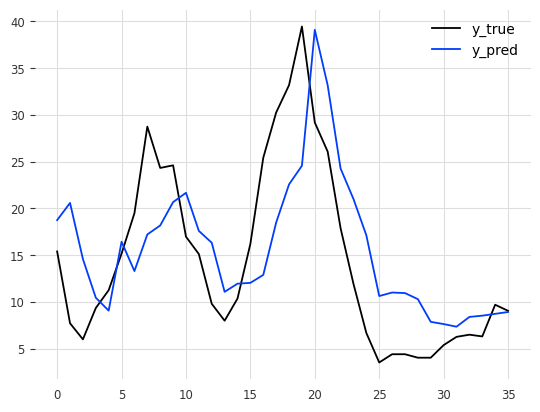

[I 2023-11-08 02:25:58,822] Trial 0 finished with value: 5.871332198113312 and parameters: {'random_state': 2, 'n_estimators': 61, 'max_depth': 4}. Best is trial 0 with value: 5.871332198113312.
[I 2023-11-08 02:25:58,902] A new study created in memory with name: RandomForest


mean_squared_error: 50.0172
rmse: 7.072286229855765
mape: 0.5681734660421706
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


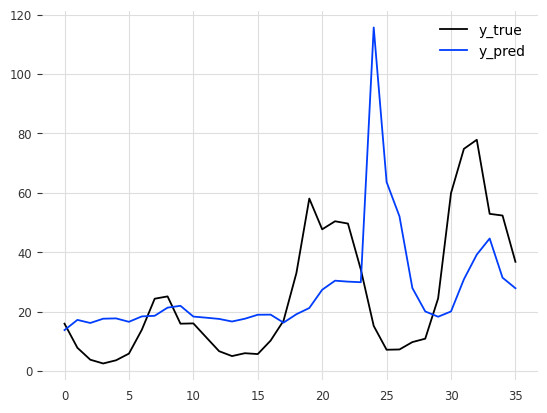

[I 2023-11-08 02:25:59,218] Trial 0 finished with value: 18.345887325766164 and parameters: {'random_state': 24, 'n_estimators': 198, 'max_depth': 4}. Best is trial 0 with value: 18.345887325766164.
[I 2023-11-08 02:25:59,226] A new study created in memory with name: RandomForest


mean_squared_error: 713.9987
rmse: 26.7207545191844
mape: 1.5474704137233517
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


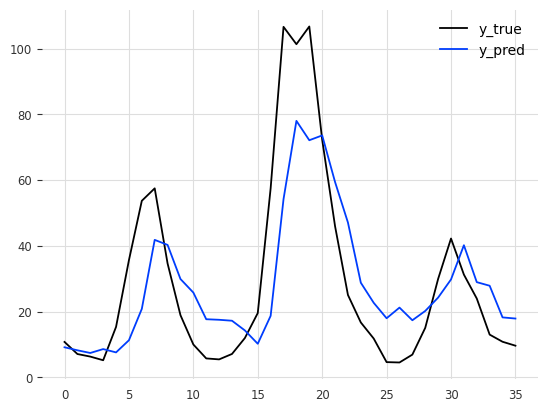

[I 2023-11-08 02:25:59,454] Trial 0 finished with value: 13.41549088874378 and parameters: {'random_state': 22, 'n_estimators': 103, 'max_depth': 3}. Best is trial 0 with value: 13.41549088874378.
[I 2023-11-08 02:25:59,469] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 306.2219
rmse: 17.49919741295012
mape: 0.7889797777471537
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LinearRegressionModel
⭐️⭐️ City:  An Giang


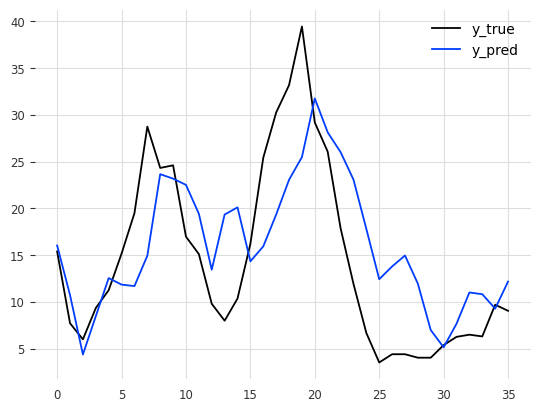

[I 2023-11-08 02:25:59,636] Trial 0 finished with value: 5.678637170031234 and parameters: {'random_state': 32}. Best is trial 0 with value: 5.678637170031234.
[I 2023-11-08 02:25:59,644] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 50.1325
rmse: 7.080428156995197
mape: 0.6101592707978178
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


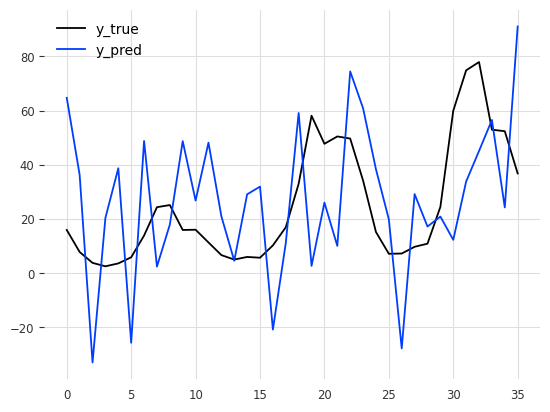

[I 2023-11-08 02:25:59,750] Trial 0 finished with value: 26.278083048312954 and parameters: {'random_state': 29}. Best is trial 0 with value: 26.278083048312954.
[I 2023-11-08 02:25:59,757] A new study created in memory with name: LinearRegressionModel
[W 2023-11-08 02:25:59,771] Trial 0 failed with parameters: {'random_state': 4} because of the following error: ValueError("Input X contains infinity or a value too large for dtype('float64').").
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_80136/897638902.py", line 39, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_80136/85958389.py", line 232, in objective
    mae_error = output_prediction_for_location(df

mean_squared_error: 891.0387
rmse: 29.85027104150089
mape: 2.252269662227497
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


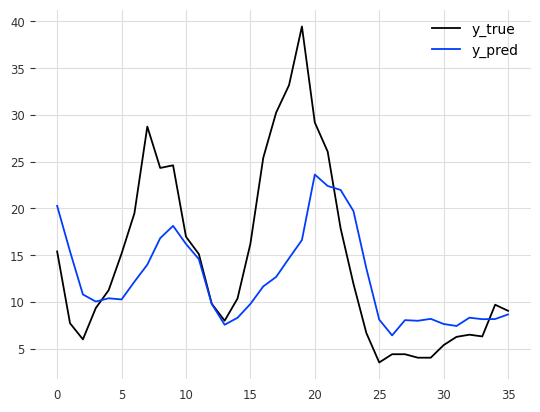

[I 2023-11-08 02:26:00,942] Trial 0 finished with value: 5.50635245261667 and parameters: {'learning_rate': 0.03450084099719202, 'n_estimators': 155, 'max_depth': 9, 'random_state': 524, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 80.15230545191302, 'border_count': 156, 'l2_leaf_reg': 5.37030872401937, 'random_strength': 7.011619986423607}. Best is trial 0 with value: 5.50635245261667.
[I 2023-11-08 02:26:00,949] A new study created in memory with name: CatBoostModel


mean_squared_error: 60.2050
rmse: 7.759189032792965
mape: 0.42353829608663834
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


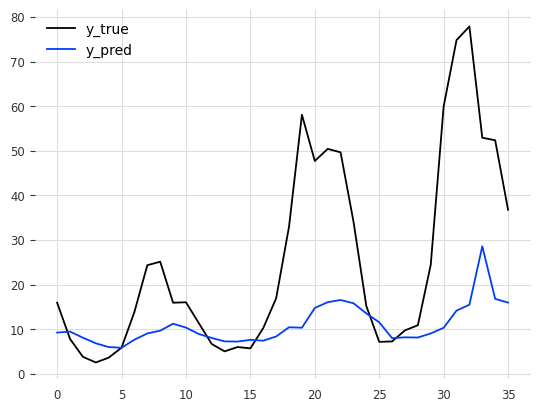

[I 2023-11-08 02:26:01,439] Trial 0 finished with value: 15.450029132799179 and parameters: {'learning_rate': 0.00798725612725535, 'n_estimators': 79, 'max_depth': 6, 'random_state': 902, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 68.54047479081412, 'border_count': 225, 'l2_leaf_reg': 2.414609648183061, 'random_strength': 3.3271527292935588}. Best is trial 0 with value: 15.450029132799179.
[I 2023-11-08 02:26:01,447] A new study created in memory with name: CatBoostModel


mean_squared_error: 550.9622
rmse: 23.472584456180606
mape: 0.5199667829046617
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


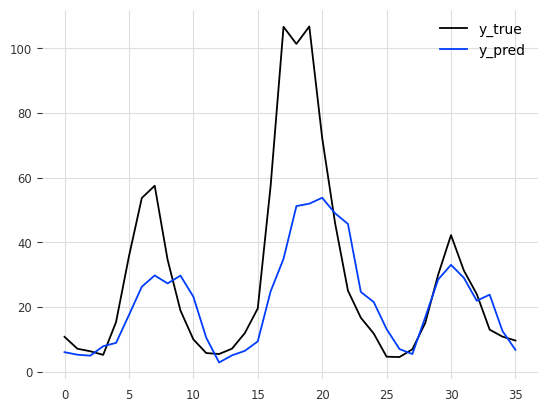

[I 2023-11-08 02:26:01,627] Trial 0 finished with value: 12.787576048523723 and parameters: {'learning_rate': 0.07489764472537772, 'n_estimators': 170, 'max_depth': 2, 'random_state': 850, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 74.51799594889005, 'border_count': 109, 'l2_leaf_reg': 3.0691558783449677, 'random_strength': 7.678193829229972}. Best is trial 0 with value: 12.787576048523723.
[I 2023-11-08 02:26:01,635] A new study created in memory with name: XGBModel


mean_squared_error: 427.6557
rmse: 20.679837303449474
mape: 0.4747810046132979
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  XGBModel
⭐️⭐️ City:  An Giang


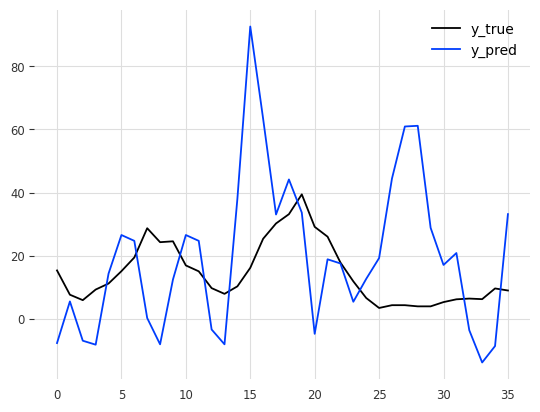

[I 2023-11-08 02:26:02,336] Trial 0 finished with value: 19.57437578054728 and parameters: {'random_state': 33, 'likelihood': 'quantile'}. Best is trial 0 with value: 19.57437578054728.
[I 2023-11-08 02:26:02,342] A new study created in memory with name: XGBModel


mean_squared_error: 664.9788
rmse: 25.787182463427193
mape: 2.420928534362696
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


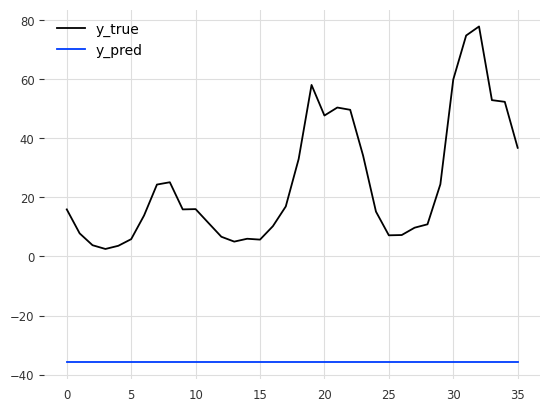

[I 2023-11-08 02:26:02,961] Trial 0 finished with value: 60.876472844258245 and parameters: {'random_state': 20, 'likelihood': 'quantile'}. Best is trial 0 with value: 60.876472844258245.
[I 2023-11-08 02:26:02,968] A new study created in memory with name: XGBModel


mean_squared_error: 4170.2893
rmse: 64.57777749596181
mape: 4.319437195993739
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


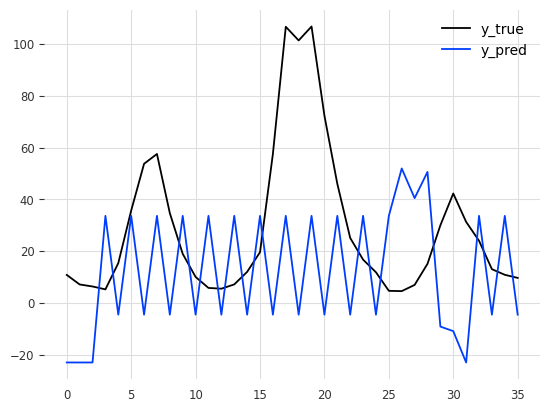

[I 2023-11-08 02:26:03,829] Trial 0 finished with value: 33.63977679074599 and parameters: {'random_state': 35, 'likelihood': 'quantile'}. Best is trial 0 with value: 33.63977679074599.
[I 2023-11-08 02:26:03,836] A new study created in memory with name: SVMRBF


mean_squared_error: 1643.9295
rmse: 40.54539996550475
mape: 2.1603025881252114
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  SVMRBF
⭐️⭐️ City:  An Giang


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
164           0.405172        0.578474            0.671603        0.560976   
165           0.452299        0.338692            0.096690        0.439024   
166           0.562644        0.429837            0.636760        0.292683   
167           0.560345        0.363215            0.074913        0.390244   
168           0.258621        0.464578            0.423345        0.560976   
169           0.672414        0.482970            0.445122        0.560976   
170           0.402299        0.501362            0.675958        0.560976   
171           0.287356        0.557221            0.392857        0.560976   
172           0.419540        0.424387            0.371080        0.560976   
173           0.465517        0.451635            0.384146        0.560976   
174           0.362069        0.497956            0.462544        0.560976   
175           0.482759        0.423706            0.358014        0.560976   
176           0.379310        0.455041            0.384146        0.560976   
177           0.494253        0.515668            0.680314        0.560976   
178           0.597701        0.357629            0.140244        0.560976   
179           0.339081        0.447548            0.379791        0.560976   
180           1.000000        0.465259            0.436411        0.560976   
181           0.000000        0.480245            0.440767        0.560976   
182           0.436782        0.549046            0.593206        0.560976   
183           0.275862        0.487738            0.362369        0.560976   
184           0.660919        0.391689            0.349303        0.560976   
185           0.396552        0.551771            0.501742        0.560976   
186           0.614942        0.380109            0.375435        0.560976   
187           0.149425        0.509537            0.449477        0.560976   
188           0.454023        0.478202            0.471254        0.560976   
189           0.442529        0.447548            0.601916        0.560976   
190           0.563218        0.365123            0.061847        0.560976   
191           0.396552        0.465940            0.427700        0.560976   
192           0.465517        0.463215            0.418990        0.560976   
193           0.551724        0.463896            0.418990        0.560976   
194           0.431034        0.490463            0.479965        0.560976   
195           0.229885        0.535422            0.580139        0.560976   
196           0.511494        0.435286            0.344948        0.560976   
197           0.511494        0.465940            0.414634        0.560976   
198           0.494253        1.000000            0.401568        0.560976   
199           0.275862        0.000000            0.493031        0.560976   
200           0.465517        0.474796            0.475610        0.560976   
201           0.500000        0.354905            0.244774        0.560976   
202           0.574713        0.453678            0.523519        0.560976   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
164             0.451613                 0.149254                 0.438356   
165             0.516129                 0.373134                 0.465753   
166             0.516129                 0.343284                 0.410959   
167             0.483871                 0.313433                 0.506849   
168             0.629032                 0.537313                 0.452055   
169             0.806452                 0.552239                 0.739726   
170             0.709677                 0.492537                 0.616438   
171             0.661290                 0.373134                 0.684932   
172             0.419355                 0.223881                 0.438356   
173             0.564516                 0.373134                 0.493151   
174             0.612903  

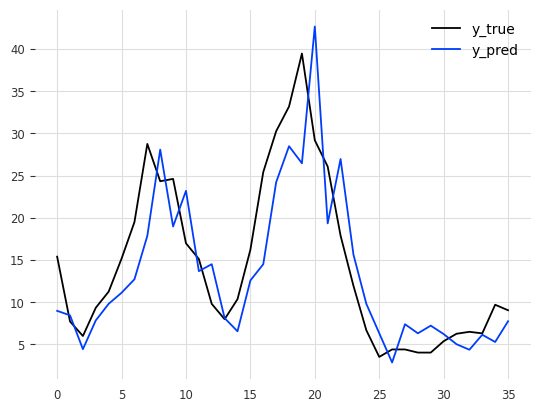

[I 2023-11-08 02:26:03,944] Trial 0 finished with value: 4.342820084142427 and parameters: {'max_iter': 137, 'epsilon': 7.991380355170899e-07}. Best is trial 0 with value: 4.342820084142427.
[I 2023-11-08 02:26:03,949] A new study created in memory with name: SVMRBF


mean_squared_error: 30.7731
rmse: 5.547352873009843
mape: 0.32139141729893833
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
164           0.509960        0.847562            0.615578        0.657895   
165           0.722444        0.000000            0.255444        0.000000   
166           0.775564        0.401406            0.410385        0.263158   
167           0.709827        0.463564            0.494137        0.315790   
168           0.739044        0.462895            0.489950        0.394737   
169           0.785525        0.466243            0.502513        0.394737   
170           0.526560        0.551055            0.820770        0.394737   
171           0.440239        0.590113            0.381072        0.394737   
172           0.553121        0.525388            0.448074        0.394737   
173           0.825365        0.476286            0.464824        0.394737   
174           0.685923        0.335677            0.481575        0.394737   
175           0.646082        0.567794            0.582077        0.394737   
176           0.626162        0.359112            0.393635        0.394737   
177           0.725764        0.496373            0.628141        0.394737   
178           0.606242        0.311126            0.305695        0.394737   
179           0.812085        0.424953            0.427136        0.394737   
180           0.599602        0.504185            0.640703        0.394737   
181           0.792165        0.458431            0.452261        0.394737   
182           0.480080        0.721794            0.477387        0.394737   
183           0.413679        0.250865            0.485762        0.394737   
184           0.938247        0.542127            0.540201        0.394737   
185           0.559761        0.524272            0.519263        0.394737   
186           0.792165        0.427185            0.485762        0.394737   
187           0.400398        0.498605            0.598827        0.394737   
188           0.838645        0.357996            0.427136        0.394737   
189           0.725764        0.366923            0.335008        0.394737   
190           0.758964        0.475170            0.561139        0.394737   
191           0.626162        0.448387            0.422948        0.394737   
192           0.785525        0.457315            0.481575        0.394737   
193           0.592962        0.462895            0.489950        0.394737   
194           0.612882        0.580069            0.690955        0.394737   
195           0.294157        0.458431            0.414573        0.394737   
196           0.832005        0.567794            0.502513        0.394737   
197           0.705843        0.506417            0.531826        0.394737   
198           0.699203        0.508649            0.519263        0.394737   
199           0.526560        0.409329            0.510888        0.394737   
200           0.739044        0.344604            0.414573        0.394737   
201           0.652722        0.459547            0.728643        0.394737   
202           0.832005        0.362459            0.201005        0.394737   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
164                0.125                 0.238095                 0.250000   
165                0.450                 0.619048                 0.409091   
166                0.300                 0.476191                 0.318182   
167                0.225                 0.404762                 0.204545   
168                0.500                 0.547619                 0.636364   
169                0.775                 0.857143                 0.750000   
170                0.550                 0.595238                 0.590909   
171                0.775                 0.952381                 0.636364   
172                0.100                 0.476191                 0.068182   
173                0.500                 0.428571                 0.545454   
174                0.550  

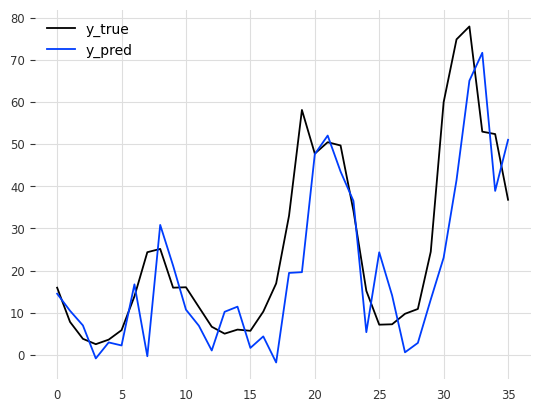

[I 2023-11-08 02:26:04,051] Trial 0 finished with value: 10.05654163141789 and parameters: {'max_iter': 147, 'epsilon': 4.716074436168076e-05}. Best is trial 0 with value: 10.05654163141789.
[I 2023-11-08 02:26:04,059] A new study created in memory with name: SVMRBF


mean_squared_error: 195.9270
rmse: 13.99739237565443
mape: 0.5748363060307897
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
164           0.515151        0.447169            0.441135        0.583333   
165           0.690318        0.337437            0.407418        0.305556   
166           0.822616        0.380671            0.393369        0.166667   
167           0.861050        0.493796            0.480472        0.333333   
168           0.556541        0.523265            0.550717        0.500000   
169           0.571323        0.616324            0.525428        0.500000   
170           0.504804        0.541683            0.522619        0.500000   
171           0.246120        0.536836            0.472043        0.500000   
172           0.586105        0.639589            0.511380        0.500000   
173           0.541759        0.686119            0.570385        0.500000   
174           0.652624        0.282862            0.384940        0.500000   
175           0.497413        0.500969            0.500140        0.500000   
176           0.623060        0.448624            0.429896        0.500000   
177           0.770880        0.424389            0.553526        0.500000   
178           0.830007        0.365258            0.460804        0.500000   
179           0.586105        0.453470            0.345603        0.500000   
180           0.593496        0.500969            0.477662        0.500000   
181           0.889135        0.516479            0.533858        0.500000   
182           0.172210        0.804381            0.958134        0.500000   
183           0.305248        0.315820            0.016859        0.500000   
184           0.696970        0.642497            0.581624        0.500000   
185           0.571323        0.838309            0.671537        0.500000   
186           0.674797        0.110314            0.278168        0.500000   
187           0.179601        0.763668            0.581624        0.500000   
188           0.756098        0.204343            0.337173        0.500000   
189           0.800443        0.474796            0.466423        0.500000   
190           1.000000        0.327452            0.438325        0.500000   
191           0.807834        0.482551            0.432706        0.500000   
192           0.778270        0.501939            0.488901        0.500000   
193           0.689579        0.523265            0.514189        0.500000   
194           0.157428        0.624079            0.545097        0.500000   
195           0.002217        0.646375            0.553526        0.500000   
196           0.719143        0.475766            0.491711        0.500000   
197           0.630451        0.661884            0.508570        0.500000   
198           0.549150        0.465103            0.553526        0.500000   
199           0.475240        0.380768            0.331554        0.500000   
200           0.778270        0.670609            0.764260        0.500000   
201           0.652624        0.138426            0.140489        0.500000   
202           0.793053        0.501939            0.438325        0.500000   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
164             0.397436                 0.245902                 0.364865   
165             0.500000                 0.639344                 0.283784   
166             0.461539                 0.590164                 0.256757   
167             0.500000                 0.639344                 0.364865   
168             0.641026                 0.852459                 0.459460   
169             0.538462                 0.540984                 0.581081   
170             0.641026                 0.508197                 0.608108   
171             0.512821                 0.442623                 0.432432   
172             0.423077                 0.327869                 0.324324   
173             0.448718                 0.491803                 0.432432   
174             0.551282  

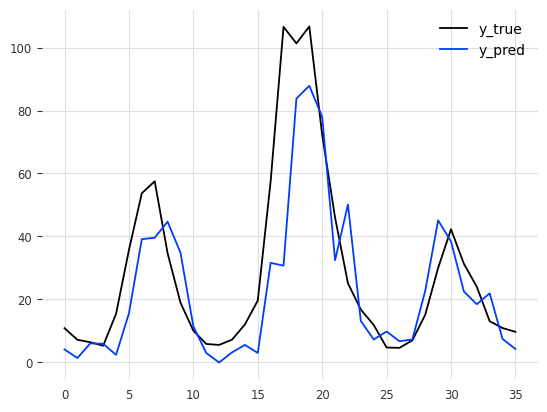

[I 2023-11-08 02:26:04,157] Trial 0 finished with value: 11.088066341268357 and parameters: {'max_iter': 196, 'epsilon': 2.0324846060215166e-06}. Best is trial 0 with value: 11.088066341268357.
[I 2023-11-08 02:26:04,163] A new study created in memory with name: PoissonRegressor


mean_squared_error: 290.4852
rmse: 17.04362541299397
mape: 0.4609668035618729
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  PoissonRegressor
⭐️⭐️ City:  An Giang


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
164           0.405172        0.578474            0.671603        0.560976   
165           0.452299        0.338692            0.096690        0.439024   
166           0.562644        0.429837            0.636760        0.292683   
167           0.560345        0.363215            0.074913        0.390244   
168           0.258621        0.464578            0.423345        0.560976   
169           0.672414        0.482970            0.445122        0.560976   
170           0.402299        0.501362            0.675958        0.560976   
171           0.287356        0.557221            0.392857        0.560976   
172           0.419540        0.424387            0.371080        0.560976   
173           0.465517        0.451635            0.384146        0.560976   
174           0.362069        0.497956            0.462544        0.560976   
175           0.482759        0.423706            0.358014        0.560976   
176           0.379310        0.455041            0.384146        0.560976   
177           0.494253        0.515668            0.680314        0.560976   
178           0.597701        0.357629            0.140244        0.560976   
179           0.339081        0.447548            0.379791        0.560976   
180           1.000000        0.465259            0.436411        0.560976   
181           0.000000        0.480245            0.440767        0.560976   
182           0.436782        0.549046            0.593206        0.560976   
183           0.275862        0.487738            0.362369        0.560976   
184           0.660919        0.391689            0.349303        0.560976   
185           0.396552        0.551771            0.501742        0.560976   
186           0.614942        0.380109            0.375435        0.560976   
187           0.149425        0.509537            0.449477        0.560976   
188           0.454023        0.478202            0.471254        0.560976   
189           0.442529        0.447548            0.601916        0.560976   
190           0.563218        0.365123            0.061847        0.560976   
191           0.396552        0.465940            0.427700        0.560976   
192           0.465517        0.463215            0.418990        0.560976   
193           0.551724        0.463896            0.418990        0.560976   
194           0.431034        0.490463            0.479965        0.560976   
195           0.229885        0.535422            0.580139        0.560976   
196           0.511494        0.435286            0.344948        0.560976   
197           0.511494        0.465940            0.414634        0.560976   
198           0.494253        1.000000            0.401568        0.560976   
199           0.275862        0.000000            0.493031        0.560976   
200           0.465517        0.474796            0.475610        0.560976   
201           0.500000        0.354905            0.244774        0.560976   
202           0.574713        0.453678            0.523519        0.560976   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
164             0.451613                 0.149254                 0.438356   
165             0.516129                 0.373134                 0.465753   
166             0.516129                 0.343284                 0.410959   
167             0.483871                 0.313433                 0.506849   
168             0.629032                 0.537313                 0.452055   
169             0.806452                 0.552239                 0.739726   
170             0.709677                 0.492537                 0.616438   
171             0.661290                 0.373134                 0.684932   
172             0.419355                 0.223881                 0.438356   
173             0.564516                 0.373134                 0.493151   
174             0.612903  

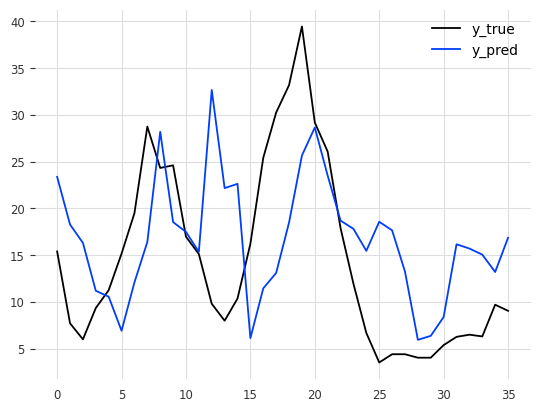

[I 2023-11-08 02:26:04,317] Trial 0 finished with value: 8.089563759093874 and parameters: {'max_iter': 158, 'alpha': 8.515305187577409e-08}. Best is trial 0 with value: 8.089563759093874.
[I 2023-11-08 02:26:04,329] A new study created in memory with name: PoissonRegressor


mean_squared_error: 95.4242
rmse: 9.768532501590833
mape: 0.8871490578245811
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
🐰Bụt Đây!!
PARAMS:  {'max_iter': 158, 'alpha': 8.515305187577409e-08}
⭐️⭐️ City:  BR Vũng Tàu


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
164           0.509960        0.847562            0.615578        0.657895   
165           0.722444        0.000000            0.255444        0.000000   
166           0.775564        0.401406            0.410385        0.263158   
167           0.709827        0.463564            0.494137        0.315790   
168           0.739044        0.462895            0.489950        0.394737   
169           0.785525        0.466243            0.502513        0.394737   
170           0.526560        0.551055            0.820770        0.394737   
171           0.440239        0.590113            0.381072        0.394737   
172           0.553121        0.525388            0.448074        0.394737   
173           0.825365        0.476286            0.464824        0.394737   
174           0.685923        0.335677            0.481575        0.394737   
175           0.646082        0.567794            0.582077        0.394737   
176           0.626162        0.359112            0.393635        0.394737   
177           0.725764        0.496373            0.628141        0.394737   
178           0.606242        0.311126            0.305695        0.394737   
179           0.812085        0.424953            0.427136        0.394737   
180           0.599602        0.504185            0.640703        0.394737   
181           0.792165        0.458431            0.452261        0.394737   
182           0.480080        0.721794            0.477387        0.394737   
183           0.413679        0.250865            0.485762        0.394737   
184           0.938247        0.542127            0.540201        0.394737   
185           0.559761        0.524272            0.519263        0.394737   
186           0.792165        0.427185            0.485762        0.394737   
187           0.400398        0.498605            0.598827        0.394737   
188           0.838645        0.357996            0.427136        0.394737   
189           0.725764        0.366923            0.335008        0.394737   
190           0.758964        0.475170            0.561139        0.394737   
191           0.626162        0.448387            0.422948        0.394737   
192           0.785525        0.457315            0.481575        0.394737   
193           0.592962        0.462895            0.489950        0.394737   
194           0.612882        0.580069            0.690955        0.394737   
195           0.294157        0.458431            0.414573        0.394737   
196           0.832005        0.567794            0.502513        0.394737   
197           0.705843        0.506417            0.531826        0.394737   
198           0.699203        0.508649            0.519263        0.394737   
199           0.526560        0.409329            0.510888        0.394737   
200           0.739044        0.344604            0.414573        0.394737   
201           0.652722        0.459547            0.728643        0.394737   
202           0.832005        0.362459            0.201005        0.394737   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
164                0.125                 0.238095                 0.250000   
165                0.450                 0.619048                 0.409091   
166                0.300                 0.476191                 0.318182   
167                0.225                 0.404762                 0.204545   
168                0.500                 0.547619                 0.636364   
169                0.775                 0.857143                 0.750000   
170                0.550                 0.595238                 0.590909   
171                0.775                 0.952381                 0.636364   
172                0.100                 0.476191                 0.068182   
173                0.500                 0.428571                 0.545454   
174                0.550  

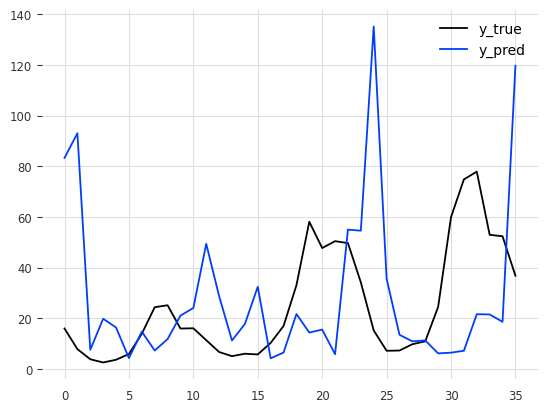

[I 2023-11-08 02:26:04,541] Trial 0 finished with value: 28.090534299421115 and parameters: {'max_iter': 185, 'alpha': 1.522684372610609e-06}. Best is trial 0 with value: 28.090534299421115.
[I 2023-11-08 02:26:04,548] A new study created in memory with name: PoissonRegressor


mean_squared_error: 1569.5747
rmse: 39.61785876493051
mape: 1.8754926543767116
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
🐰Bụt Đây!!
PARAMS:  {'max_iter': 185, 'alpha': 1.522684372610609e-06}
⭐️⭐️ City:  Bình Phước


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
164           0.515151        0.447169            0.441135        0.583333   
165           0.690318        0.337437            0.407418        0.305556   
166           0.822616        0.380671            0.393369        0.166667   
167           0.861050        0.493796            0.480472        0.333333   
168           0.556541        0.523265            0.550717        0.500000   
169           0.571323        0.616324            0.525428        0.500000   
170           0.504804        0.541683            0.522619        0.500000   
171           0.246120        0.536836            0.472043        0.500000   
172           0.586105        0.639589            0.511380        0.500000   
173           0.541759        0.686119            0.570385        0.500000   
174           0.652624        0.282862            0.384940        0.500000   
175           0.497413        0.500969            0.500140        0.500000   
176           0.623060        0.448624            0.429896        0.500000   
177           0.770880        0.424389            0.553526        0.500000   
178           0.830007        0.365258            0.460804        0.500000   
179           0.586105        0.453470            0.345603        0.500000   
180           0.593496        0.500969            0.477662        0.500000   
181           0.889135        0.516479            0.533858        0.500000   
182           0.172210        0.804381            0.958134        0.500000   
183           0.305248        0.315820            0.016859        0.500000   
184           0.696970        0.642497            0.581624        0.500000   
185           0.571323        0.838309            0.671537        0.500000   
186           0.674797        0.110314            0.278168        0.500000   
187           0.179601        0.763668            0.581624        0.500000   
188           0.756098        0.204343            0.337173        0.500000   
189           0.800443        0.474796            0.466423        0.500000   
190           1.000000        0.327452            0.438325        0.500000   
191           0.807834        0.482551            0.432706        0.500000   
192           0.778270        0.501939            0.488901        0.500000   
193           0.689579        0.523265            0.514189        0.500000   
194           0.157428        0.624079            0.545097        0.500000   
195           0.002217        0.646375            0.553526        0.500000   
196           0.719143        0.475766            0.491711        0.500000   
197           0.630451        0.661884            0.508570        0.500000   
198           0.549150        0.465103            0.553526        0.500000   
199           0.475240        0.380768            0.331554        0.500000   
200           0.778270        0.670609            0.764260        0.500000   
201           0.652624        0.138426            0.140489        0.500000   
202           0.793053        0.501939            0.438325        0.500000   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
164             0.397436                 0.245902                 0.364865   
165             0.500000                 0.639344                 0.283784   
166             0.461539                 0.590164                 0.256757   
167             0.500000                 0.639344                 0.364865   
168             0.641026                 0.852459                 0.459460   
169             0.538462                 0.540984                 0.581081   
170             0.641026                 0.508197                 0.608108   
171             0.512821                 0.442623                 0.432432   
172             0.423077                 0.327869                 0.324324   
173             0.448718                 0.491803                 0.432432   
174             0.551282  

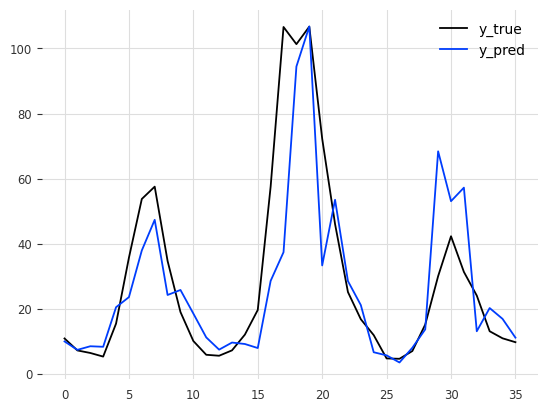

[I 2023-11-08 02:26:04,652] Trial 0 finished with value: 10.253454279464822 and parameters: {'max_iter': 112, 'alpha': 1.479179773183557e-08}. Best is trial 0 with value: 10.253454279464822.
[I 2023-11-08 02:26:04,660] A new study created in memory with name: RandomForest


mean_squared_error: 298.6394
rmse: 17.28118722880488
mape: 0.37813248355708046
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
🐰Bụt Đây!!
PARAMS:  {'max_iter': 112, 'alpha': 1.479179773183557e-08}
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  2
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  RandomForest
⭐️⭐️ City:  An Giang


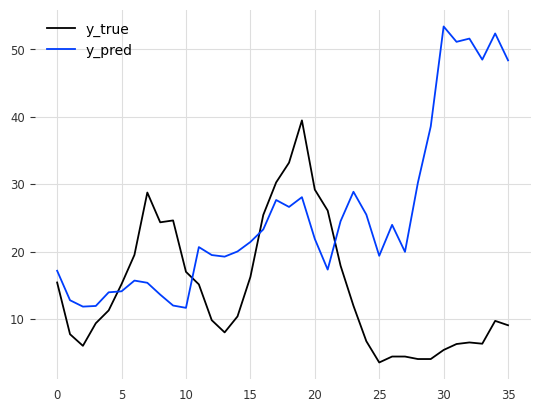

[I 2023-11-08 02:26:05,011] Trial 0 finished with value: 15.584682799694138 and parameters: {'random_state': 40, 'n_estimators': 186, 'max_depth': 6}. Best is trial 0 with value: 15.584682799694138.
[I 2023-11-08 02:26:05,018] A new study created in memory with name: RandomForest


mean_squared_error: 449.8248
rmse: 21.209073344796405
mape: 2.2218120638083647
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


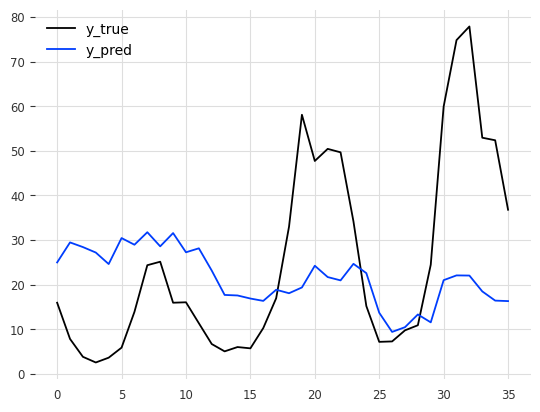

[I 2023-11-08 02:26:05,421] Trial 0 finished with value: 18.596871002573675 and parameters: {'random_state': 13, 'n_estimators': 198, 'max_depth': 11}. Best is trial 0 with value: 18.596871002573675.
[I 2023-11-08 02:26:05,428] A new study created in memory with name: RandomForest


mean_squared_error: 530.2428
rmse: 23.027002477853156
mape: 1.4787546848867157
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


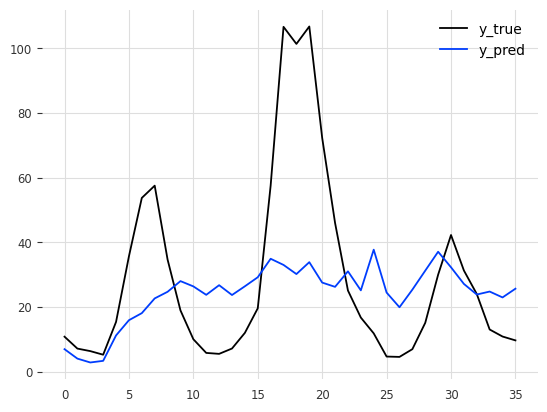

[I 2023-11-08 02:26:05,673] Trial 0 finished with value: 19.38138633350218 and parameters: {'random_state': 24, 'n_estimators': 97, 'max_depth': 9}. Best is trial 0 with value: 19.38138633350218.
[I 2023-11-08 02:26:05,682] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 725.8926
rmse: 26.942394849824517
mape: 1.0887852850533806
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LinearRegressionModel
⭐️⭐️ City:  An Giang


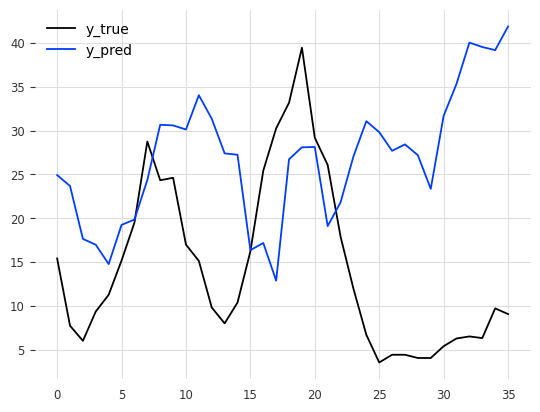

[I 2023-11-08 02:26:05,787] Trial 0 finished with value: 15.414471560911453 and parameters: {'random_state': 12}. Best is trial 0 with value: 15.414471560911453.
[I 2023-11-08 02:26:05,792] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 338.4951
rmse: 18.39823622505288
mape: 2.1413366459916676
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


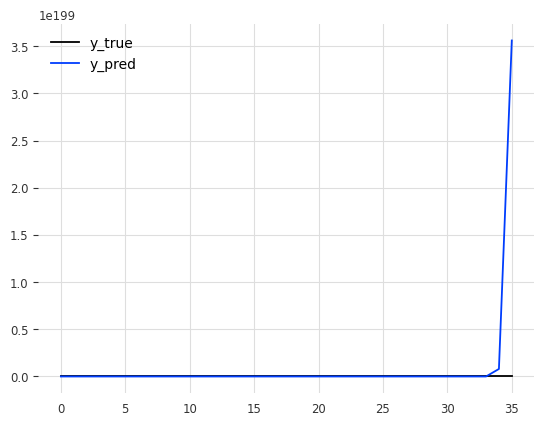

[I 2023-11-08 02:26:05,891] Trial 0 finished with value: 1.0115474707772945e+198 and parameters: {'random_state': 5}. Best is trial 0 with value: 1.0115474707772945e+198.
[I 2023-11-08 02:26:05,898] A new study created in memory with name: LinearRegressionModel


mean_squared_error: inf
rmse: inf
mape: 2.7316509433032117e+196
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


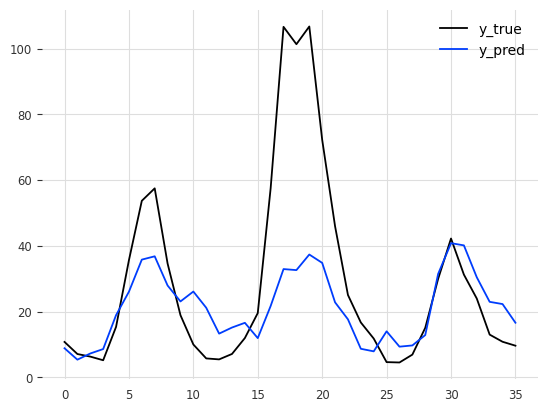

[I 2023-11-08 02:26:05,998] Trial 0 finished with value: 14.53768557082366 and parameters: {'random_state': 36}. Best is trial 0 with value: 14.53768557082366.
[I 2023-11-08 02:26:06,008] A new study created in memory with name: CatBoostModel


mean_squared_error: 568.4959
rmse: 23.84315257341491
mape: 0.6099532274769751
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


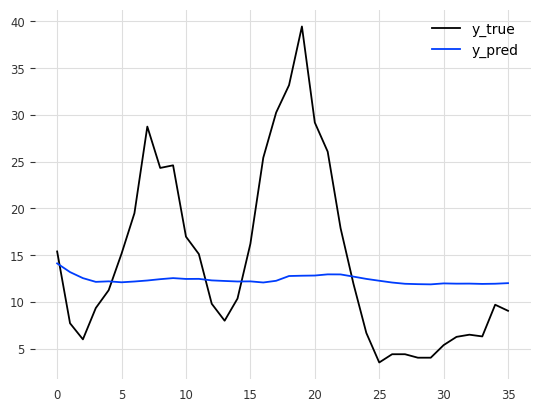

[I 2023-11-08 02:26:06,460] Trial 0 finished with value: 7.645220032061762 and parameters: {'learning_rate': 0.0011007461573633796, 'n_estimators': 165, 'max_depth': 3, 'random_state': 878, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 16.12411223529885, 'border_count': 172, 'l2_leaf_reg': 5.859783420041278, 'random_strength': 7.294307775905229}. Best is trial 0 with value: 7.645220032061762.
[I 2023-11-08 02:26:06,466] A new study created in memory with name: CatBoostModel


mean_squared_error: 93.5992
rmse: 9.674665599773148
mape: 0.6932226819453455
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


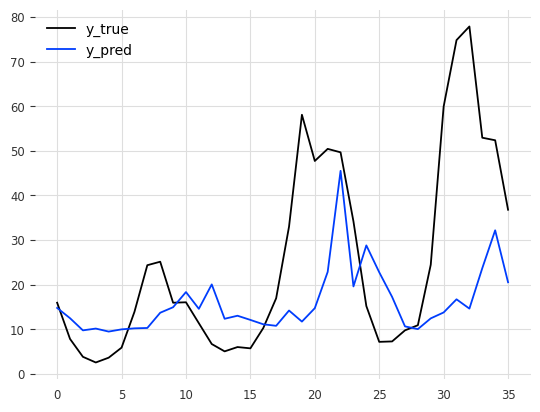

[I 2023-11-08 02:26:10,486] Trial 0 finished with value: 14.911914401917967 and parameters: {'learning_rate': 0.007045471990095351, 'n_estimators': 196, 'max_depth': 9, 'random_state': 426, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 21.81228038729378, 'border_count': 185, 'l2_leaf_reg': 2.494259712002702, 'random_strength': 8.384561175164531}. Best is trial 0 with value: 14.911914401917967.
[I 2023-11-08 02:26:10,494] A new study created in memory with name: CatBoostModel


mean_squared_error: 477.3115
rmse: 21.84745898338169
mape: 0.7630480955625263
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


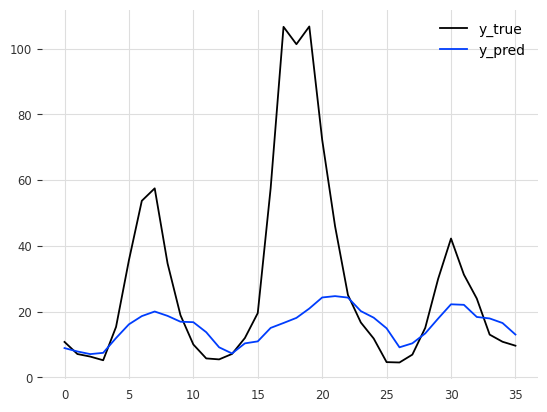

[I 2023-11-08 02:26:11,264] Trial 0 finished with value: 16.94316640511453 and parameters: {'learning_rate': 0.015476739795099202, 'n_estimators': 94, 'max_depth': 7, 'random_state': 914, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 28.40222487113977, 'border_count': 250, 'l2_leaf_reg': 5.479065136933081, 'random_strength': 3.72814342410583}. Best is trial 0 with value: 16.94316640511453.
[I 2023-11-08 02:26:11,272] A new study created in memory with name: XGBModel


mean_squared_error: 871.0014
rmse: 29.51273224538695
mape: 0.5101299327485943
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  XGBModel
⭐️⭐️ City:  An Giang


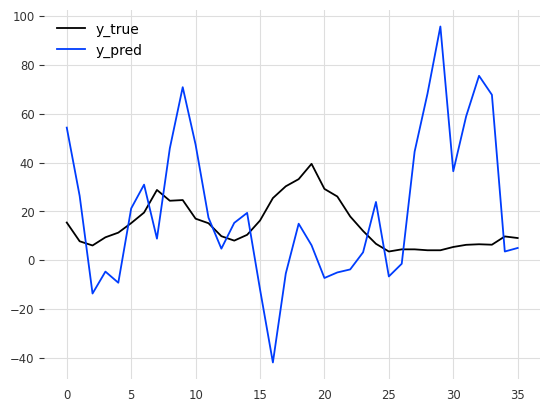

[I 2023-11-08 02:26:12,015] Trial 0 finished with value: 27.93765476968374 and parameters: {'random_state': 23, 'likelihood': 'quantile'}. Best is trial 0 with value: 27.93765476968374.
[I 2023-11-08 02:26:12,020] A new study created in memory with name: XGBModel


mean_squared_error: 1248.3635
rmse: 35.33218840663734
mape: 3.3788330925882137
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


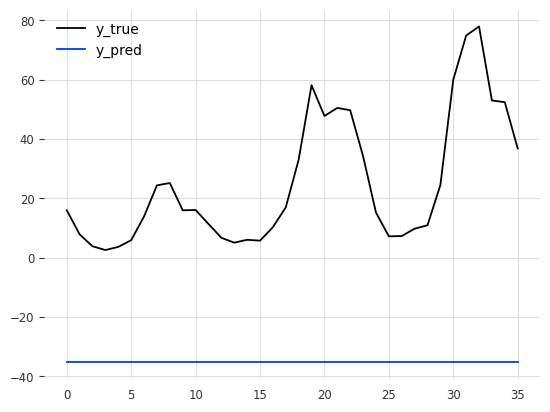

[I 2023-11-08 02:26:12,730] Trial 0 finished with value: 60.323970887566965 and parameters: {'random_state': 5, 'likelihood': 'quantile'}. Best is trial 0 with value: 60.323970887566965.
[I 2023-11-08 02:26:12,737] A new study created in memory with name: XGBModel


mean_squared_error: 4103.3259
rmse: 64.05720774436135
mape: 4.268338956185487
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


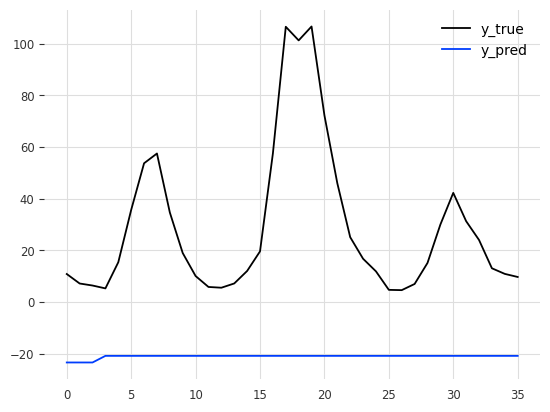

[I 2023-11-08 02:26:13,615] Trial 0 finished with value: 50.05837542272887 and parameters: {'random_state': 43, 'likelihood': 'quantile'}. Best is trial 0 with value: 50.05837542272887.
[I 2023-11-08 02:26:13,622] A new study created in memory with name: SVMRBF


mean_squared_error: 3323.7012
rmse: 57.6515498959938
mape: 2.6721209953696183
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  SVMRBF
⭐️⭐️ City:  An Giang


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
163           0.381609        0.445504            0.405923        0.585366   
164           0.405172        0.578474            0.671603        0.560976   
165           0.452299        0.338692            0.096690        0.439024   
166           0.562644        0.429837            0.636760        0.292683   
167           0.560345        0.363215            0.074913        0.390244   
168           0.258621        0.464578            0.423345        0.560976   
169           0.672414        0.482970            0.445122        0.560976   
170           0.402299        0.501362            0.675958        0.560976   
171           0.287356        0.557221            0.392857        0.560976   
172           0.419540        0.424387            0.371080        0.560976   
173           0.465517        0.451635            0.384146        0.560976   
174           0.362069        0.497956            0.462544        0.560976   
175           0.482759        0.423706            0.358014        0.560976   
176           0.379310        0.455041            0.384146        0.560976   
177           0.494253        0.515668            0.680314        0.560976   
178           0.597701        0.357629            0.140244        0.560976   
179           0.339081        0.447548            0.379791        0.560976   
180           1.000000        0.465259            0.436411        0.560976   
181           0.000000        0.480245            0.440767        0.560976   
182           0.436782        0.549046            0.593206        0.560976   
183           0.275862        0.487738            0.362369        0.560976   
184           0.660919        0.391689            0.349303        0.560976   
185           0.396552        0.551771            0.501742        0.560976   
186           0.614942        0.380109            0.375435        0.560976   
187           0.149425        0.509537            0.449477        0.560976   
188           0.454023        0.478202            0.471254        0.560976   
189           0.442529        0.447548            0.601916        0.560976   
190           0.563218        0.365123            0.061847        0.560976   
191           0.396552        0.465940            0.427700        0.560976   
192           0.465517        0.463215            0.418990        0.560976   
193           0.551724        0.463896            0.418990        0.560976   
194           0.431034        0.490463            0.479965        0.560976   
195           0.229885        0.535422            0.580139        0.560976   
196           0.511494        0.435286            0.344948        0.560976   
197           0.511494        0.465940            0.414634        0.560976   
198           0.494253        1.000000            0.401568        0.560976   
199           0.275862        0.000000            0.493031        0.560976   
200           0.465517        0.474796            0.475610        0.560976   
201           0.500000        0.354905            0.244774        0.560976   
202           0.574713        0.453678            0.523519        0.560976   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
163             0.596774                 0.358209                 0.589041   
164             0.451613                 0.149254                 0.438356   
165             0.516129                 0.373134                 0.465753   
166             0.516129                 0.343284                 0.410959   
167             0.483871                 0.313433                 0.506849   
168             0.629032                 0.537313                 0.452055   
169             0.806452                 0.552239                 0.739726   
170             0.709677                 0.492537                 0.616438   
171             0.661290                 0.373134                 0.684932   
172             0.419355  

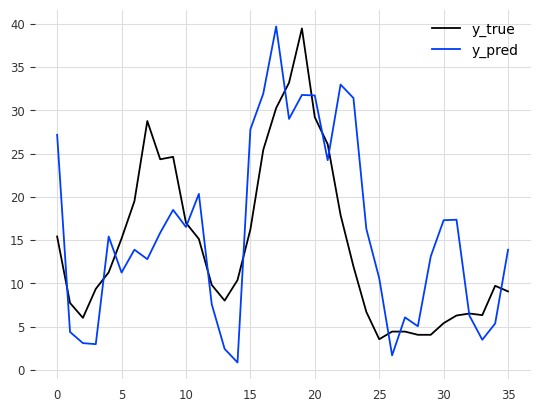

[I 2023-11-08 02:26:13,785] Trial 0 finished with value: 6.566736688776512 and parameters: {'max_iter': 66, 'epsilon': 0.003636054013826379}. Best is trial 0 with value: 6.566736688776512.
[I 2023-11-08 02:26:13,791] A new study created in memory with name: SVMRBF


mean_squared_error: 63.6234
rmse: 7.976425935572327
mape: 0.6458167643333682
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
163           0.687915        0.319830            0.485762        0.157895   
164           0.509960        0.847562            0.615578        0.657895   
165           0.722444        0.000000            0.255444        0.000000   
166           0.775564        0.401406            0.410385        0.263158   
167           0.709827        0.463564            0.494137        0.315790   
168           0.739044        0.462895            0.489950        0.394737   
169           0.785525        0.466243            0.502513        0.394737   
170           0.526560        0.551055            0.820770        0.394737   
171           0.440239        0.590113            0.381072        0.394737   
172           0.553121        0.525388            0.448074        0.394737   
173           0.825365        0.476286            0.464824        0.394737   
174           0.685923        0.335677            0.481575        0.394737   
175           0.646082        0.567794            0.582077        0.394737   
176           0.626162        0.359112            0.393635        0.394737   
177           0.725764        0.496373            0.628141        0.394737   
178           0.606242        0.311126            0.305695        0.394737   
179           0.812085        0.424953            0.427136        0.394737   
180           0.599602        0.504185            0.640703        0.394737   
181           0.792165        0.458431            0.452261        0.394737   
182           0.480080        0.721794            0.477387        0.394737   
183           0.413679        0.250865            0.485762        0.394737   
184           0.938247        0.542127            0.540201        0.394737   
185           0.559761        0.524272            0.519263        0.394737   
186           0.792165        0.427185            0.485762        0.394737   
187           0.400398        0.498605            0.598827        0.394737   
188           0.838645        0.357996            0.427136        0.394737   
189           0.725764        0.366923            0.335008        0.394737   
190           0.758964        0.475170            0.561139        0.394737   
191           0.626162        0.448387            0.422948        0.394737   
192           0.785525        0.457315            0.481575        0.394737   
193           0.592962        0.462895            0.489950        0.394737   
194           0.612882        0.580069            0.690955        0.394737   
195           0.294157        0.458431            0.414573        0.394737   
196           0.832005        0.567794            0.502513        0.394737   
197           0.705843        0.506417            0.531826        0.394737   
198           0.699203        0.508649            0.519263        0.394737   
199           0.526560        0.409329            0.510888        0.394737   
200           0.739044        0.344604            0.414573        0.394737   
201           0.652722        0.459547            0.728643        0.394737   
202           0.832005        0.362459            0.201005        0.394737   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
163                0.625                 0.666667                 0.590909   
164                0.125                 0.238095                 0.250000   
165                0.450                 0.619048                 0.409091   
166                0.300                 0.476191                 0.318182   
167                0.225                 0.404762                 0.204545   
168                0.500                 0.547619                 0.636364   
169                0.775                 0.857143                 0.750000   
170                0.550                 0.595238                 0.590909   
171                0.775                 0.952381                 0.636364   
172                0.100  

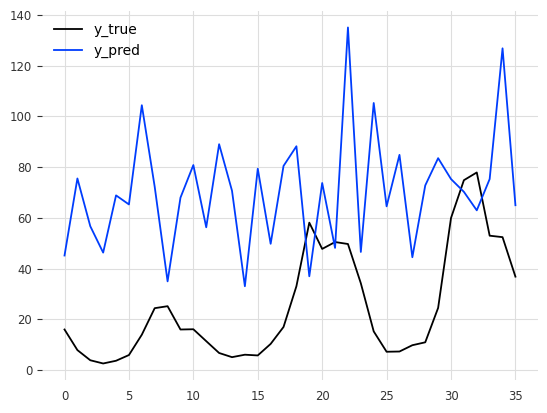

[I 2023-11-08 02:26:13,950] Trial 0 finished with value: 47.84520376267545 and parameters: {'max_iter': 66, 'epsilon': 0.08806279064603495}. Best is trial 0 with value: 47.84520376267545.
[I 2023-11-08 02:26:13,965] A new study created in memory with name: SVMRBF


mean_squared_error: 2920.1803
rmse: 54.03869237458609
mape: 5.118304210896186
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
163           0.633407        0.556999            0.522619        0.472222   
164           0.515151        0.447169            0.441135        0.583333   
165           0.690318        0.337437            0.407418        0.305556   
166           0.822616        0.380671            0.393369        0.166667   
167           0.861050        0.493796            0.480472        0.333333   
168           0.556541        0.523265            0.550717        0.500000   
169           0.571323        0.616324            0.525428        0.500000   
170           0.504804        0.541683            0.522619        0.500000   
171           0.246120        0.536836            0.472043        0.500000   
172           0.586105        0.639589            0.511380        0.500000   
173           0.541759        0.686119            0.570385        0.500000   
174           0.652624        0.282862            0.384940        0.500000   
175           0.497413        0.500969            0.500140        0.500000   
176           0.623060        0.448624            0.429896        0.500000   
177           0.770880        0.424389            0.553526        0.500000   
178           0.830007        0.365258            0.460804        0.500000   
179           0.586105        0.453470            0.345603        0.500000   
180           0.593496        0.500969            0.477662        0.500000   
181           0.889135        0.516479            0.533858        0.500000   
182           0.172210        0.804381            0.958134        0.500000   
183           0.305248        0.315820            0.016859        0.500000   
184           0.696970        0.642497            0.581624        0.500000   
185           0.571323        0.838309            0.671537        0.500000   
186           0.674797        0.110314            0.278168        0.500000   
187           0.179601        0.763668            0.581624        0.500000   
188           0.756098        0.204343            0.337173        0.500000   
189           0.800443        0.474796            0.466423        0.500000   
190           1.000000        0.327452            0.438325        0.500000   
191           0.807834        0.482551            0.432706        0.500000   
192           0.778270        0.501939            0.488901        0.500000   
193           0.689579        0.523265            0.514189        0.500000   
194           0.157428        0.624079            0.545097        0.500000   
195           0.002217        0.646375            0.553526        0.500000   
196           0.719143        0.475766            0.491711        0.500000   
197           0.630451        0.661884            0.508570        0.500000   
198           0.549150        0.465103            0.553526        0.500000   
199           0.475240        0.380768            0.331554        0.500000   
200           0.778270        0.670609            0.764260        0.500000   
201           0.652624        0.138426            0.140489        0.500000   
202           0.793053        0.501939            0.438325        0.500000   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
163             0.564103                 0.704918                 0.418919   
164             0.397436                 0.245902                 0.364865   
165             0.500000                 0.639344                 0.283784   
166             0.461539                 0.590164                 0.256757   
167             0.500000                 0.639344                 0.364865   
168             0.641026                 0.852459                 0.459460   
169             0.538462                 0.540984                 0.581081   
170             0.641026                 0.508197                 0.608108   
171             0.512821                 0.442623                 0.432432   
172             0.423077  

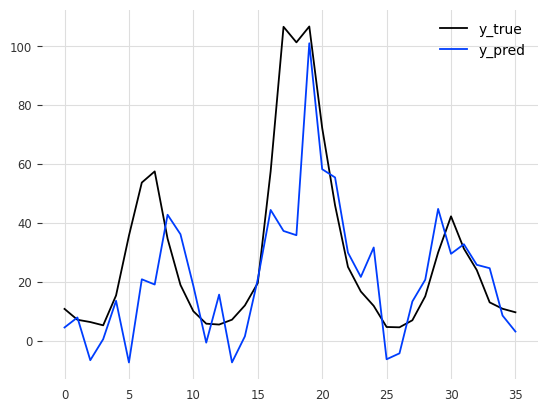

[I 2023-11-08 02:26:14,176] Trial 0 finished with value: 14.098254961938716 and parameters: {'max_iter': 57, 'epsilon': 0.000984711307041379}. Best is trial 0 with value: 14.098254961938716.
[I 2023-11-08 02:26:14,189] A new study created in memory with name: PoissonRegressor


mean_squared_error: 455.9026
rmse: 21.351876510624425
mape: 0.7383303251844988
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  PoissonRegressor
⭐️⭐️ City:  An Giang


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
163           0.381609        0.445504            0.405923        0.585366   
164           0.405172        0.578474            0.671603        0.560976   
165           0.452299        0.338692            0.096690        0.439024   
166           0.562644        0.429837            0.636760        0.292683   
167           0.560345        0.363215            0.074913        0.390244   
168           0.258621        0.464578            0.423345        0.560976   
169           0.672414        0.482970            0.445122        0.560976   
170           0.402299        0.501362            0.675958        0.560976   
171           0.287356        0.557221            0.392857        0.560976   
172           0.419540        0.424387            0.371080        0.560976   
173           0.465517        0.451635            0.384146        0.560976   
174           0.362069        0.497956            0.462544        0.560976   
175           0.482759        0.423706            0.358014        0.560976   
176           0.379310        0.455041            0.384146        0.560976   
177           0.494253        0.515668            0.680314        0.560976   
178           0.597701        0.357629            0.140244        0.560976   
179           0.339081        0.447548            0.379791        0.560976   
180           1.000000        0.465259            0.436411        0.560976   
181           0.000000        0.480245            0.440767        0.560976   
182           0.436782        0.549046            0.593206        0.560976   
183           0.275862        0.487738            0.362369        0.560976   
184           0.660919        0.391689            0.349303        0.560976   
185           0.396552        0.551771            0.501742        0.560976   
186           0.614942        0.380109            0.375435        0.560976   
187           0.149425        0.509537            0.449477        0.560976   
188           0.454023        0.478202            0.471254        0.560976   
189           0.442529        0.447548            0.601916        0.560976   
190           0.563218        0.365123            0.061847        0.560976   
191           0.396552        0.465940            0.427700        0.560976   
192           0.465517        0.463215            0.418990        0.560976   
193           0.551724        0.463896            0.418990        0.560976   
194           0.431034        0.490463            0.479965        0.560976   
195           0.229885        0.535422            0.580139        0.560976   
196           0.511494        0.435286            0.344948        0.560976   
197           0.511494        0.465940            0.414634        0.560976   
198           0.494253        1.000000            0.401568        0.560976   
199           0.275862        0.000000            0.493031        0.560976   
200           0.465517        0.474796            0.475610        0.560976   
201           0.500000        0.354905            0.244774        0.560976   
202           0.574713        0.453678            0.523519        0.560976   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
163             0.596774                 0.358209                 0.589041   
164             0.451613                 0.149254                 0.438356   
165             0.516129                 0.373134                 0.465753   
166             0.516129                 0.343284                 0.410959   
167             0.483871                 0.313433                 0.506849   
168             0.629032                 0.537313                 0.452055   
169             0.806452                 0.552239                 0.739726   
170             0.709677                 0.492537                 0.616438   
171             0.661290                 0.373134                 0.684932   
172             0.419355  

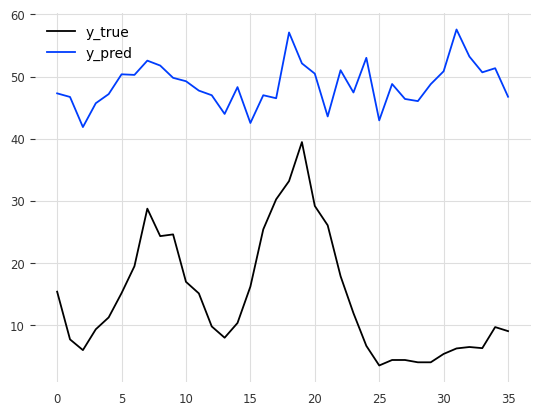

[I 2023-11-08 02:26:14,355] Trial 0 finished with value: 34.21709553612809 and parameters: {'max_iter': 113, 'alpha': 0.6204354526555754}. Best is trial 0 with value: 34.21709553612809.
[I 2023-11-08 02:26:14,364] A new study created in memory with name: PoissonRegressor


mean_squared_error: 1258.0334
rmse: 35.46876599212802
mape: 4.216282961498941
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
🐰Bụt Đây!!
PARAMS:  {'max_iter': 113, 'alpha': 0.6204354526555754}
⭐️⭐️ City:  BR Vũng Tàu


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
163           0.687915        0.319830            0.485762        0.157895   
164           0.509960        0.847562            0.615578        0.657895   
165           0.722444        0.000000            0.255444        0.000000   
166           0.775564        0.401406            0.410385        0.263158   
167           0.709827        0.463564            0.494137        0.315790   
168           0.739044        0.462895            0.489950        0.394737   
169           0.785525        0.466243            0.502513        0.394737   
170           0.526560        0.551055            0.820770        0.394737   
171           0.440239        0.590113            0.381072        0.394737   
172           0.553121        0.525388            0.448074        0.394737   
173           0.825365        0.476286            0.464824        0.394737   
174           0.685923        0.335677            0.481575        0.394737   
175           0.646082        0.567794            0.582077        0.394737   
176           0.626162        0.359112            0.393635        0.394737   
177           0.725764        0.496373            0.628141        0.394737   
178           0.606242        0.311126            0.305695        0.394737   
179           0.812085        0.424953            0.427136        0.394737   
180           0.599602        0.504185            0.640703        0.394737   
181           0.792165        0.458431            0.452261        0.394737   
182           0.480080        0.721794            0.477387        0.394737   
183           0.413679        0.250865            0.485762        0.394737   
184           0.938247        0.542127            0.540201        0.394737   
185           0.559761        0.524272            0.519263        0.394737   
186           0.792165        0.427185            0.485762        0.394737   
187           0.400398        0.498605            0.598827        0.394737   
188           0.838645        0.357996            0.427136        0.394737   
189           0.725764        0.366923            0.335008        0.394737   
190           0.758964        0.475170            0.561139        0.394737   
191           0.626162        0.448387            0.422948        0.394737   
192           0.785525        0.457315            0.481575        0.394737   
193           0.592962        0.462895            0.489950        0.394737   
194           0.612882        0.580069            0.690955        0.394737   
195           0.294157        0.458431            0.414573        0.394737   
196           0.832005        0.567794            0.502513        0.394737   
197           0.705843        0.506417            0.531826        0.394737   
198           0.699203        0.508649            0.519263        0.394737   
199           0.526560        0.409329            0.510888        0.394737   
200           0.739044        0.344604            0.414573        0.394737   
201           0.652722        0.459547            0.728643        0.394737   
202           0.832005        0.362459            0.201005        0.394737   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
163                0.625                 0.666667                 0.590909   
164                0.125                 0.238095                 0.250000   
165                0.450                 0.619048                 0.409091   
166                0.300                 0.476191                 0.318182   
167                0.225                 0.404762                 0.204545   
168                0.500                 0.547619                 0.636364   
169                0.775                 0.857143                 0.750000   
170                0.550                 0.595238                 0.590909   
171                0.775                 0.952381                 0.636364   
172                0.100  

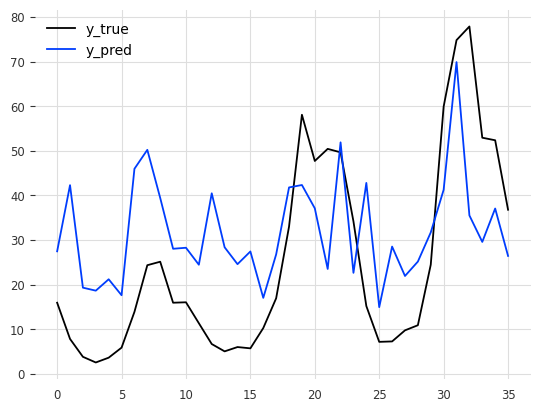

[I 2023-11-08 02:26:14,628] Trial 0 finished with value: 16.995505451286448 and parameters: {'max_iter': 132, 'alpha': 0.003044927445075758}. Best is trial 0 with value: 16.995505451286448.
[I 2023-11-08 02:26:14,638] A new study created in memory with name: PoissonRegressor


mean_squared_error: 370.0118
rmse: 19.23569204887748
mape: 1.6428156926181494
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
🐰Bụt Đây!!
PARAMS:  {'max_iter': 132, 'alpha': 0.003044927445075758}
⭐️⭐️ City:  Bình Phước


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
163           0.633407        0.556999            0.522619        0.472222   
164           0.515151        0.447169            0.441135        0.583333   
165           0.690318        0.337437            0.407418        0.305556   
166           0.822616        0.380671            0.393369        0.166667   
167           0.861050        0.493796            0.480472        0.333333   
168           0.556541        0.523265            0.550717        0.500000   
169           0.571323        0.616324            0.525428        0.500000   
170           0.504804        0.541683            0.522619        0.500000   
171           0.246120        0.536836            0.472043        0.500000   
172           0.586105        0.639589            0.511380        0.500000   
173           0.541759        0.686119            0.570385        0.500000   
174           0.652624        0.282862            0.384940        0.500000   
175           0.497413        0.500969            0.500140        0.500000   
176           0.623060        0.448624            0.429896        0.500000   
177           0.770880        0.424389            0.553526        0.500000   
178           0.830007        0.365258            0.460804        0.500000   
179           0.586105        0.453470            0.345603        0.500000   
180           0.593496        0.500969            0.477662        0.500000   
181           0.889135        0.516479            0.533858        0.500000   
182           0.172210        0.804381            0.958134        0.500000   
183           0.305248        0.315820            0.016859        0.500000   
184           0.696970        0.642497            0.581624        0.500000   
185           0.571323        0.838309            0.671537        0.500000   
186           0.674797        0.110314            0.278168        0.500000   
187           0.179601        0.763668            0.581624        0.500000   
188           0.756098        0.204343            0.337173        0.500000   
189           0.800443        0.474796            0.466423        0.500000   
190           1.000000        0.327452            0.438325        0.500000   
191           0.807834        0.482551            0.432706        0.500000   
192           0.778270        0.501939            0.488901        0.500000   
193           0.689579        0.523265            0.514189        0.500000   
194           0.157428        0.624079            0.545097        0.500000   
195           0.002217        0.646375            0.553526        0.500000   
196           0.719143        0.475766            0.491711        0.500000   
197           0.630451        0.661884            0.508570        0.500000   
198           0.549150        0.465103            0.553526        0.500000   
199           0.475240        0.380768            0.331554        0.500000   
200           0.778270        0.670609            0.764260        0.500000   
201           0.652624        0.138426            0.140489        0.500000   
202           0.793053        0.501939            0.438325        0.500000   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
163             0.564103                 0.704918                 0.418919   
164             0.397436                 0.245902                 0.364865   
165             0.500000                 0.639344                 0.283784   
166             0.461539                 0.590164                 0.256757   
167             0.500000                 0.639344                 0.364865   
168             0.641026                 0.852459                 0.459460   
169             0.538462                 0.540984                 0.581081   
170             0.641026                 0.508197                 0.608108   
171             0.512821                 0.442623                 0.432432   
172             0.423077  

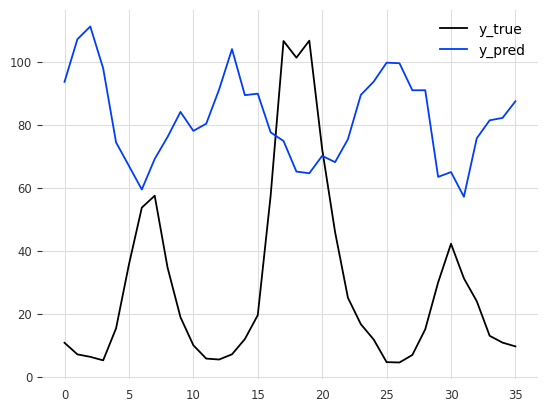

[I 2023-11-08 02:26:14,822] Trial 0 finished with value: 59.132309078084276 and parameters: {'max_iter': 91, 'alpha': 0.2514933821903409}. Best is trial 0 with value: 59.132309078084276.


mean_squared_error: 4337.8453
rmse: 65.86232069011034
mape: 6.177308836937964
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
🐰Bụt Đây!!
PARAMS:  {'max_iter': 91, 'alpha': 0.2514933821903409}


[I 2023-11-08 02:26:14,832] A new study created in memory with name: RandomForest


⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  3
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  RandomForest
⭐️⭐️ City:  An Giang


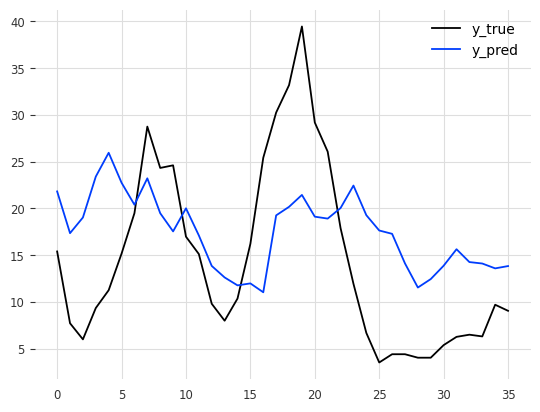

[I 2023-11-08 02:26:15,207] Trial 0 finished with value: 8.242812804926386 and parameters: {'random_state': 27, 'n_estimators': 164, 'max_depth': 15}. Best is trial 0 with value: 8.242812804926386.
[I 2023-11-08 02:26:15,213] A new study created in memory with name: RandomForest


mean_squared_error: 86.2384
rmse: 9.286463742138032
mape: 0.9537634847100571
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


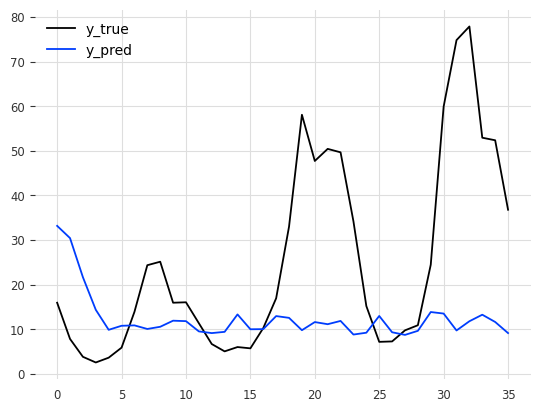

[I 2023-11-08 02:26:15,402] Trial 0 finished with value: 18.47416839460601 and parameters: {'random_state': 28, 'n_estimators': 62, 'max_depth': 7}. Best is trial 0 with value: 18.47416839460601.


mean_squared_error: 681.3340
rmse: 26.102375975302373
mape: 0.9107646277352958
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu


[I 2023-11-08 02:26:15,409] A new study created in memory with name: RandomForest


⭐️⭐️ City:  Bình Phước


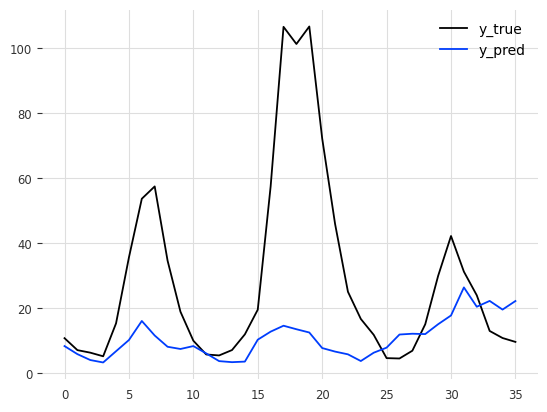

[I 2023-11-08 02:26:15,725] Trial 0 finished with value: 20.711246317343456 and parameters: {'random_state': 8, 'n_estimators': 137, 'max_depth': 10}. Best is trial 0 with value: 20.711246317343456.
[I 2023-11-08 02:26:15,733] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 1106.7860
rmse: 33.26839336298185
mape: 0.6133401963005127
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LinearRegressionModel
⭐️⭐️ City:  An Giang


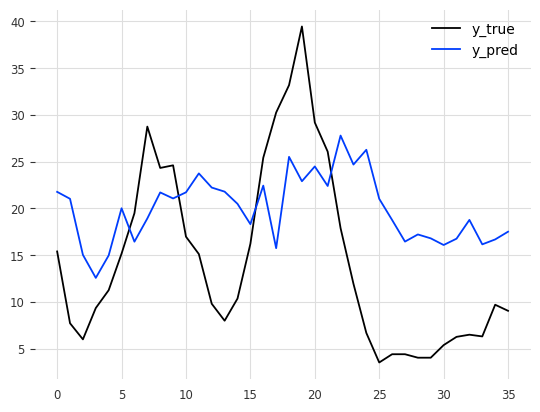

[I 2023-11-08 02:26:15,839] Trial 0 finished with value: 9.232161252575262 and parameters: {'random_state': 1}. Best is trial 0 with value: 9.232161252575262.
[I 2023-11-08 02:26:15,844] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 106.7023
rmse: 10.329679913246391
mape: 1.1824504881629494
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


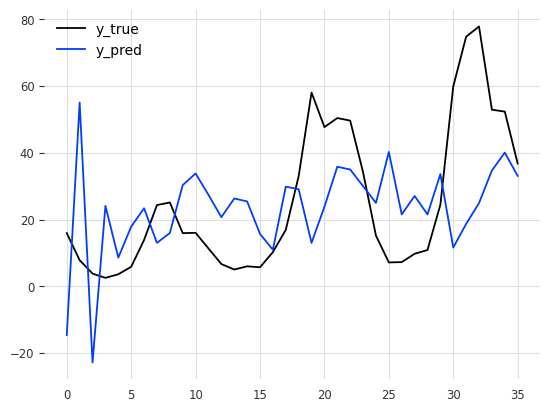

[I 2023-11-08 02:26:15,951] Trial 0 finished with value: 19.218896587064005 and parameters: {'random_state': 17}. Best is trial 0 with value: 19.218896587064005.
[I 2023-11-08 02:26:15,958] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 572.9516
rmse: 23.9364069563621
mape: 1.64830290387445
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


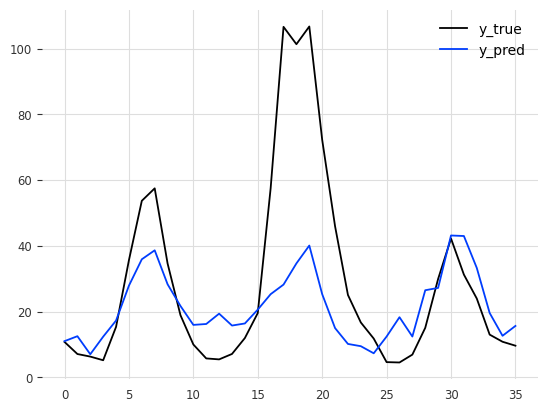

[I 2023-11-08 02:26:16,248] Trial 0 finished with value: 14.980029454555408 and parameters: {'random_state': 38}. Best is trial 0 with value: 14.980029454555408.
[I 2023-11-08 02:26:16,256] A new study created in memory with name: CatBoostModel


mean_squared_error: 598.2585
rmse: 24.459323545210413
mape: 0.6626050612215759
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


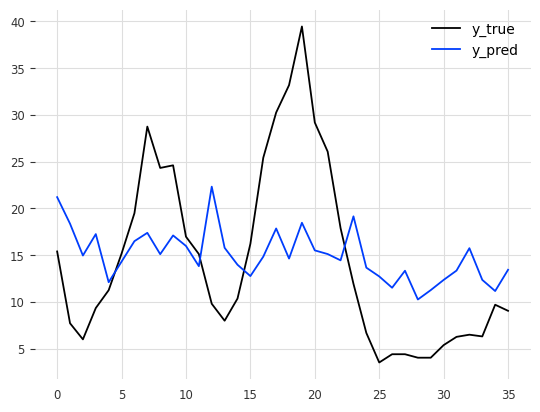

[I 2023-11-08 02:26:17,018] Trial 0 finished with value: 7.6250183165575045 and parameters: {'learning_rate': 0.04387386712665601, 'n_estimators': 100, 'max_depth': 11, 'random_state': 650, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 11.853907261719364, 'border_count': 39, 'l2_leaf_reg': 2.1173430648477636, 'random_strength': 7.756873886793942}. Best is trial 0 with value: 7.6250183165575045.
[I 2023-11-08 02:26:17,025] A new study created in memory with name: CatBoostModel


mean_squared_error: 78.7470
rmse: 8.873951650745358
mape: 0.7799363395029093
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


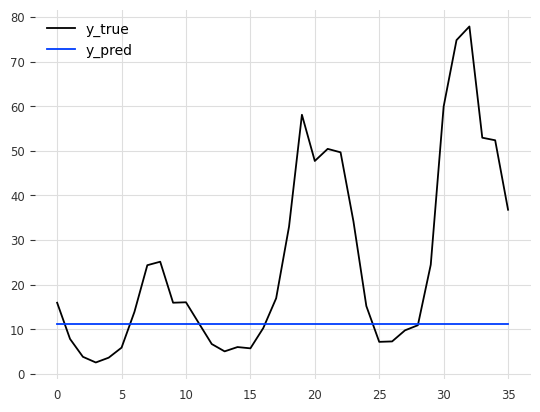

[I 2023-11-08 02:26:17,220] Trial 0 finished with value: 17.387469728141422 and parameters: {'learning_rate': 0.007500317603793485, 'n_estimators': 84, 'max_depth': 1, 'random_state': 444, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 63.213967656374756, 'border_count': 8, 'l2_leaf_reg': 3.680215796836895, 'random_strength': 0.20826946136985897}. Best is trial 0 with value: 17.387469728141422.
[I 2023-11-08 02:26:17,228] A new study created in memory with name: CatBoostModel


mean_squared_error: 657.6294
rmse: 25.644286311275668
mape: 0.7298126310114237
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


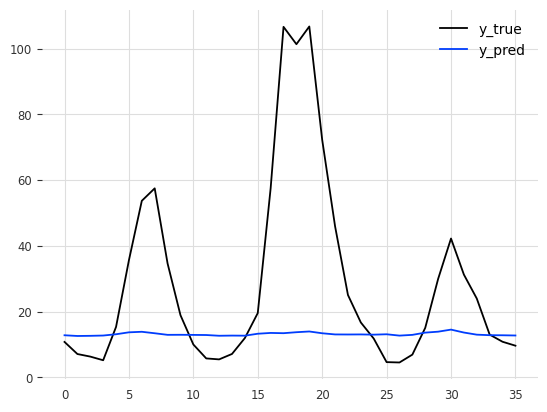

[I 2023-11-08 02:26:17,690] Trial 0 finished with value: 19.84900114247624 and parameters: {'learning_rate': 0.0037831571021903617, 'n_estimators': 62, 'max_depth': 6, 'random_state': 596, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 10.831590149737519, 'border_count': 216, 'l2_leaf_reg': 9.702616067972937, 'random_strength': 3.7324909370430714}. Best is trial 0 with value: 19.84900114247624.
[I 2023-11-08 02:26:17,699] A new study created in memory with name: XGBModel


mean_squared_error: 1057.2526
rmse: 32.51542103795305
mape: 0.6546969424059301
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  XGBModel
⭐️⭐️ City:  An Giang


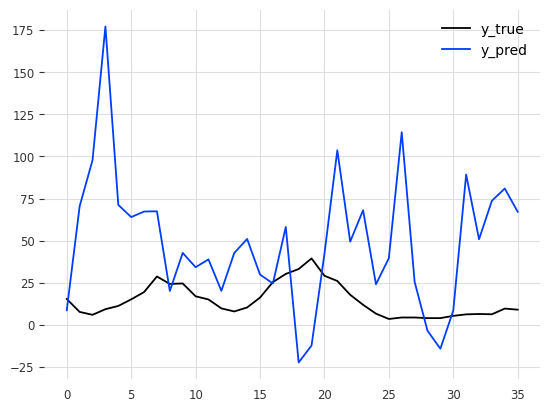

[I 2023-11-08 02:26:18,511] Trial 0 finished with value: 42.74376758267451 and parameters: {'random_state': 19, 'likelihood': 'quantile'}. Best is trial 0 with value: 42.74376758267451.
[I 2023-11-08 02:26:18,519] A new study created in memory with name: XGBModel


mean_squared_error: 2999.0385
rmse: 54.763477533623714
mape: 4.877704871324723
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


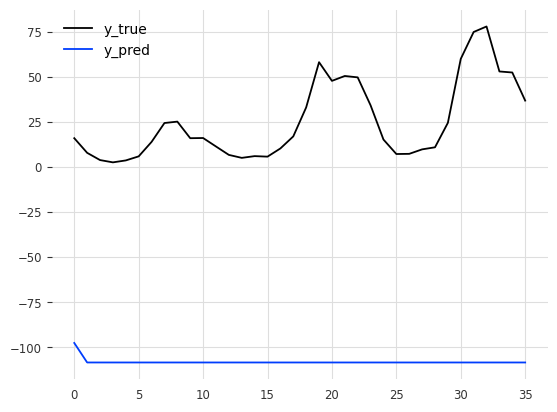

[I 2023-11-08 02:26:19,332] Trial 0 finished with value: 133.09040875101607 and parameters: {'random_state': 1, 'likelihood': 'quantile'}. Best is trial 0 with value: 133.09040875101607.
[I 2023-11-08 02:26:19,338] A new study created in memory with name: XGBModel


mean_squared_error: 18185.9956
rmse: 134.85546173695673
mape: 11.007095872756691
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


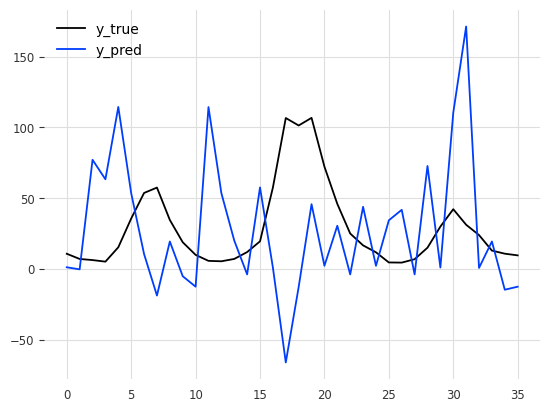

[I 2023-11-08 02:26:20,169] Trial 0 finished with value: 46.426887100807306 and parameters: {'random_state': 21, 'likelihood': 'quantile'}. Best is trial 0 with value: 46.426887100807306.
[I 2023-11-08 02:26:20,177] A new study created in memory with name: SVMRBF


mean_squared_error: 3681.1811
rmse: 60.67273732792278
mape: 3.108667533718123
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  SVMRBF
⭐️⭐️ City:  An Giang


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
162           0.535057        0.425817            0.462544        0.463415   
163           0.381609        0.445504            0.405923        0.585366   
164           0.405172        0.578474            0.671603        0.560976   
165           0.452299        0.338692            0.096690        0.439024   
166           0.562644        0.429837            0.636760        0.292683   
167           0.560345        0.363215            0.074913        0.390244   
168           0.258621        0.464578            0.423345        0.560976   
169           0.672414        0.482970            0.445122        0.560976   
170           0.402299        0.501362            0.675958        0.560976   
171           0.287356        0.557221            0.392857        0.560976   
172           0.419540        0.424387            0.371080        0.560976   
173           0.465517        0.451635            0.384146        0.560976   
174           0.362069        0.497956            0.462544        0.560976   
175           0.482759        0.423706            0.358014        0.560976   
176           0.379310        0.455041            0.384146        0.560976   
177           0.494253        0.515668            0.680314        0.560976   
178           0.597701        0.357629            0.140244        0.560976   
179           0.339081        0.447548            0.379791        0.560976   
180           1.000000        0.465259            0.436411        0.560976   
181           0.000000        0.480245            0.440767        0.560976   
182           0.436782        0.549046            0.593206        0.560976   
183           0.275862        0.487738            0.362369        0.560976   
184           0.660919        0.391689            0.349303        0.560976   
185           0.396552        0.551771            0.501742        0.560976   
186           0.614942        0.380109            0.375435        0.560976   
187           0.149425        0.509537            0.449477        0.560976   
188           0.454023        0.478202            0.471254        0.560976   
189           0.442529        0.447548            0.601916        0.560976   
190           0.563218        0.365123            0.061847        0.560976   
191           0.396552        0.465940            0.427700        0.560976   
192           0.465517        0.463215            0.418990        0.560976   
193           0.551724        0.463896            0.418990        0.560976   
194           0.431034        0.490463            0.479965        0.560976   
195           0.229885        0.535422            0.580139        0.560976   
196           0.511494        0.435286            0.344948        0.560976   
197           0.511494        0.465940            0.414634        0.560976   
198           0.494253        1.000000            0.401568        0.560976   
199           0.275862        0.000000            0.493031        0.560976   
200           0.465517        0.474796            0.475610        0.560976   
201           0.500000        0.354905            0.244774        0.560976   
202           0.574713        0.453678            0.523519        0.560976   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
162             0.629032                 0.358209                 0.561644   
163             0.596774                 0.358209                 0.589041   
164             0.451613                 0.149254                 0.438356   
165             0.516129                 0.373134                 0.465753   
166             0.516129                 0.343284                 0.410959   
167             0.483871                 0.313433                 0.506849   
168             0.629032                 0.537313                 0.452055   
169             0.806452                 0.552239                 0.739726   
170             0.709677  

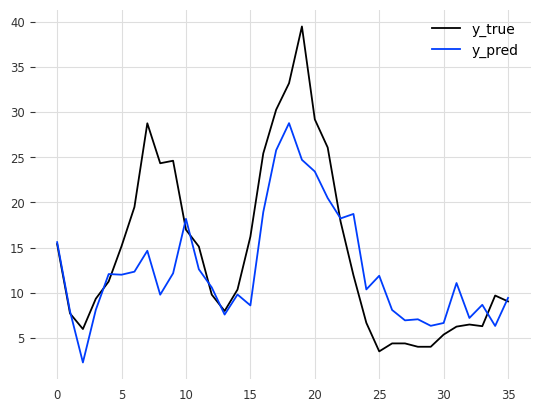

[I 2023-11-08 02:26:20,294] Trial 0 finished with value: 4.330079737454972 and parameters: {'max_iter': 159, 'epsilon': 2.6611296498299298e-05}. Best is trial 0 with value: 4.330079737454972.
[I 2023-11-08 02:26:20,299] A new study created in memory with name: SVMRBF


mean_squared_error: 35.5507
rmse: 5.962444874892571
mape: 0.37159576036040165
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
162           0.600266        0.578842            0.636516        0.500000   
163           0.687915        0.319830            0.485762        0.157895   
164           0.509960        0.847562            0.615578        0.657895   
165           0.722444        0.000000            0.255444        0.000000   
166           0.775564        0.401406            0.410385        0.263158   
167           0.709827        0.463564            0.494137        0.315790   
168           0.739044        0.462895            0.489950        0.394737   
169           0.785525        0.466243            0.502513        0.394737   
170           0.526560        0.551055            0.820770        0.394737   
171           0.440239        0.590113            0.381072        0.394737   
172           0.553121        0.525388            0.448074        0.394737   
173           0.825365        0.476286            0.464824        0.394737   
174           0.685923        0.335677            0.481575        0.394737   
175           0.646082        0.567794            0.582077        0.394737   
176           0.626162        0.359112            0.393635        0.394737   
177           0.725764        0.496373            0.628141        0.394737   
178           0.606242        0.311126            0.305695        0.394737   
179           0.812085        0.424953            0.427136        0.394737   
180           0.599602        0.504185            0.640703        0.394737   
181           0.792165        0.458431            0.452261        0.394737   
182           0.480080        0.721794            0.477387        0.394737   
183           0.413679        0.250865            0.485762        0.394737   
184           0.938247        0.542127            0.540201        0.394737   
185           0.559761        0.524272            0.519263        0.394737   
186           0.792165        0.427185            0.485762        0.394737   
187           0.400398        0.498605            0.598827        0.394737   
188           0.838645        0.357996            0.427136        0.394737   
189           0.725764        0.366923            0.335008        0.394737   
190           0.758964        0.475170            0.561139        0.394737   
191           0.626162        0.448387            0.422948        0.394737   
192           0.785525        0.457315            0.481575        0.394737   
193           0.592962        0.462895            0.489950        0.394737   
194           0.612882        0.580069            0.690955        0.394737   
195           0.294157        0.458431            0.414573        0.394737   
196           0.832005        0.567794            0.502513        0.394737   
197           0.705843        0.506417            0.531826        0.394737   
198           0.699203        0.508649            0.519263        0.394737   
199           0.526560        0.409329            0.510888        0.394737   
200           0.739044        0.344604            0.414573        0.394737   
201           0.652722        0.459547            0.728643        0.394737   
202           0.832005        0.362459            0.201005        0.394737   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
162                0.325                 0.523810                 0.363636   
163                0.625                 0.666667                 0.590909   
164                0.125                 0.238095                 0.250000   
165                0.450                 0.619048                 0.409091   
166                0.300                 0.476191                 0.318182   
167                0.225                 0.404762                 0.204545   
168                0.500                 0.547619                 0.636364   
169                0.775                 0.857143                 0.750000   
170                0.550  

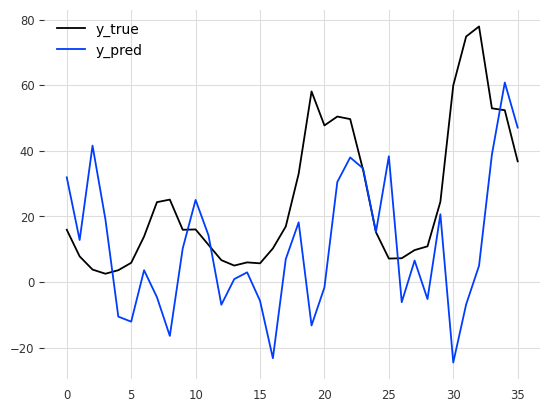

[I 2023-11-08 02:26:20,498] Trial 0 finished with value: 21.894415041909166 and parameters: {'max_iter': 156, 'epsilon': 1.674157639645476e-05}. Best is trial 0 with value: 21.894415041909166.
[I 2023-11-08 02:26:20,506] A new study created in memory with name: SVMRBF


mean_squared_error: 1000.9670
rmse: 31.638061865650265
mape: 1.5173338120872542
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
162           0.501848        0.540326            0.480472        0.500000   
163           0.633407        0.556999            0.522619        0.472222   
164           0.515151        0.447169            0.441135        0.583333   
165           0.690318        0.337437            0.407418        0.305556   
166           0.822616        0.380671            0.393369        0.166667   
167           0.861050        0.493796            0.480472        0.333333   
168           0.556541        0.523265            0.550717        0.500000   
169           0.571323        0.616324            0.525428        0.500000   
170           0.504804        0.541683            0.522619        0.500000   
171           0.246120        0.536836            0.472043        0.500000   
172           0.586105        0.639589            0.511380        0.500000   
173           0.541759        0.686119            0.570385        0.500000   
174           0.652624        0.282862            0.384940        0.500000   
175           0.497413        0.500969            0.500140        0.500000   
176           0.623060        0.448624            0.429896        0.500000   
177           0.770880        0.424389            0.553526        0.500000   
178           0.830007        0.365258            0.460804        0.500000   
179           0.586105        0.453470            0.345603        0.500000   
180           0.593496        0.500969            0.477662        0.500000   
181           0.889135        0.516479            0.533858        0.500000   
182           0.172210        0.804381            0.958134        0.500000   
183           0.305248        0.315820            0.016859        0.500000   
184           0.696970        0.642497            0.581624        0.500000   
185           0.571323        0.838309            0.671537        0.500000   
186           0.674797        0.110314            0.278168        0.500000   
187           0.179601        0.763668            0.581624        0.500000   
188           0.756098        0.204343            0.337173        0.500000   
189           0.800443        0.474796            0.466423        0.500000   
190           1.000000        0.327452            0.438325        0.500000   
191           0.807834        0.482551            0.432706        0.500000   
192           0.778270        0.501939            0.488901        0.500000   
193           0.689579        0.523265            0.514189        0.500000   
194           0.157428        0.624079            0.545097        0.500000   
195           0.002217        0.646375            0.553526        0.500000   
196           0.719143        0.475766            0.491711        0.500000   
197           0.630451        0.661884            0.508570        0.500000   
198           0.549150        0.465103            0.553526        0.500000   
199           0.475240        0.380768            0.331554        0.500000   
200           0.778270        0.670609            0.764260        0.500000   
201           0.652624        0.138426            0.140489        0.500000   
202           0.793053        0.501939            0.438325        0.500000   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
162             0.461539                 0.377049                 0.378378   
163             0.564103                 0.704918                 0.418919   
164             0.397436                 0.245902                 0.364865   
165             0.500000                 0.639344                 0.283784   
166             0.461539                 0.590164                 0.256757   
167             0.500000                 0.639344                 0.364865   
168             0.641026                 0.852459                 0.459460   
169             0.538462                 0.540984                 0.581081   
170             0.641026  

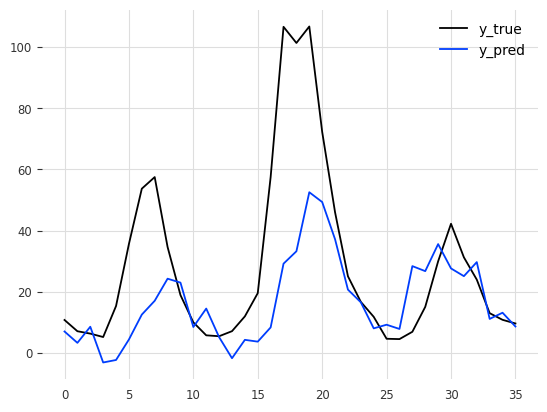

[I 2023-11-08 02:26:20,613] Trial 0 finished with value: 15.917504852870637 and parameters: {'max_iter': 103, 'epsilon': 0.0005492686317102861}. Best is trial 0 with value: 15.917504852870637.
[I 2023-11-08 02:26:20,620] A new study created in memory with name: PoissonRegressor


mean_squared_error: 635.3713
rmse: 25.206572426302042
mape: 0.6109037974242826
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  PoissonRegressor
⭐️⭐️ City:  An Giang


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
162           0.535057        0.425817            0.462544        0.463415   
163           0.381609        0.445504            0.405923        0.585366   
164           0.405172        0.578474            0.671603        0.560976   
165           0.452299        0.338692            0.096690        0.439024   
166           0.562644        0.429837            0.636760        0.292683   
167           0.560345        0.363215            0.074913        0.390244   
168           0.258621        0.464578            0.423345        0.560976   
169           0.672414        0.482970            0.445122        0.560976   
170           0.402299        0.501362            0.675958        0.560976   
171           0.287356        0.557221            0.392857        0.560976   
172           0.419540        0.424387            0.371080        0.560976   
173           0.465517        0.451635            0.384146        0.560976   
174           0.362069        0.497956            0.462544        0.560976   
175           0.482759        0.423706            0.358014        0.560976   
176           0.379310        0.455041            0.384146        0.560976   
177           0.494253        0.515668            0.680314        0.560976   
178           0.597701        0.357629            0.140244        0.560976   
179           0.339081        0.447548            0.379791        0.560976   
180           1.000000        0.465259            0.436411        0.560976   
181           0.000000        0.480245            0.440767        0.560976   
182           0.436782        0.549046            0.593206        0.560976   
183           0.275862        0.487738            0.362369        0.560976   
184           0.660919        0.391689            0.349303        0.560976   
185           0.396552        0.551771            0.501742        0.560976   
186           0.614942        0.380109            0.375435        0.560976   
187           0.149425        0.509537            0.449477        0.560976   
188           0.454023        0.478202            0.471254        0.560976   
189           0.442529        0.447548            0.601916        0.560976   
190           0.563218        0.365123            0.061847        0.560976   
191           0.396552        0.465940            0.427700        0.560976   
192           0.465517        0.463215            0.418990        0.560976   
193           0.551724        0.463896            0.418990        0.560976   
194           0.431034        0.490463            0.479965        0.560976   
195           0.229885        0.535422            0.580139        0.560976   
196           0.511494        0.435286            0.344948        0.560976   
197           0.511494        0.465940            0.414634        0.560976   
198           0.494253        1.000000            0.401568        0.560976   
199           0.275862        0.000000            0.493031        0.560976   
200           0.465517        0.474796            0.475610        0.560976   
201           0.500000        0.354905            0.244774        0.560976   
202           0.574713        0.453678            0.523519        0.560976   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
162             0.629032                 0.358209                 0.561644   
163             0.596774                 0.358209                 0.589041   
164             0.451613                 0.149254                 0.438356   
165             0.516129                 0.373134                 0.465753   
166             0.516129                 0.343284                 0.410959   
167             0.483871                 0.313433                 0.506849   
168             0.629032                 0.537313                 0.452055   
169             0.806452                 0.552239                 0.739726   
170             0.709677  

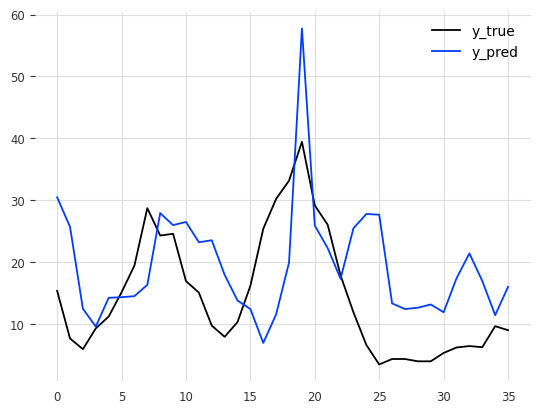

[I 2023-11-08 02:26:20,728] Trial 0 finished with value: 9.354096431305813 and parameters: {'max_iter': 118, 'alpha': 6.177593089966712e-06}. Best is trial 0 with value: 9.354096431305813.
[I 2023-11-08 02:26:20,736] A new study created in memory with name: PoissonRegressor


mean_squared_error: 126.8750
rmse: 11.263880854689134
mape: 1.1059349790451891
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
🐰Bụt Đây!!
PARAMS:  {'max_iter': 118, 'alpha': 6.177593089966712e-06}
⭐️⭐️ City:  BR Vũng Tàu


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
162           0.600266        0.578842            0.636516        0.500000   
163           0.687915        0.319830            0.485762        0.157895   
164           0.509960        0.847562            0.615578        0.657895   
165           0.722444        0.000000            0.255444        0.000000   
166           0.775564        0.401406            0.410385        0.263158   
167           0.709827        0.463564            0.494137        0.315790   
168           0.739044        0.462895            0.489950        0.394737   
169           0.785525        0.466243            0.502513        0.394737   
170           0.526560        0.551055            0.820770        0.394737   
171           0.440239        0.590113            0.381072        0.394737   
172           0.553121        0.525388            0.448074        0.394737   
173           0.825365        0.476286            0.464824        0.394737   
174           0.685923        0.335677            0.481575        0.394737   
175           0.646082        0.567794            0.582077        0.394737   
176           0.626162        0.359112            0.393635        0.394737   
177           0.725764        0.496373            0.628141        0.394737   
178           0.606242        0.311126            0.305695        0.394737   
179           0.812085        0.424953            0.427136        0.394737   
180           0.599602        0.504185            0.640703        0.394737   
181           0.792165        0.458431            0.452261        0.394737   
182           0.480080        0.721794            0.477387        0.394737   
183           0.413679        0.250865            0.485762        0.394737   
184           0.938247        0.542127            0.540201        0.394737   
185           0.559761        0.524272            0.519263        0.394737   
186           0.792165        0.427185            0.485762        0.394737   
187           0.400398        0.498605            0.598827        0.394737   
188           0.838645        0.357996            0.427136        0.394737   
189           0.725764        0.366923            0.335008        0.394737   
190           0.758964        0.475170            0.561139        0.394737   
191           0.626162        0.448387            0.422948        0.394737   
192           0.785525        0.457315            0.481575        0.394737   
193           0.592962        0.462895            0.489950        0.394737   
194           0.612882        0.580069            0.690955        0.394737   
195           0.294157        0.458431            0.414573        0.394737   
196           0.832005        0.567794            0.502513        0.394737   
197           0.705843        0.506417            0.531826        0.394737   
198           0.699203        0.508649            0.519263        0.394737   
199           0.526560        0.409329            0.510888        0.394737   
200           0.739044        0.344604            0.414573        0.394737   
201           0.652722        0.459547            0.728643        0.394737   
202           0.832005        0.362459            0.201005        0.394737   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
162                0.325                 0.523810                 0.363636   
163                0.625                 0.666667                 0.590909   
164                0.125                 0.238095                 0.250000   
165                0.450                 0.619048                 0.409091   
166                0.300                 0.476191                 0.318182   
167                0.225                 0.404762                 0.204545   
168                0.500                 0.547619                 0.636364   
169                0.775                 0.857143                 0.750000   
170                0.550  

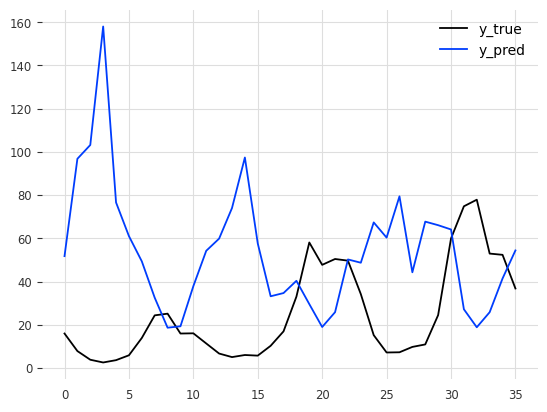

[I 2023-11-08 02:26:20,883] Trial 0 finished with value: 42.04242457872784 and parameters: {'max_iter': 107, 'alpha': 0.005754476622402849}. Best is trial 0 with value: 42.04242457872784.
[I 2023-11-08 02:26:20,893] A new study created in memory with name: PoissonRegressor


mean_squared_error: 2809.9273
rmse: 53.008747159529456
mape: 6.230951346532247
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
🐰Bụt Đây!!
PARAMS:  {'max_iter': 107, 'alpha': 0.005754476622402849}
⭐️⭐️ City:  Bình Phước


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
162           0.501848        0.540326            0.480472        0.500000   
163           0.633407        0.556999            0.522619        0.472222   
164           0.515151        0.447169            0.441135        0.583333   
165           0.690318        0.337437            0.407418        0.305556   
166           0.822616        0.380671            0.393369        0.166667   
167           0.861050        0.493796            0.480472        0.333333   
168           0.556541        0.523265            0.550717        0.500000   
169           0.571323        0.616324            0.525428        0.500000   
170           0.504804        0.541683            0.522619        0.500000   
171           0.246120        0.536836            0.472043        0.500000   
172           0.586105        0.639589            0.511380        0.500000   
173           0.541759        0.686119            0.570385        0.500000   
174           0.652624        0.282862            0.384940        0.500000   
175           0.497413        0.500969            0.500140        0.500000   
176           0.623060        0.448624            0.429896        0.500000   
177           0.770880        0.424389            0.553526        0.500000   
178           0.830007        0.365258            0.460804        0.500000   
179           0.586105        0.453470            0.345603        0.500000   
180           0.593496        0.500969            0.477662        0.500000   
181           0.889135        0.516479            0.533858        0.500000   
182           0.172210        0.804381            0.958134        0.500000   
183           0.305248        0.315820            0.016859        0.500000   
184           0.696970        0.642497            0.581624        0.500000   
185           0.571323        0.838309            0.671537        0.500000   
186           0.674797        0.110314            0.278168        0.500000   
187           0.179601        0.763668            0.581624        0.500000   
188           0.756098        0.204343            0.337173        0.500000   
189           0.800443        0.474796            0.466423        0.500000   
190           1.000000        0.327452            0.438325        0.500000   
191           0.807834        0.482551            0.432706        0.500000   
192           0.778270        0.501939            0.488901        0.500000   
193           0.689579        0.523265            0.514189        0.500000   
194           0.157428        0.624079            0.545097        0.500000   
195           0.002217        0.646375            0.553526        0.500000   
196           0.719143        0.475766            0.491711        0.500000   
197           0.630451        0.661884            0.508570        0.500000   
198           0.549150        0.465103            0.553526        0.500000   
199           0.475240        0.380768            0.331554        0.500000   
200           0.778270        0.670609            0.764260        0.500000   
201           0.652624        0.138426            0.140489        0.500000   
202           0.793053        0.501939            0.438325        0.500000   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
162             0.461539                 0.377049                 0.378378   
163             0.564103                 0.704918                 0.418919   
164             0.397436                 0.245902                 0.364865   
165             0.500000                 0.639344                 0.283784   
166             0.461539                 0.590164                 0.256757   
167             0.500000                 0.639344                 0.364865   
168             0.641026                 0.852459                 0.459460   
169             0.538462                 0.540984                 0.581081   
170             0.641026  

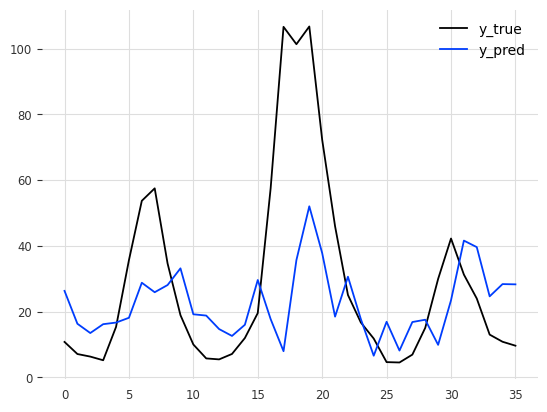

[I 2023-11-08 02:26:21,015] Trial 0 finished with value: 18.42605639218776 and parameters: {'max_iter': 142, 'alpha': 3.4640433708458655e-06}. Best is trial 0 with value: 18.42605639218776.
[I 2023-11-08 02:26:21,022] A new study created in memory with name: RandomForest


mean_squared_error: 720.2823
rmse: 26.838075565648797
mape: 0.8624778138140357
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
🐰Bụt Đây!!
PARAMS:  {'max_iter': 142, 'alpha': 3.4640433708458655e-06}
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  4
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  RandomForest
⭐️⭐️ City:  An Giang


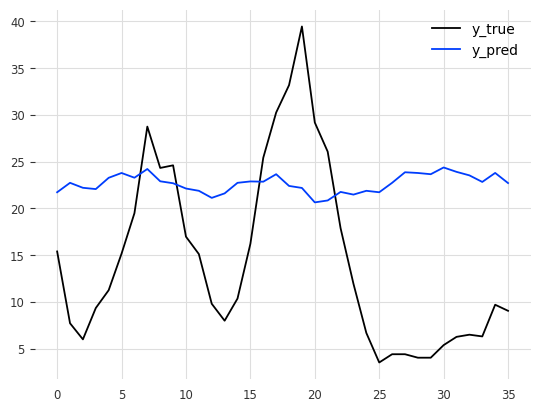

[I 2023-11-08 02:26:21,230] Trial 0 finished with value: 11.429269955701594 and parameters: {'random_state': 20, 'n_estimators': 57, 'max_depth': 3}. Best is trial 0 with value: 11.429269955701594.
[I 2023-11-08 02:26:21,237] A new study created in memory with name: RandomForest


mean_squared_error: 163.2929
rmse: 12.778611310414597
mape: 1.5730370761873642
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


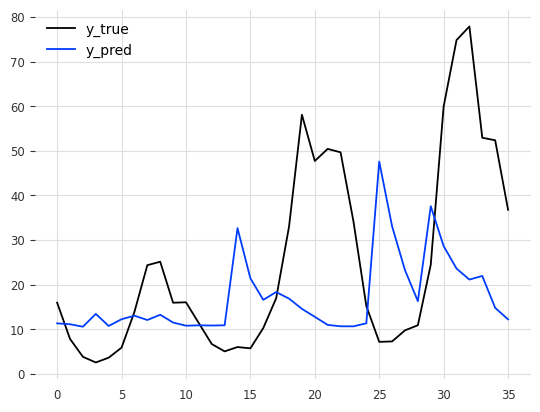

[I 2023-11-08 02:26:21,616] Trial 0 finished with value: 18.4838989266117 and parameters: {'random_state': 2, 'n_estimators': 189, 'max_depth': 5}. Best is trial 0 with value: 18.4838989266117.
[I 2023-11-08 02:26:21,624] A new study created in memory with name: RandomForest


mean_squared_error: 588.4389
rmse: 24.257759068672588
mape: 1.1436351704822725
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


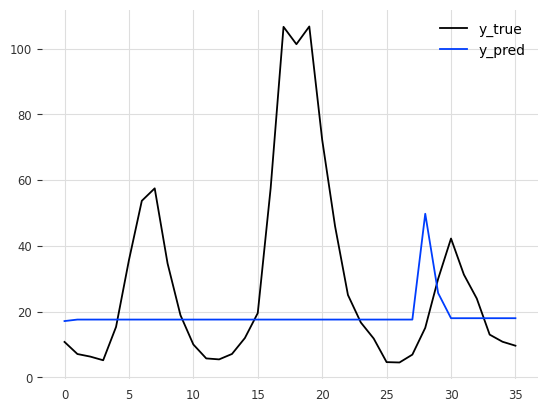

[I 2023-11-08 02:26:21,791] Trial 0 finished with value: 20.64552275115467 and parameters: {'random_state': 3, 'n_estimators': 64, 'max_depth': 1}. Best is trial 0 with value: 20.64552275115467.
[I 2023-11-08 02:26:21,798] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 983.5249
rmse: 31.361199816237452
mape: 0.9431621902022302
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LinearRegressionModel
⭐️⭐️ City:  An Giang


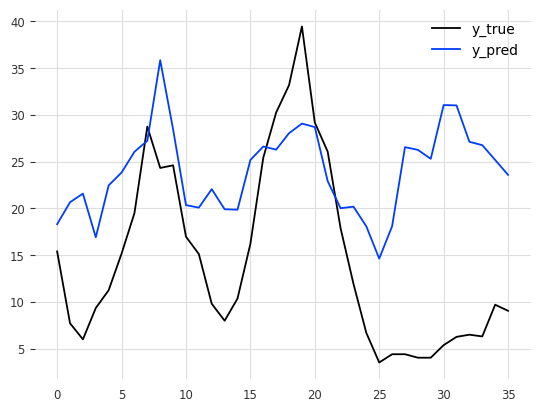

[I 2023-11-08 02:26:21,932] Trial 0 finished with value: 10.873406371717907 and parameters: {'random_state': 41}. Best is trial 0 with value: 10.873406371717907.
[I 2023-11-08 02:26:21,937] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 168.0210
rmse: 12.96229170595894
mape: 1.561287439566636
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


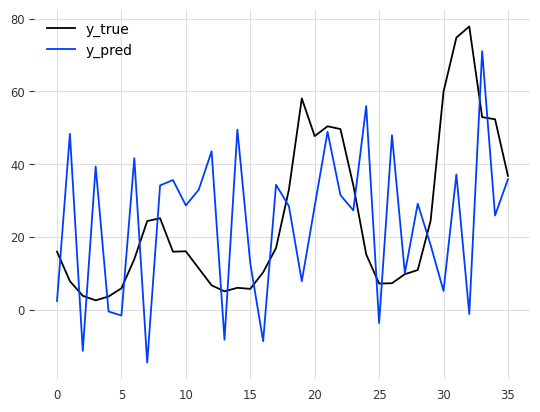

[I 2023-11-08 02:26:22,045] Trial 0 finished with value: 22.77024350491253 and parameters: {'random_state': 0}. Best is trial 0 with value: 22.77024350491253.
[I 2023-11-08 02:26:22,054] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 828.4962
rmse: 28.78361007306432
mape: 1.983649722044654
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


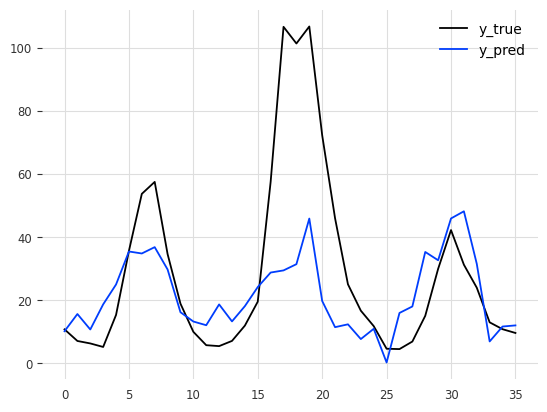

[I 2023-11-08 02:26:22,179] Trial 0 finished with value: 15.475728622573415 and parameters: {'random_state': 32}. Best is trial 0 with value: 15.475728622573415.
[I 2023-11-08 02:26:22,205] A new study created in memory with name: CatBoostModel


mean_squared_error: 614.9901
rmse: 24.7989931008203
mape: 0.6904014838152673
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


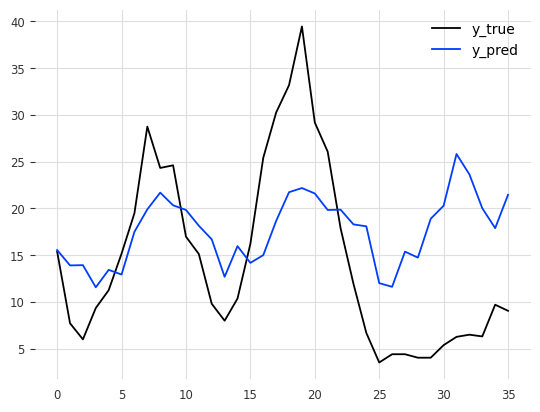

[I 2023-11-08 02:26:25,132] Trial 0 finished with value: 7.951064641375518 and parameters: {'learning_rate': 0.04199285529634466, 'n_estimators': 88, 'max_depth': 10, 'random_state': 829, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 13.626857645839717, 'border_count': 200, 'l2_leaf_reg': 6.9513439713533, 'random_strength': 6.341389291426177}. Best is trial 0 with value: 7.951064641375518.
[I 2023-11-08 02:26:25,143] A new study created in memory with name: CatBoostModel


mean_squared_error: 88.2508
rmse: 9.394187207012145
mape: 0.9975983119119252
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


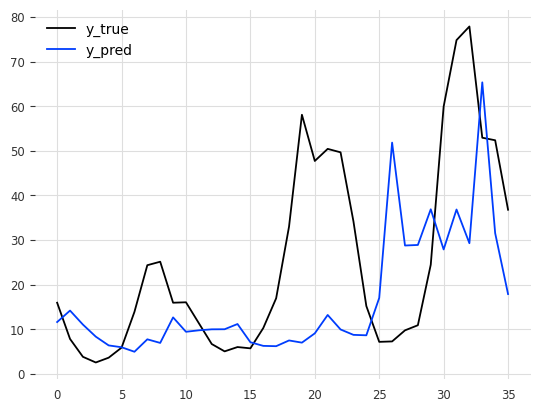

[I 2023-11-08 02:26:25,718] Trial 0 finished with value: 16.949794690478285 and parameters: {'learning_rate': 0.040106024899561395, 'n_estimators': 75, 'max_depth': 6, 'random_state': 764, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 73.58135592548973, 'border_count': 170, 'l2_leaf_reg': 5.754895895121833, 'random_strength': 4.5179628909578735}. Best is trial 0 with value: 16.949794690478285.
[I 2023-11-08 02:26:25,725] A new study created in memory with name: CatBoostModel


mean_squared_error: 505.6472
rmse: 22.486600822565038
mape: 0.8904540285533071
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


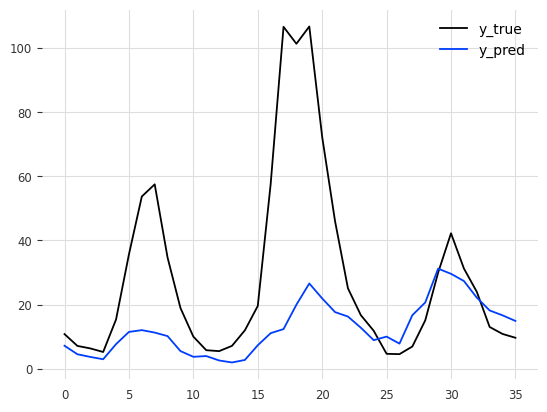

[I 2023-11-08 02:26:25,892] Trial 0 finished with value: 18.40925455168299 and parameters: {'learning_rate': 0.0783393413182502, 'n_estimators': 149, 'max_depth': 1, 'random_state': 805, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 91.18603555549451, 'border_count': 185, 'l2_leaf_reg': 6.3971497753026085, 'random_strength': 7.09166689279259}. Best is trial 0 with value: 18.40925455168299.
[I 2023-11-08 02:26:25,899] A new study created in memory with name: XGBModel


mean_squared_error: 932.9440
rmse: 30.5441315383163
mape: 0.5655167253231004
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  XGBModel
⭐️⭐️ City:  An Giang


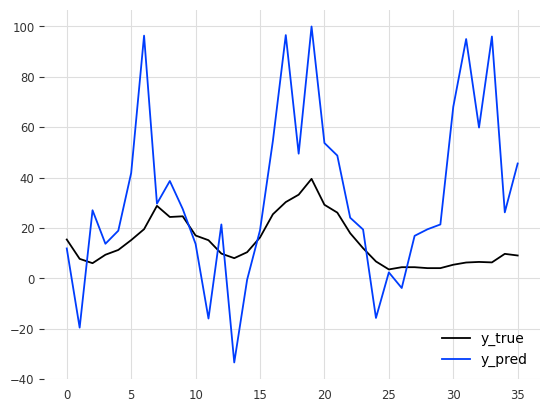

[I 2023-11-08 02:26:26,792] Trial 0 finished with value: 26.2192413435652 and parameters: {'random_state': 26, 'likelihood': 'quantile'}. Best is trial 0 with value: 26.2192413435652.
[I 2023-11-08 02:26:26,797] A new study created in memory with name: XGBModel


mean_squared_error: 1304.8621
rmse: 36.12287528031859
mape: 2.864122952111652
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


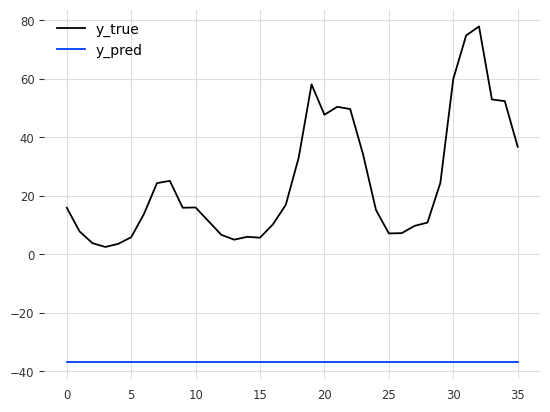

[I 2023-11-08 02:26:27,456] Trial 0 finished with value: 61.912760787433044 and parameters: {'random_state': 1, 'likelihood': 'quantile'}. Best is trial 0 with value: 61.912760787433044.
[I 2023-11-08 02:26:27,462] A new study created in memory with name: XGBModel


mean_squared_error: 4297.5343
rmse: 65.55558213212774
mape: 4.415278467123087
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


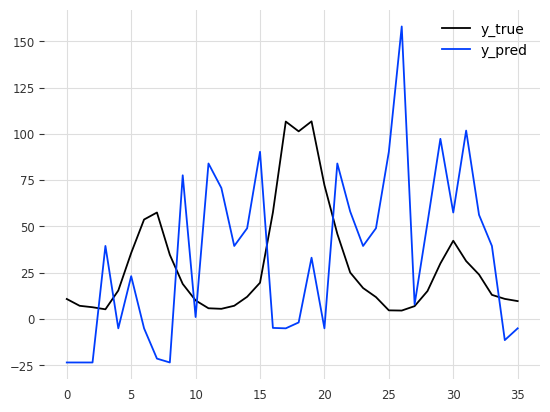

[I 2023-11-08 02:26:28,185] Trial 0 finished with value: 49.81010165502647 and parameters: {'random_state': 40, 'likelihood': 'quantile'}. Best is trial 0 with value: 49.81010165502647.
[I 2023-11-08 02:26:28,192] A new study created in memory with name: SVMRBF


mean_squared_error: 3509.2501
rmse: 59.23892410080138
mape: 3.9708559820961216
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  SVMRBF
⭐️⭐️ City:  An Giang


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
161           0.383333        0.567166            0.445122        0.707317   
162           0.535057        0.425817            0.462544        0.463415   
163           0.381609        0.445504            0.405923        0.585366   
164           0.405172        0.578474            0.671603        0.560976   
165           0.452299        0.338692            0.096690        0.439024   
166           0.562644        0.429837            0.636760        0.292683   
167           0.560345        0.363215            0.074913        0.390244   
168           0.258621        0.464578            0.423345        0.560976   
169           0.672414        0.482970            0.445122        0.560976   
170           0.402299        0.501362            0.675958        0.560976   
171           0.287356        0.557221            0.392857        0.560976   
172           0.419540        0.424387            0.371080        0.560976   
173           0.465517        0.451635            0.384146        0.560976   
174           0.362069        0.497956            0.462544        0.560976   
175           0.482759        0.423706            0.358014        0.560976   
176           0.379310        0.455041            0.384146        0.560976   
177           0.494253        0.515668            0.680314        0.560976   
178           0.597701        0.357629            0.140244        0.560976   
179           0.339081        0.447548            0.379791        0.560976   
180           1.000000        0.465259            0.436411        0.560976   
181           0.000000        0.480245            0.440767        0.560976   
182           0.436782        0.549046            0.593206        0.560976   
183           0.275862        0.487738            0.362369        0.560976   
184           0.660919        0.391689            0.349303        0.560976   
185           0.396552        0.551771            0.501742        0.560976   
186           0.614942        0.380109            0.375435        0.560976   
187           0.149425        0.509537            0.449477        0.560976   
188           0.454023        0.478202            0.471254        0.560976   
189           0.442529        0.447548            0.601916        0.560976   
190           0.563218        0.365123            0.061847        0.560976   
191           0.396552        0.465940            0.427700        0.560976   
192           0.465517        0.463215            0.418990        0.560976   
193           0.551724        0.463896            0.418990        0.560976   
194           0.431034        0.490463            0.479965        0.560976   
195           0.229885        0.535422            0.580139        0.560976   
196           0.511494        0.435286            0.344948        0.560976   
197           0.511494        0.465940            0.414634        0.560976   
198           0.494253        1.000000            0.401568        0.560976   
199           0.275862        0.000000            0.493031        0.560976   
200           0.465517        0.474796            0.475610        0.560976   
201           0.500000        0.354905            0.244774        0.560976   
202           0.574713        0.453678            0.523519        0.560976   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
161             0.403226                 0.179104                 0.383562   
162             0.629032                 0.358209                 0.561644   
163             0.596774                 0.358209                 0.589041   
164             0.451613                 0.149254                 0.438356   
165             0.516129                 0.373134                 0.465753   
166             0.516129                 0.343284                 0.410959   
167             0.483871                 0.313433                 0.506849   
168             0.629032  

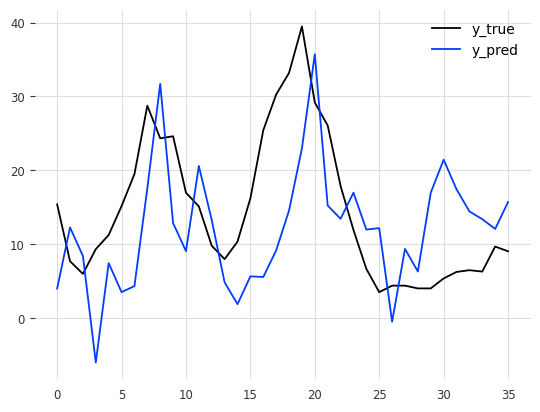

[I 2023-11-08 02:26:28,299] Trial 0 finished with value: 9.078466268689603 and parameters: {'max_iter': 110, 'epsilon': 0.04294518227746755}. Best is trial 0 with value: 9.078466268689603.
[I 2023-11-08 02:26:28,304] A new study created in memory with name: SVMRBF


mean_squared_error: 108.8313
rmse: 10.4322260018598
mape: 0.8491594528919412
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
161           0.591634        0.369825            0.276382        0.394737   
162           0.600266        0.578842            0.636516        0.500000   
163           0.687915        0.319830            0.485762        0.157895   
164           0.509960        0.847562            0.615578        0.657895   
165           0.722444        0.000000            0.255444        0.000000   
166           0.775564        0.401406            0.410385        0.263158   
167           0.709827        0.463564            0.494137        0.315790   
168           0.739044        0.462895            0.489950        0.394737   
169           0.785525        0.466243            0.502513        0.394737   
170           0.526560        0.551055            0.820770        0.394737   
171           0.440239        0.590113            0.381072        0.394737   
172           0.553121        0.525388            0.448074        0.394737   
173           0.825365        0.476286            0.464824        0.394737   
174           0.685923        0.335677            0.481575        0.394737   
175           0.646082        0.567794            0.582077        0.394737   
176           0.626162        0.359112            0.393635        0.394737   
177           0.725764        0.496373            0.628141        0.394737   
178           0.606242        0.311126            0.305695        0.394737   
179           0.812085        0.424953            0.427136        0.394737   
180           0.599602        0.504185            0.640703        0.394737   
181           0.792165        0.458431            0.452261        0.394737   
182           0.480080        0.721794            0.477387        0.394737   
183           0.413679        0.250865            0.485762        0.394737   
184           0.938247        0.542127            0.540201        0.394737   
185           0.559761        0.524272            0.519263        0.394737   
186           0.792165        0.427185            0.485762        0.394737   
187           0.400398        0.498605            0.598827        0.394737   
188           0.838645        0.357996            0.427136        0.394737   
189           0.725764        0.366923            0.335008        0.394737   
190           0.758964        0.475170            0.561139        0.394737   
191           0.626162        0.448387            0.422948        0.394737   
192           0.785525        0.457315            0.481575        0.394737   
193           0.592962        0.462895            0.489950        0.394737   
194           0.612882        0.580069            0.690955        0.394737   
195           0.294157        0.458431            0.414573        0.394737   
196           0.832005        0.567794            0.502513        0.394737   
197           0.705843        0.506417            0.531826        0.394737   
198           0.699203        0.508649            0.519263        0.394737   
199           0.526560        0.409329            0.510888        0.394737   
200           0.739044        0.344604            0.414573        0.394737   
201           0.652722        0.459547            0.728643        0.394737   
202           0.832005        0.362459            0.201005        0.394737   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
161                0.175                 0.309524                 0.250000   
162                0.325                 0.523810                 0.363636   
163                0.625                 0.666667                 0.590909   
164                0.125                 0.238095                 0.250000   
165                0.450                 0.619048                 0.409091   
166                0.300                 0.476191                 0.318182   
167                0.225                 0.404762                 0.204545   
168                0.500  

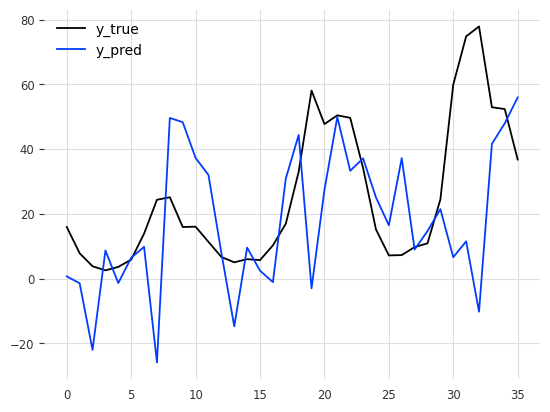

[I 2023-11-08 02:26:28,436] Trial 0 finished with value: 18.81102552919777 and parameters: {'max_iter': 103, 'epsilon': 0.0005902942401469456}. Best is trial 0 with value: 18.81102552919777.
[I 2023-11-08 02:26:28,443] A new study created in memory with name: SVMRBF


mean_squared_error: 767.7213
rmse: 27.707784554793786
mape: 1.1410692816970405
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
161           0.499630        0.597712            0.488901        0.638889   
162           0.501848        0.540326            0.480472        0.500000   
163           0.633407        0.556999            0.522619        0.472222   
164           0.515151        0.447169            0.441135        0.583333   
165           0.690318        0.337437            0.407418        0.305556   
166           0.822616        0.380671            0.393369        0.166667   
167           0.861050        0.493796            0.480472        0.333333   
168           0.556541        0.523265            0.550717        0.500000   
169           0.571323        0.616324            0.525428        0.500000   
170           0.504804        0.541683            0.522619        0.500000   
171           0.246120        0.536836            0.472043        0.500000   
172           0.586105        0.639589            0.511380        0.500000   
173           0.541759        0.686119            0.570385        0.500000   
174           0.652624        0.282862            0.384940        0.500000   
175           0.497413        0.500969            0.500140        0.500000   
176           0.623060        0.448624            0.429896        0.500000   
177           0.770880        0.424389            0.553526        0.500000   
178           0.830007        0.365258            0.460804        0.500000   
179           0.586105        0.453470            0.345603        0.500000   
180           0.593496        0.500969            0.477662        0.500000   
181           0.889135        0.516479            0.533858        0.500000   
182           0.172210        0.804381            0.958134        0.500000   
183           0.305248        0.315820            0.016859        0.500000   
184           0.696970        0.642497            0.581624        0.500000   
185           0.571323        0.838309            0.671537        0.500000   
186           0.674797        0.110314            0.278168        0.500000   
187           0.179601        0.763668            0.581624        0.500000   
188           0.756098        0.204343            0.337173        0.500000   
189           0.800443        0.474796            0.466423        0.500000   
190           1.000000        0.327452            0.438325        0.500000   
191           0.807834        0.482551            0.432706        0.500000   
192           0.778270        0.501939            0.488901        0.500000   
193           0.689579        0.523265            0.514189        0.500000   
194           0.157428        0.624079            0.545097        0.500000   
195           0.002217        0.646375            0.553526        0.500000   
196           0.719143        0.475766            0.491711        0.500000   
197           0.630451        0.661884            0.508570        0.500000   
198           0.549150        0.465103            0.553526        0.500000   
199           0.475240        0.380768            0.331554        0.500000   
200           0.778270        0.670609            0.764260        0.500000   
201           0.652624        0.138426            0.140489        0.500000   
202           0.793053        0.501939            0.438325        0.500000   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
161             0.397436                 0.377049                 0.337838   
162             0.461539                 0.377049                 0.378378   
163             0.564103                 0.704918                 0.418919   
164             0.397436                 0.245902                 0.364865   
165             0.500000                 0.639344                 0.283784   
166             0.461539                 0.590164                 0.256757   
167             0.500000                 0.639344                 0.364865   
168             0.641026  

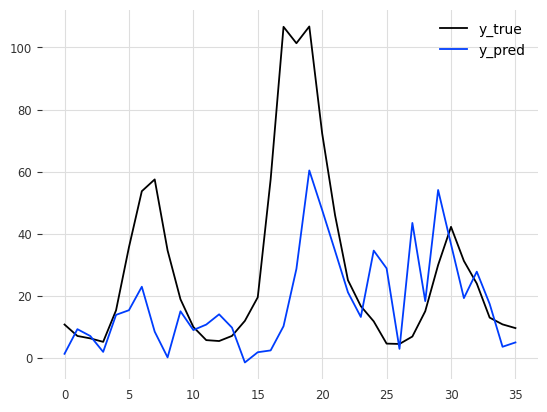

[I 2023-11-08 02:26:28,599] Trial 0 finished with value: 18.54444852484761 and parameters: {'max_iter': 146, 'epsilon': 0.00019251811601282386}. Best is trial 0 with value: 18.54444852484761.
[I 2023-11-08 02:26:28,606] A new study created in memory with name: PoissonRegressor


mean_squared_error: 818.7463
rmse: 28.613742541250883
mape: 0.8324530041045208
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  PoissonRegressor
⭐️⭐️ City:  An Giang


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
161           0.383333        0.567166            0.445122        0.707317   
162           0.535057        0.425817            0.462544        0.463415   
163           0.381609        0.445504            0.405923        0.585366   
164           0.405172        0.578474            0.671603        0.560976   
165           0.452299        0.338692            0.096690        0.439024   
166           0.562644        0.429837            0.636760        0.292683   
167           0.560345        0.363215            0.074913        0.390244   
168           0.258621        0.464578            0.423345        0.560976   
169           0.672414        0.482970            0.445122        0.560976   
170           0.402299        0.501362            0.675958        0.560976   
171           0.287356        0.557221            0.392857        0.560976   
172           0.419540        0.424387            0.371080        0.560976   
173           0.465517        0.451635            0.384146        0.560976   
174           0.362069        0.497956            0.462544        0.560976   
175           0.482759        0.423706            0.358014        0.560976   
176           0.379310        0.455041            0.384146        0.560976   
177           0.494253        0.515668            0.680314        0.560976   
178           0.597701        0.357629            0.140244        0.560976   
179           0.339081        0.447548            0.379791        0.560976   
180           1.000000        0.465259            0.436411        0.560976   
181           0.000000        0.480245            0.440767        0.560976   
182           0.436782        0.549046            0.593206        0.560976   
183           0.275862        0.487738            0.362369        0.560976   
184           0.660919        0.391689            0.349303        0.560976   
185           0.396552        0.551771            0.501742        0.560976   
186           0.614942        0.380109            0.375435        0.560976   
187           0.149425        0.509537            0.449477        0.560976   
188           0.454023        0.478202            0.471254        0.560976   
189           0.442529        0.447548            0.601916        0.560976   
190           0.563218        0.365123            0.061847        0.560976   
191           0.396552        0.465940            0.427700        0.560976   
192           0.465517        0.463215            0.418990        0.560976   
193           0.551724        0.463896            0.418990        0.560976   
194           0.431034        0.490463            0.479965        0.560976   
195           0.229885        0.535422            0.580139        0.560976   
196           0.511494        0.435286            0.344948        0.560976   
197           0.511494        0.465940            0.414634        0.560976   
198           0.494253        1.000000            0.401568        0.560976   
199           0.275862        0.000000            0.493031        0.560976   
200           0.465517        0.474796            0.475610        0.560976   
201           0.500000        0.354905            0.244774        0.560976   
202           0.574713        0.453678            0.523519        0.560976   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
161             0.403226                 0.179104                 0.383562   
162             0.629032                 0.358209                 0.561644   
163             0.596774                 0.358209                 0.589041   
164             0.451613                 0.149254                 0.438356   
165             0.516129                 0.373134                 0.465753   
166             0.516129                 0.343284                 0.410959   
167             0.483871                 0.313433                 0.506849   
168             0.629032  

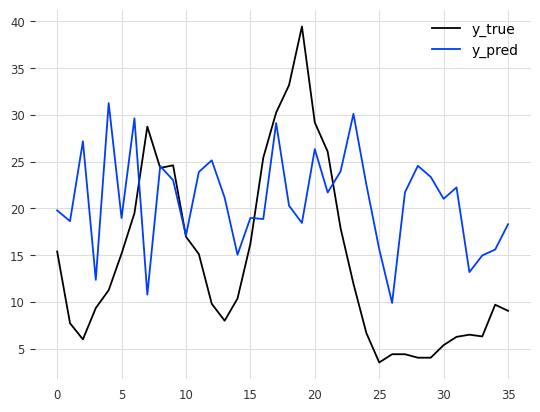

[I 2023-11-08 02:26:28,723] Trial 0 finished with value: 10.109958755349451 and parameters: {'max_iter': 184, 'alpha': 1.1698238800823383e-05}. Best is trial 0 with value: 10.109958755349451.
[I 2023-11-08 02:26:28,728] A new study created in memory with name: PoissonRegressor


mean_squared_error: 146.3006
rmse: 12.095480232876193
mape: 1.3024805095219016
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
🐰Bụt Đây!!
PARAMS:  {'max_iter': 184, 'alpha': 1.1698238800823383e-05}
⭐️⭐️ City:  BR Vũng Tàu


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
161           0.591634        0.369825            0.276382        0.394737   
162           0.600266        0.578842            0.636516        0.500000   
163           0.687915        0.319830            0.485762        0.157895   
164           0.509960        0.847562            0.615578        0.657895   
165           0.722444        0.000000            0.255444        0.000000   
166           0.775564        0.401406            0.410385        0.263158   
167           0.709827        0.463564            0.494137        0.315790   
168           0.739044        0.462895            0.489950        0.394737   
169           0.785525        0.466243            0.502513        0.394737   
170           0.526560        0.551055            0.820770        0.394737   
171           0.440239        0.590113            0.381072        0.394737   
172           0.553121        0.525388            0.448074        0.394737   
173           0.825365        0.476286            0.464824        0.394737   
174           0.685923        0.335677            0.481575        0.394737   
175           0.646082        0.567794            0.582077        0.394737   
176           0.626162        0.359112            0.393635        0.394737   
177           0.725764        0.496373            0.628141        0.394737   
178           0.606242        0.311126            0.305695        0.394737   
179           0.812085        0.424953            0.427136        0.394737   
180           0.599602        0.504185            0.640703        0.394737   
181           0.792165        0.458431            0.452261        0.394737   
182           0.480080        0.721794            0.477387        0.394737   
183           0.413679        0.250865            0.485762        0.394737   
184           0.938247        0.542127            0.540201        0.394737   
185           0.559761        0.524272            0.519263        0.394737   
186           0.792165        0.427185            0.485762        0.394737   
187           0.400398        0.498605            0.598827        0.394737   
188           0.838645        0.357996            0.427136        0.394737   
189           0.725764        0.366923            0.335008        0.394737   
190           0.758964        0.475170            0.561139        0.394737   
191           0.626162        0.448387            0.422948        0.394737   
192           0.785525        0.457315            0.481575        0.394737   
193           0.592962        0.462895            0.489950        0.394737   
194           0.612882        0.580069            0.690955        0.394737   
195           0.294157        0.458431            0.414573        0.394737   
196           0.832005        0.567794            0.502513        0.394737   
197           0.705843        0.506417            0.531826        0.394737   
198           0.699203        0.508649            0.519263        0.394737   
199           0.526560        0.409329            0.510888        0.394737   
200           0.739044        0.344604            0.414573        0.394737   
201           0.652722        0.459547            0.728643        0.394737   
202           0.832005        0.362459            0.201005        0.394737   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
161                0.175                 0.309524                 0.250000   
162                0.325                 0.523810                 0.363636   
163                0.625                 0.666667                 0.590909   
164                0.125                 0.238095                 0.250000   
165                0.450                 0.619048                 0.409091   
166                0.300                 0.476191                 0.318182   
167                0.225                 0.404762                 0.204545   
168                0.500  

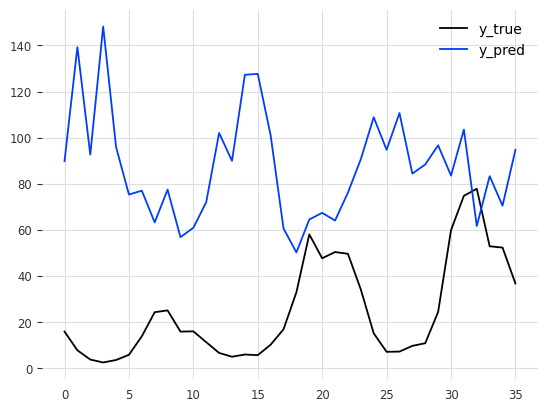

[I 2023-11-08 02:26:28,993] Trial 0 finished with value: 63.48495113904336 and parameters: {'max_iter': 200, 'alpha': 0.027622630239007465}. Best is trial 0 with value: 63.48495113904336.


mean_squared_error: 5332.4639
rmse: 73.02372118713133
mape: 8.329746288353597
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
🐰Bụt Đây!!
PARAMS:  {'max_iter': 200, 'alpha': 0.027622630239007465}


[I 2023-11-08 02:26:29,203] A new study created in memory with name: PoissonRegressor


⭐️⭐️ City:  Bình Phước


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
161           0.499630        0.597712            0.488901        0.638889   
162           0.501848        0.540326            0.480472        0.500000   
163           0.633407        0.556999            0.522619        0.472222   
164           0.515151        0.447169            0.441135        0.583333   
165           0.690318        0.337437            0.407418        0.305556   
166           0.822616        0.380671            0.393369        0.166667   
167           0.861050        0.493796            0.480472        0.333333   
168           0.556541        0.523265            0.550717        0.500000   
169           0.571323        0.616324            0.525428        0.500000   
170           0.504804        0.541683            0.522619        0.500000   
171           0.246120        0.536836            0.472043        0.500000   
172           0.586105        0.639589            0.511380        0.500000   
173           0.541759        0.686119            0.570385        0.500000   
174           0.652624        0.282862            0.384940        0.500000   
175           0.497413        0.500969            0.500140        0.500000   
176           0.623060        0.448624            0.429896        0.500000   
177           0.770880        0.424389            0.553526        0.500000   
178           0.830007        0.365258            0.460804        0.500000   
179           0.586105        0.453470            0.345603        0.500000   
180           0.593496        0.500969            0.477662        0.500000   
181           0.889135        0.516479            0.533858        0.500000   
182           0.172210        0.804381            0.958134        0.500000   
183           0.305248        0.315820            0.016859        0.500000   
184           0.696970        0.642497            0.581624        0.500000   
185           0.571323        0.838309            0.671537        0.500000   
186           0.674797        0.110314            0.278168        0.500000   
187           0.179601        0.763668            0.581624        0.500000   
188           0.756098        0.204343            0.337173        0.500000   
189           0.800443        0.474796            0.466423        0.500000   
190           1.000000        0.327452            0.438325        0.500000   
191           0.807834        0.482551            0.432706        0.500000   
192           0.778270        0.501939            0.488901        0.500000   
193           0.689579        0.523265            0.514189        0.500000   
194           0.157428        0.624079            0.545097        0.500000   
195           0.002217        0.646375            0.553526        0.500000   
196           0.719143        0.475766            0.491711        0.500000   
197           0.630451        0.661884            0.508570        0.500000   
198           0.549150        0.465103            0.553526        0.500000   
199           0.475240        0.380768            0.331554        0.500000   
200           0.778270        0.670609            0.764260        0.500000   
201           0.652624        0.138426            0.140489        0.500000   
202           0.793053        0.501939            0.438325        0.500000   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
161             0.397436                 0.377049                 0.337838   
162             0.461539                 0.377049                 0.378378   
163             0.564103                 0.704918                 0.418919   
164             0.397436                 0.245902                 0.364865   
165             0.500000                 0.639344                 0.283784   
166             0.461539                 0.590164                 0.256757   
167             0.500000                 0.639344                 0.364865   
168             0.641026  

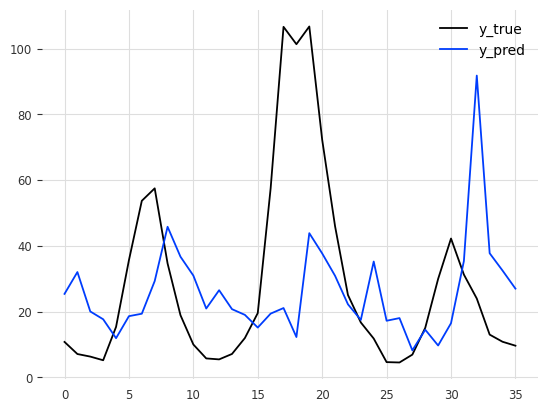

[I 2023-11-08 02:26:29,335] Trial 0 finished with value: 22.823255744252673 and parameters: {'max_iter': 177, 'alpha': 0.003790928542187525}. Best is trial 0 with value: 22.823255744252673.
[I 2023-11-08 02:26:29,342] A new study created in memory with name: RandomForest


mean_squared_error: 980.2052
rmse: 31.30822932976484
mape: 1.2611621480962367
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
🐰Bụt Đây!!
PARAMS:  {'max_iter': 177, 'alpha': 0.003790928542187525}
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  5
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  RandomForest
⭐️⭐️ City:  An Giang


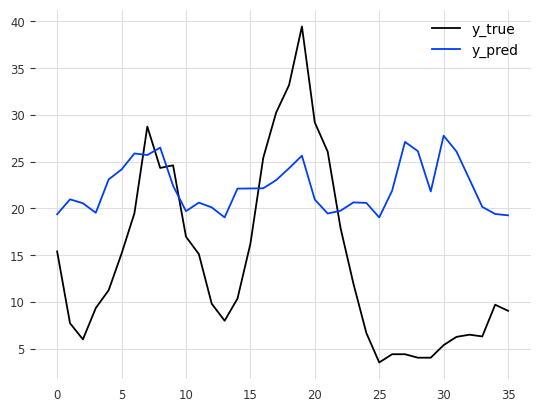

[I 2023-11-08 02:26:29,581] Trial 0 finished with value: 10.684041865251166 and parameters: {'random_state': 15, 'n_estimators': 65, 'max_depth': 3}. Best is trial 0 with value: 10.684041865251166.
[I 2023-11-08 02:26:29,587] A new study created in memory with name: RandomForest


mean_squared_error: 149.2386
rmse: 12.216324746535847
mape: 1.5057902151918952
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


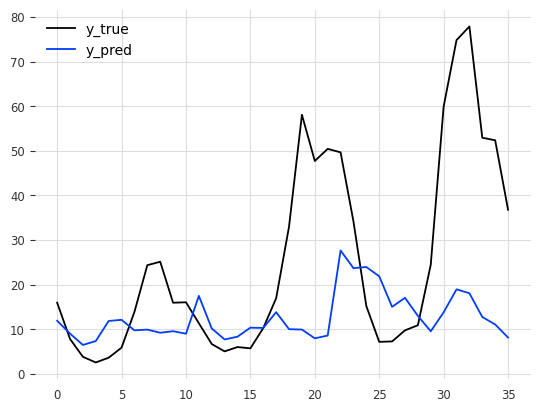

[I 2023-11-08 02:26:29,931] Trial 0 finished with value: 16.951577200621138 and parameters: {'random_state': 41, 'n_estimators': 134, 'max_depth': 14}. Best is trial 0 with value: 16.951577200621138.
[I 2023-11-08 02:26:29,937] A new study created in memory with name: RandomForest


mean_squared_error: 588.7410
rmse: 24.263984849589885
mape: 0.7074925206865776
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


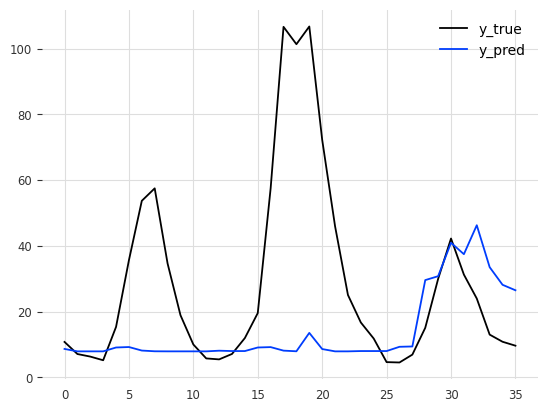

[I 2023-11-08 02:26:30,220] Trial 0 finished with value: 21.38510802440522 and parameters: {'random_state': 33, 'n_estimators': 135, 'max_depth': 3}. Best is trial 0 with value: 21.38510802440522.
[I 2023-11-08 02:26:30,227] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 1204.1848
rmse: 34.70136597633128
mape: 0.6472540221723952
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LinearRegressionModel
⭐️⭐️ City:  An Giang


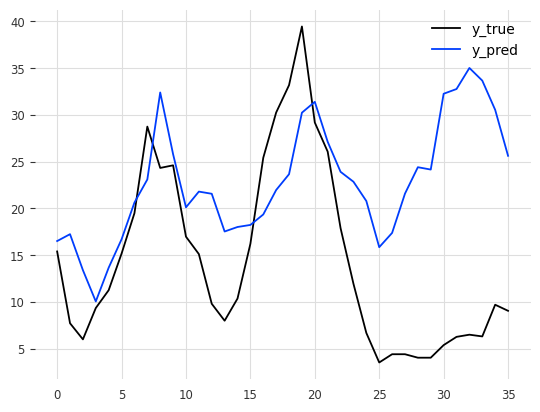

[I 2023-11-08 02:26:30,333] Trial 0 finished with value: 10.462005592447136 and parameters: {'random_state': 37}. Best is trial 0 with value: 10.462005592447136.
[I 2023-11-08 02:26:30,339] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 177.1192
rmse: 13.308615161080825
mape: 1.5062109348627983
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


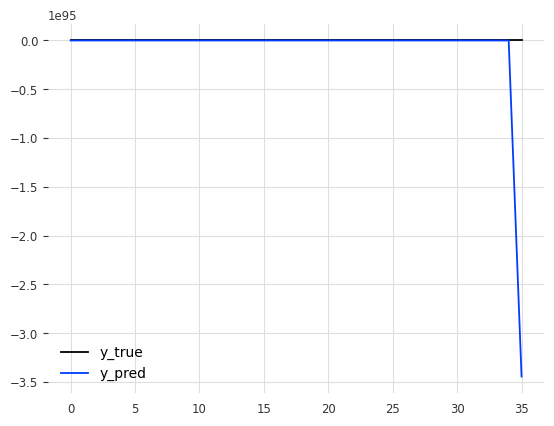

[I 2023-11-08 02:26:30,513] Trial 0 finished with value: 9.569648622018441e+93 and parameters: {'random_state': 27}. Best is trial 0 with value: 9.569648622018441e+93.
[I 2023-11-08 02:26:30,520] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 3296814290946556951471151043708385372331197352893205350429963504411341138785290535296754640445786299343382826659874682646220226101743791006985289348324438465777927573171742775933230179680256.0000
rmse: 5.741789173199027e+94
mape: 2.6012066696807043e+92
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


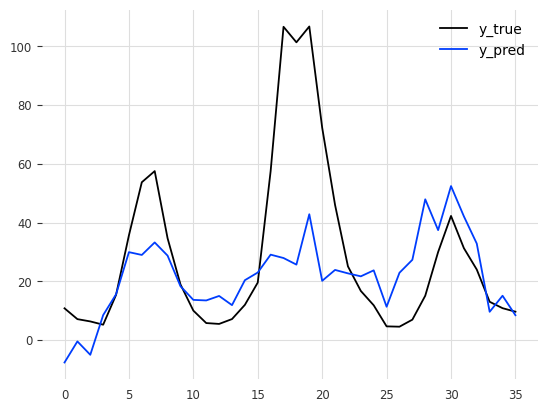

[I 2023-11-08 02:26:30,661] Trial 0 finished with value: 16.777919259812734 and parameters: {'random_state': 13}. Best is trial 0 with value: 16.777919259812734.
[I 2023-11-08 02:26:30,670] A new study created in memory with name: CatBoostModel


mean_squared_error: 681.0011
rmse: 26.095997858872458
mape: 0.808623150723209
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


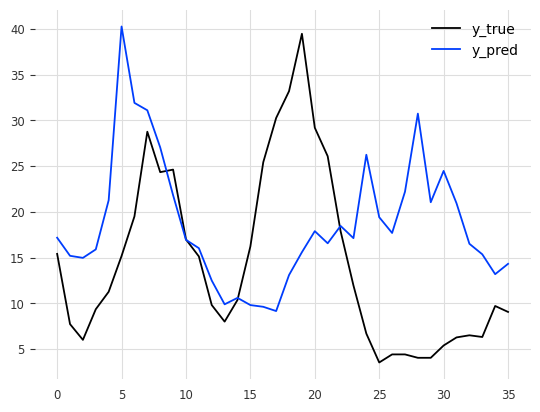

[I 2023-11-08 02:26:33,592] Trial 0 finished with value: 10.318380261629622 and parameters: {'learning_rate': 0.07437200593021015, 'n_estimators': 84, 'max_depth': 12, 'random_state': 448, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 23.914354533054894, 'border_count': 153, 'l2_leaf_reg': 8.28350752867535, 'random_strength': 0.6029063979276194}. Best is trial 0 with value: 10.318380261629622.
[I 2023-11-08 02:26:33,601] A new study created in memory with name: CatBoostModel


mean_squared_error: 166.2437
rmse: 12.8935516055972
mape: 1.293577545312586
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


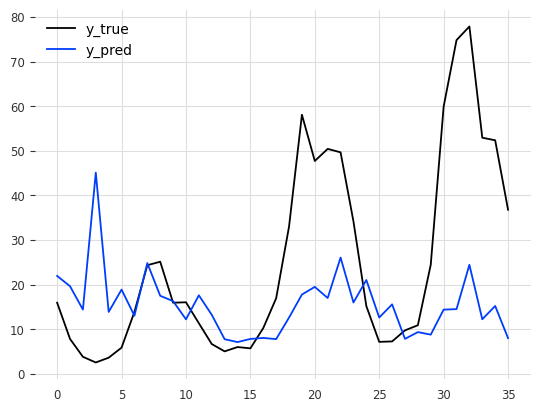

[I 2023-11-08 02:27:03,359] Trial 0 finished with value: 16.843370650499086 and parameters: {'learning_rate': 0.05669125107159225, 'n_estimators': 103, 'max_depth': 15, 'random_state': 82, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 15.351243356864272, 'border_count': 195, 'l2_leaf_reg': 0.7847693643052845, 'random_strength': 8.626208103588525}. Best is trial 0 with value: 16.843370650499086.
[I 2023-11-08 02:27:03,371] A new study created in memory with name: CatBoostModel


mean_squared_error: 563.6767
rmse: 23.741876913763953
mape: 1.1623884070648696
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


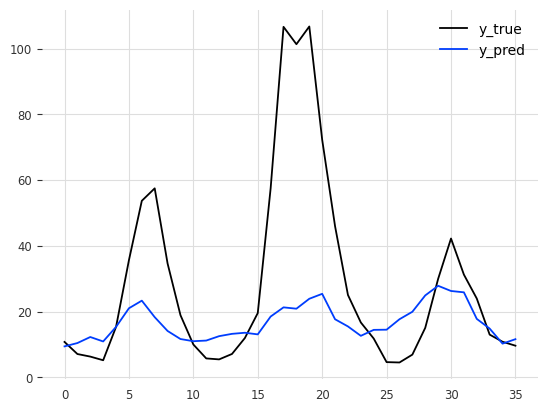

[I 2023-11-08 02:27:09,364] Trial 0 finished with value: 17.077151626807353 and parameters: {'learning_rate': 0.0952964711870208, 'n_estimators': 142, 'max_depth': 12, 'random_state': 8, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 54.86134946803436, 'border_count': 195, 'l2_leaf_reg': 5.975285704650157, 'random_strength': 3.3557357326134425}. Best is trial 0 with value: 17.077151626807353.
[I 2023-11-08 02:27:09,379] A new study created in memory with name: XGBModel


mean_squared_error: 819.0020
rmse: 28.618210987936404
mape: 0.6346311788815444
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  XGBModel
⭐️⭐️ City:  An Giang


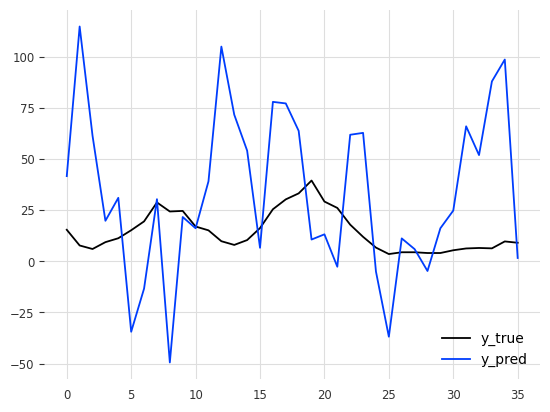

[I 2023-11-08 02:27:10,131] Trial 0 finished with value: 36.07561045224788 and parameters: {'random_state': 35, 'likelihood': 'quantile'}. Best is trial 0 with value: 36.07561045224788.
[I 2023-11-08 02:27:10,137] A new study created in memory with name: XGBModel


mean_squared_error: 2093.6619
rmse: 45.75654995132679
mape: 3.8002813360995833
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


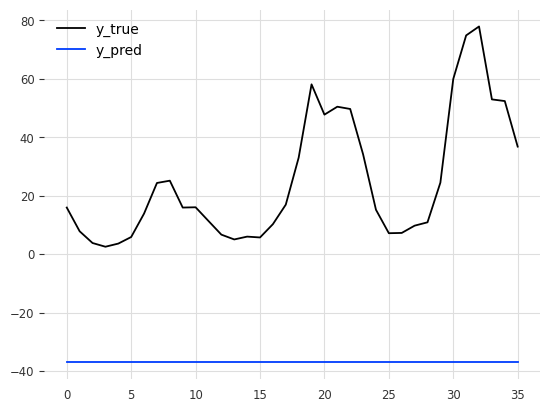

[I 2023-11-08 02:27:10,850] Trial 0 finished with value: 62.03369887740231 and parameters: {'random_state': 24, 'likelihood': 'quantile'}. Best is trial 0 with value: 62.03369887740231.
[I 2023-11-08 02:27:10,857] A new study created in memory with name: XGBModel


mean_squared_error: 4312.5242
rmse: 65.66981191363705
mape: 4.426463447462722
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


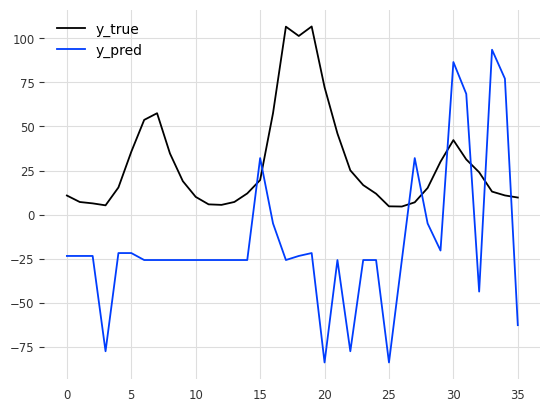

[I 2023-11-08 02:27:11,706] Trial 0 finished with value: 60.1172116259728 and parameters: {'random_state': 12, 'likelihood': 'quantile'}. Best is trial 0 with value: 60.1172116259728.
[I 2023-11-08 02:27:11,712] A new study created in memory with name: SVMRBF


mean_squared_error: 4795.8073
rmse: 69.2517676830406
mape: 3.819893045956031
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  SVMRBF
⭐️⭐️ City:  An Giang


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
160           0.574713        0.515872            0.388502        0.853658   
161           0.383333        0.567166            0.445122        0.707317   
162           0.535057        0.425817            0.462544        0.463415   
163           0.381609        0.445504            0.405923        0.585366   
164           0.405172        0.578474            0.671603        0.560976   
165           0.452299        0.338692            0.096690        0.439024   
166           0.562644        0.429837            0.636760        0.292683   
167           0.560345        0.363215            0.074913        0.390244   
168           0.258621        0.464578            0.423345        0.560976   
169           0.672414        0.482970            0.445122        0.560976   
170           0.402299        0.501362            0.675958        0.560976   
171           0.287356        0.557221            0.392857        0.560976   
172           0.419540        0.424387            0.371080        0.560976   
173           0.465517        0.451635            0.384146        0.560976   
174           0.362069        0.497956            0.462544        0.560976   
175           0.482759        0.423706            0.358014        0.560976   
176           0.379310        0.455041            0.384146        0.560976   
177           0.494253        0.515668            0.680314        0.560976   
178           0.597701        0.357629            0.140244        0.560976   
179           0.339081        0.447548            0.379791        0.560976   
180           1.000000        0.465259            0.436411        0.560976   
181           0.000000        0.480245            0.440767        0.560976   
182           0.436782        0.549046            0.593206        0.560976   
183           0.275862        0.487738            0.362369        0.560976   
184           0.660919        0.391689            0.349303        0.560976   
185           0.396552        0.551771            0.501742        0.560976   
186           0.614942        0.380109            0.375435        0.560976   
187           0.149425        0.509537            0.449477        0.560976   
188           0.454023        0.478202            0.471254        0.560976   
189           0.442529        0.447548            0.601916        0.560976   
190           0.563218        0.365123            0.061847        0.560976   
191           0.396552        0.465940            0.427700        0.560976   
192           0.465517        0.463215            0.418990        0.560976   
193           0.551724        0.463896            0.418990        0.560976   
194           0.431034        0.490463            0.479965        0.560976   
195           0.229885        0.535422            0.580139        0.560976   
196           0.511494        0.435286            0.344948        0.560976   
197           0.511494        0.465940            0.414634        0.560976   
198           0.494253        1.000000            0.401568        0.560976   
199           0.275862        0.000000            0.493031        0.560976   
200           0.465517        0.474796            0.475610        0.560976   
201           0.500000        0.354905            0.244774        0.560976   
202           0.574713        0.453678            0.523519        0.560976   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
160             0.290323                 0.268657                 0.383562   
161             0.403226                 0.179104                 0.383562   
162             0.629032                 0.358209                 0.561644   
163             0.596774                 0.358209                 0.589041   
164             0.451613                 0.149254                 0.438356   
165             0.516129                 0.373134                 0.465753   
166             0.516129  

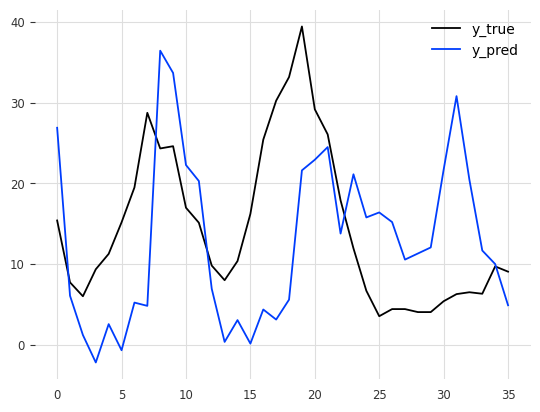

[I 2023-11-08 02:27:11,828] Trial 0 finished with value: 10.87728586134245 and parameters: {'max_iter': 63, 'epsilon': 5.41645478241997e-05}. Best is trial 0 with value: 10.87728586134245.
[I 2023-11-08 02:27:11,834] A new study created in memory with name: SVMRBF


mean_squared_error: 169.2922
rmse: 13.011234488284549
mape: 1.0609449572516265
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
160           0.885790        0.668229            0.707705        0.657895   
161           0.591634        0.369825            0.276382        0.394737   
162           0.600266        0.578842            0.636516        0.500000   
163           0.687915        0.319830            0.485762        0.157895   
164           0.509960        0.847562            0.615578        0.657895   
165           0.722444        0.000000            0.255444        0.000000   
166           0.775564        0.401406            0.410385        0.263158   
167           0.709827        0.463564            0.494137        0.315790   
168           0.739044        0.462895            0.489950        0.394737   
169           0.785525        0.466243            0.502513        0.394737   
170           0.526560        0.551055            0.820770        0.394737   
171           0.440239        0.590113            0.381072        0.394737   
172           0.553121        0.525388            0.448074        0.394737   
173           0.825365        0.476286            0.464824        0.394737   
174           0.685923        0.335677            0.481575        0.394737   
175           0.646082        0.567794            0.582077        0.394737   
176           0.626162        0.359112            0.393635        0.394737   
177           0.725764        0.496373            0.628141        0.394737   
178           0.606242        0.311126            0.305695        0.394737   
179           0.812085        0.424953            0.427136        0.394737   
180           0.599602        0.504185            0.640703        0.394737   
181           0.792165        0.458431            0.452261        0.394737   
182           0.480080        0.721794            0.477387        0.394737   
183           0.413679        0.250865            0.485762        0.394737   
184           0.938247        0.542127            0.540201        0.394737   
185           0.559761        0.524272            0.519263        0.394737   
186           0.792165        0.427185            0.485762        0.394737   
187           0.400398        0.498605            0.598827        0.394737   
188           0.838645        0.357996            0.427136        0.394737   
189           0.725764        0.366923            0.335008        0.394737   
190           0.758964        0.475170            0.561139        0.394737   
191           0.626162        0.448387            0.422948        0.394737   
192           0.785525        0.457315            0.481575        0.394737   
193           0.592962        0.462895            0.489950        0.394737   
194           0.612882        0.580069            0.690955        0.394737   
195           0.294157        0.458431            0.414573        0.394737   
196           0.832005        0.567794            0.502513        0.394737   
197           0.705843        0.506417            0.531826        0.394737   
198           0.699203        0.508649            0.519263        0.394737   
199           0.526560        0.409329            0.510888        0.394737   
200           0.739044        0.344604            0.414573        0.394737   
201           0.652722        0.459547            0.728643        0.394737   
202           0.832005        0.362459            0.201005        0.394737   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
160                0.125                 0.380952                 0.068182   
161                0.175                 0.309524                 0.250000   
162                0.325                 0.523810                 0.363636   
163                0.625                 0.666667                 0.590909   
164                0.125                 0.238095                 0.250000   
165                0.450                 0.619048                 0.409091   
166                0.300  

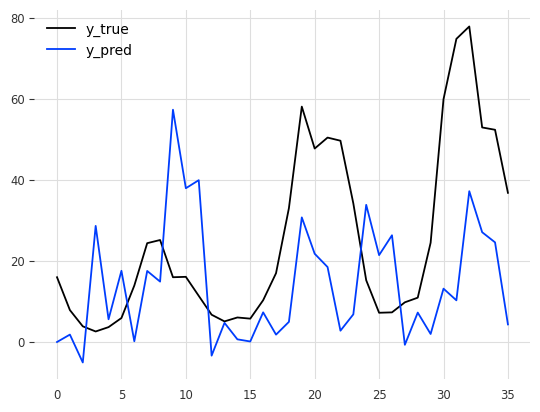

[I 2023-11-08 02:27:11,982] Trial 0 finished with value: 20.769028214227067 and parameters: {'max_iter': 189, 'epsilon': 7.561783462942129e-07}. Best is trial 0 with value: 20.769028214227067.
[I 2023-11-08 02:27:11,989] A new study created in memory with name: SVMRBF


mean_squared_error: 644.2132
rmse: 25.38135503182493
mape: 1.28350114468631
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
160           0.634146        0.579585            0.592863        0.611111   
161           0.499630        0.597712            0.488901        0.638889   
162           0.501848        0.540326            0.480472        0.500000   
163           0.633407        0.556999            0.522619        0.472222   
164           0.515151        0.447169            0.441135        0.583333   
165           0.690318        0.337437            0.407418        0.305556   
166           0.822616        0.380671            0.393369        0.166667   
167           0.861050        0.493796            0.480472        0.333333   
168           0.556541        0.523265            0.550717        0.500000   
169           0.571323        0.616324            0.525428        0.500000   
170           0.504804        0.541683            0.522619        0.500000   
171           0.246120        0.536836            0.472043        0.500000   
172           0.586105        0.639589            0.511380        0.500000   
173           0.541759        0.686119            0.570385        0.500000   
174           0.652624        0.282862            0.384940        0.500000   
175           0.497413        0.500969            0.500140        0.500000   
176           0.623060        0.448624            0.429896        0.500000   
177           0.770880        0.424389            0.553526        0.500000   
178           0.830007        0.365258            0.460804        0.500000   
179           0.586105        0.453470            0.345603        0.500000   
180           0.593496        0.500969            0.477662        0.500000   
181           0.889135        0.516479            0.533858        0.500000   
182           0.172210        0.804381            0.958134        0.500000   
183           0.305248        0.315820            0.016859        0.500000   
184           0.696970        0.642497            0.581624        0.500000   
185           0.571323        0.838309            0.671537        0.500000   
186           0.674797        0.110314            0.278168        0.500000   
187           0.179601        0.763668            0.581624        0.500000   
188           0.756098        0.204343            0.337173        0.500000   
189           0.800443        0.474796            0.466423        0.500000   
190           1.000000        0.327452            0.438325        0.500000   
191           0.807834        0.482551            0.432706        0.500000   
192           0.778270        0.501939            0.488901        0.500000   
193           0.689579        0.523265            0.514189        0.500000   
194           0.157428        0.624079            0.545097        0.500000   
195           0.002217        0.646375            0.553526        0.500000   
196           0.719143        0.475766            0.491711        0.500000   
197           0.630451        0.661884            0.508570        0.500000   
198           0.549150        0.465103            0.553526        0.500000   
199           0.475240        0.380768            0.331554        0.500000   
200           0.778270        0.670609            0.764260        0.500000   
201           0.652624        0.138426            0.140489        0.500000   
202           0.793053        0.501939            0.438325        0.500000   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
160             0.282051                 0.196721                 0.243243   
161             0.397436                 0.377049                 0.337838   
162             0.461539                 0.377049                 0.378378   
163             0.564103                 0.704918                 0.418919   
164             0.397436                 0.245902                 0.364865   
165             0.500000                 0.639344                 0.283784   
166             0.461539  

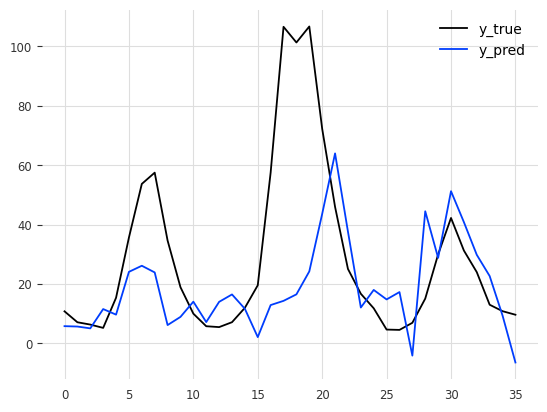

[I 2023-11-08 02:27:12,098] Trial 0 finished with value: 18.39721622355976 and parameters: {'max_iter': 199, 'epsilon': 2.355651012420467e-05}. Best is trial 0 with value: 18.39721622355976.
[I 2023-11-08 02:27:12,105] A new study created in memory with name: PoissonRegressor


mean_squared_error: 866.4265
rmse: 29.435123571134437
mape: 0.7447275802232527
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  PoissonRegressor
⭐️⭐️ City:  An Giang


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
160           0.574713        0.515872            0.388502        0.853658   
161           0.383333        0.567166            0.445122        0.707317   
162           0.535057        0.425817            0.462544        0.463415   
163           0.381609        0.445504            0.405923        0.585366   
164           0.405172        0.578474            0.671603        0.560976   
165           0.452299        0.338692            0.096690        0.439024   
166           0.562644        0.429837            0.636760        0.292683   
167           0.560345        0.363215            0.074913        0.390244   
168           0.258621        0.464578            0.423345        0.560976   
169           0.672414        0.482970            0.445122        0.560976   
170           0.402299        0.501362            0.675958        0.560976   
171           0.287356        0.557221            0.392857        0.560976   
172           0.419540        0.424387            0.371080        0.560976   
173           0.465517        0.451635            0.384146        0.560976   
174           0.362069        0.497956            0.462544        0.560976   
175           0.482759        0.423706            0.358014        0.560976   
176           0.379310        0.455041            0.384146        0.560976   
177           0.494253        0.515668            0.680314        0.560976   
178           0.597701        0.357629            0.140244        0.560976   
179           0.339081        0.447548            0.379791        0.560976   
180           1.000000        0.465259            0.436411        0.560976   
181           0.000000        0.480245            0.440767        0.560976   
182           0.436782        0.549046            0.593206        0.560976   
183           0.275862        0.487738            0.362369        0.560976   
184           0.660919        0.391689            0.349303        0.560976   
185           0.396552        0.551771            0.501742        0.560976   
186           0.614942        0.380109            0.375435        0.560976   
187           0.149425        0.509537            0.449477        0.560976   
188           0.454023        0.478202            0.471254        0.560976   
189           0.442529        0.447548            0.601916        0.560976   
190           0.563218        0.365123            0.061847        0.560976   
191           0.396552        0.465940            0.427700        0.560976   
192           0.465517        0.463215            0.418990        0.560976   
193           0.551724        0.463896            0.418990        0.560976   
194           0.431034        0.490463            0.479965        0.560976   
195           0.229885        0.535422            0.580139        0.560976   
196           0.511494        0.435286            0.344948        0.560976   
197           0.511494        0.465940            0.414634        0.560976   
198           0.494253        1.000000            0.401568        0.560976   
199           0.275862        0.000000            0.493031        0.560976   
200           0.465517        0.474796            0.475610        0.560976   
201           0.500000        0.354905            0.244774        0.560976   
202           0.574713        0.453678            0.523519        0.560976   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
160             0.290323                 0.268657                 0.383562   
161             0.403226                 0.179104                 0.383562   
162             0.629032                 0.358209                 0.561644   
163             0.596774                 0.358209                 0.589041   
164             0.451613                 0.149254                 0.438356   
165             0.516129                 0.373134                 0.465753   
166             0.516129  

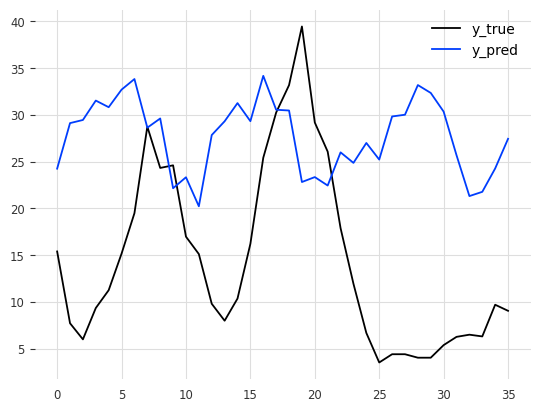

[I 2023-11-08 02:27:12,279] Trial 0 finished with value: 14.922075331133605 and parameters: {'max_iter': 135, 'alpha': 0.03905476775909197}. Best is trial 0 with value: 14.922075331133605.
[I 2023-11-08 02:27:12,285] A new study created in memory with name: PoissonRegressor


mean_squared_error: 290.4737
rmse: 17.0432888280001
mape: 2.0926215723512622
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
🐰Bụt Đây!!
PARAMS:  {'max_iter': 135, 'alpha': 0.03905476775909197}
⭐️⭐️ City:  BR Vũng Tàu


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
160           0.885790        0.668229            0.707705        0.657895   
161           0.591634        0.369825            0.276382        0.394737   
162           0.600266        0.578842            0.636516        0.500000   
163           0.687915        0.319830            0.485762        0.157895   
164           0.509960        0.847562            0.615578        0.657895   
165           0.722444        0.000000            0.255444        0.000000   
166           0.775564        0.401406            0.410385        0.263158   
167           0.709827        0.463564            0.494137        0.315790   
168           0.739044        0.462895            0.489950        0.394737   
169           0.785525        0.466243            0.502513        0.394737   
170           0.526560        0.551055            0.820770        0.394737   
171           0.440239        0.590113            0.381072        0.394737   
172           0.553121        0.525388            0.448074        0.394737   
173           0.825365        0.476286            0.464824        0.394737   
174           0.685923        0.335677            0.481575        0.394737   
175           0.646082        0.567794            0.582077        0.394737   
176           0.626162        0.359112            0.393635        0.394737   
177           0.725764        0.496373            0.628141        0.394737   
178           0.606242        0.311126            0.305695        0.394737   
179           0.812085        0.424953            0.427136        0.394737   
180           0.599602        0.504185            0.640703        0.394737   
181           0.792165        0.458431            0.452261        0.394737   
182           0.480080        0.721794            0.477387        0.394737   
183           0.413679        0.250865            0.485762        0.394737   
184           0.938247        0.542127            0.540201        0.394737   
185           0.559761        0.524272            0.519263        0.394737   
186           0.792165        0.427185            0.485762        0.394737   
187           0.400398        0.498605            0.598827        0.394737   
188           0.838645        0.357996            0.427136        0.394737   
189           0.725764        0.366923            0.335008        0.394737   
190           0.758964        0.475170            0.561139        0.394737   
191           0.626162        0.448387            0.422948        0.394737   
192           0.785525        0.457315            0.481575        0.394737   
193           0.592962        0.462895            0.489950        0.394737   
194           0.612882        0.580069            0.690955        0.394737   
195           0.294157        0.458431            0.414573        0.394737   
196           0.832005        0.567794            0.502513        0.394737   
197           0.705843        0.506417            0.531826        0.394737   
198           0.699203        0.508649            0.519263        0.394737   
199           0.526560        0.409329            0.510888        0.394737   
200           0.739044        0.344604            0.414573        0.394737   
201           0.652722        0.459547            0.728643        0.394737   
202           0.832005        0.362459            0.201005        0.394737   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
160                0.125                 0.380952                 0.068182   
161                0.175                 0.309524                 0.250000   
162                0.325                 0.523810                 0.363636   
163                0.625                 0.666667                 0.590909   
164                0.125                 0.238095                 0.250000   
165                0.450                 0.619048                 0.409091   
166                0.300  

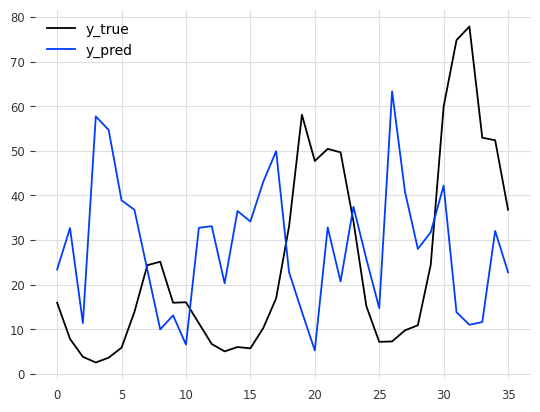

[I 2023-11-08 02:27:12,408] Trial 0 finished with value: 25.446041075384368 and parameters: {'max_iter': 51, 'alpha': 0.00034233977272356335}. Best is trial 0 with value: 25.446041075384368.
[I 2023-11-08 02:27:12,415] A new study created in memory with name: PoissonRegressor


mean_squared_error: 946.9275
rmse: 30.772187152427357
mape: 2.64558615269059
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
🐰Bụt Đây!!
PARAMS:  {'max_iter': 51, 'alpha': 0.00034233977272356335}
⭐️⭐️ City:  Bình Phước


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
160           0.634146        0.579585            0.592863        0.611111   
161           0.499630        0.597712            0.488901        0.638889   
162           0.501848        0.540326            0.480472        0.500000   
163           0.633407        0.556999            0.522619        0.472222   
164           0.515151        0.447169            0.441135        0.583333   
165           0.690318        0.337437            0.407418        0.305556   
166           0.822616        0.380671            0.393369        0.166667   
167           0.861050        0.493796            0.480472        0.333333   
168           0.556541        0.523265            0.550717        0.500000   
169           0.571323        0.616324            0.525428        0.500000   
170           0.504804        0.541683            0.522619        0.500000   
171           0.246120        0.536836            0.472043        0.500000   
172           0.586105        0.639589            0.511380        0.500000   
173           0.541759        0.686119            0.570385        0.500000   
174           0.652624        0.282862            0.384940        0.500000   
175           0.497413        0.500969            0.500140        0.500000   
176           0.623060        0.448624            0.429896        0.500000   
177           0.770880        0.424389            0.553526        0.500000   
178           0.830007        0.365258            0.460804        0.500000   
179           0.586105        0.453470            0.345603        0.500000   
180           0.593496        0.500969            0.477662        0.500000   
181           0.889135        0.516479            0.533858        0.500000   
182           0.172210        0.804381            0.958134        0.500000   
183           0.305248        0.315820            0.016859        0.500000   
184           0.696970        0.642497            0.581624        0.500000   
185           0.571323        0.838309            0.671537        0.500000   
186           0.674797        0.110314            0.278168        0.500000   
187           0.179601        0.763668            0.581624        0.500000   
188           0.756098        0.204343            0.337173        0.500000   
189           0.800443        0.474796            0.466423        0.500000   
190           1.000000        0.327452            0.438325        0.500000   
191           0.807834        0.482551            0.432706        0.500000   
192           0.778270        0.501939            0.488901        0.500000   
193           0.689579        0.523265            0.514189        0.500000   
194           0.157428        0.624079            0.545097        0.500000   
195           0.002217        0.646375            0.553526        0.500000   
196           0.719143        0.475766            0.491711        0.500000   
197           0.630451        0.661884            0.508570        0.500000   
198           0.549150        0.465103            0.553526        0.500000   
199           0.475240        0.380768            0.331554        0.500000   
200           0.778270        0.670609            0.764260        0.500000   
201           0.652624        0.138426            0.140489        0.500000   
202           0.793053        0.501939            0.438325        0.500000   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
160             0.282051                 0.196721                 0.243243   
161             0.397436                 0.377049                 0.337838   
162             0.461539                 0.377049                 0.378378   
163             0.564103                 0.704918                 0.418919   
164             0.397436                 0.245902                 0.364865   
165             0.500000                 0.639344                 0.283784   
166             0.461539  

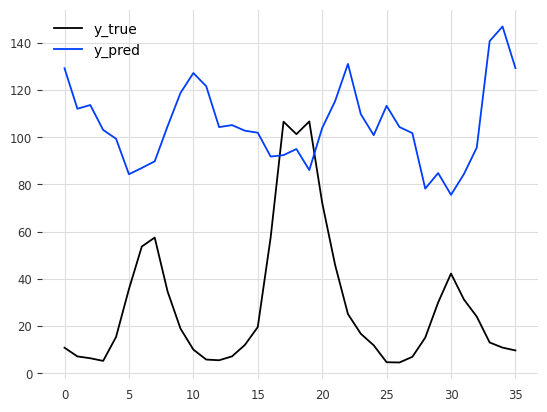

[I 2023-11-08 02:27:12,531] Trial 0 finished with value: 78.537621005267 and parameters: {'max_iter': 178, 'alpha': 0.697575253235698}. Best is trial 0 with value: 78.537621005267.
[I 2023-11-08 02:27:12,538] A new study created in memory with name: RandomForest


mean_squared_error: 7378.9636
rmse: 85.90089379271328
mape: 7.6919728172638075
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
🐰Bụt Đây!!
PARAMS:  {'max_iter': 178, 'alpha': 0.697575253235698}
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep:  6
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  RandomForest
⭐️⭐️ City:  An Giang


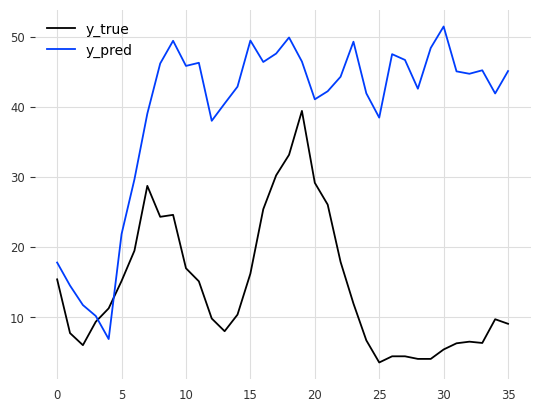

[I 2023-11-08 02:27:12,919] Trial 0 finished with value: 25.120507603839 and parameters: {'random_state': 27, 'n_estimators': 178, 'max_depth': 8}. Best is trial 0 with value: 25.120507603839.
[I 2023-11-08 02:27:12,925] A new study created in memory with name: RandomForest


mean_squared_error: 817.1446
rmse: 28.5857410090871
mape: 3.2933082422639055
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


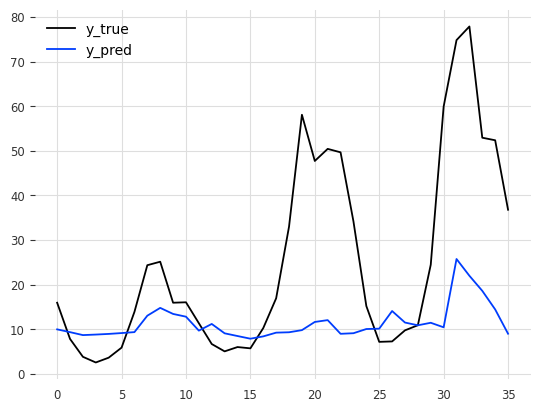

[I 2023-11-08 02:27:13,231] Trial 0 finished with value: 16.11200419834917 and parameters: {'random_state': 32, 'n_estimators': 117, 'max_depth': 8}. Best is trial 0 with value: 16.11200419834917.
[I 2023-11-08 02:27:13,237] A new study created in memory with name: RandomForest


mean_squared_error: 558.4856
rmse: 23.6322999312268
mape: 0.6194712731504171
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


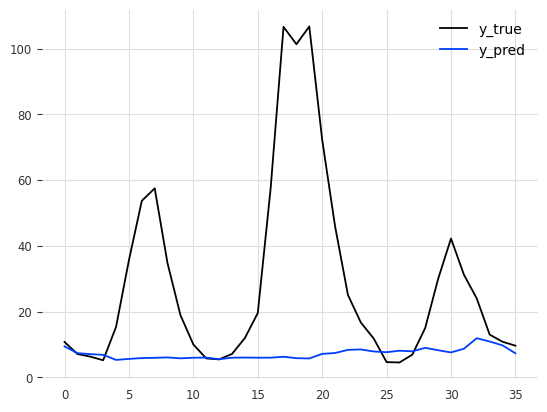

[I 2023-11-08 02:27:13,435] Trial 0 finished with value: 22.24589221991361 and parameters: {'random_state': 10, 'n_estimators': 62, 'max_depth': 4}. Best is trial 0 with value: 22.24589221991361.
[I 2023-11-08 02:27:13,442] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 1324.2073
rmse: 36.389659908754744
mape: 0.5384447496880299
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  LinearRegressionModel
⭐️⭐️ City:  An Giang


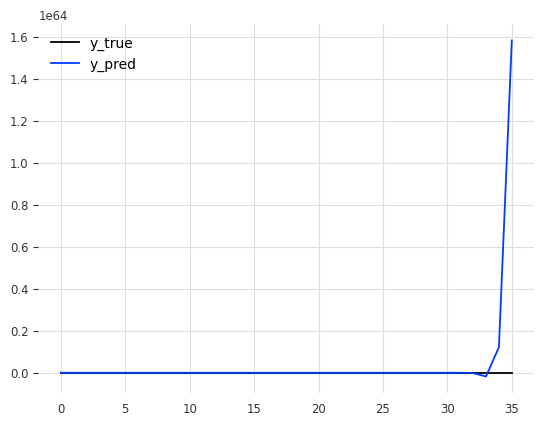

[I 2023-11-08 02:27:13,574] Trial 0 finished with value: 4.7847265513255145e+62 and parameters: {'random_state': 18}. Best is trial 0 with value: 4.7847265513255145e+62.
[I 2023-11-08 02:27:13,581] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 6988628113419514799766639043655919586968800451701760328834029612043039280288109540021774807520693851917456848712075516307308544.0000
rmse: 2.6436013529689978e+63
mape: 5.284180274851206e+61
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


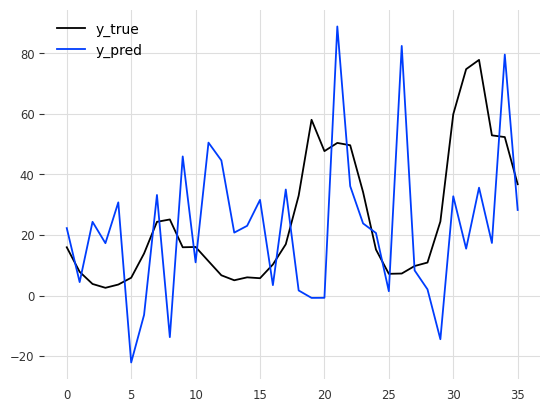

[I 2023-11-08 02:27:13,688] Trial 0 finished with value: 25.026655085308217 and parameters: {'random_state': 41}. Best is trial 0 with value: 25.026655085308217.
[I 2023-11-08 02:27:13,695] A new study created in memory with name: LinearRegressionModel


mean_squared_error: 936.6117
rmse: 30.604113019197545
mape: 2.02361534094001
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


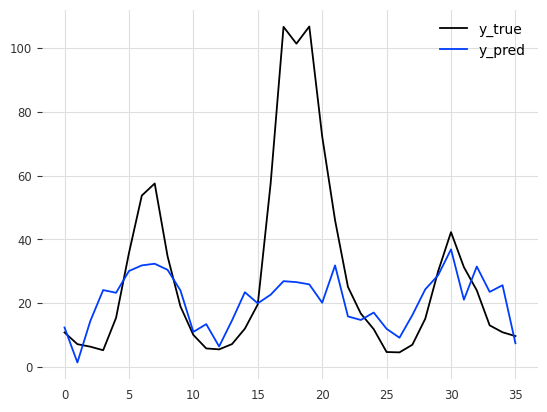

[I 2023-11-08 02:27:13,794] Trial 0 finished with value: 15.771817866340557 and parameters: {'random_state': 23}. Best is trial 0 with value: 15.771817866340557.
[I 2023-11-08 02:27:13,811] A new study created in memory with name: CatBoostModel


mean_squared_error: 707.0564
rmse: 26.590531814876993
mape: 0.6614764173896739
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  CatBoostModel
⭐️⭐️ City:  An Giang


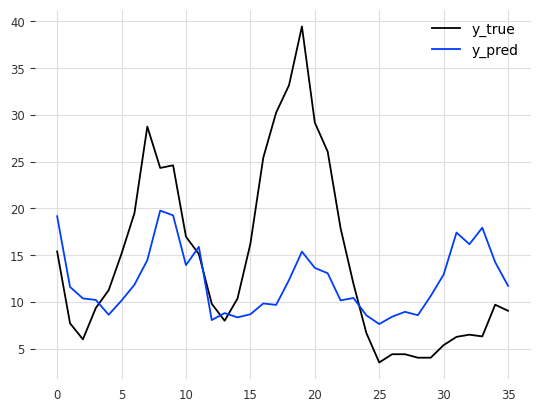

[I 2023-11-08 02:27:14,412] Trial 0 finished with value: 7.225018397412473 and parameters: {'learning_rate': 0.04315792836146659, 'n_estimators': 125, 'max_depth': 4, 'random_state': 932, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 63.783994998587694, 'border_count': 213, 'l2_leaf_reg': 8.780075544567655, 'random_strength': 3.8046071486886217}. Best is trial 0 with value: 7.225018397412473.
[I 2023-11-08 02:27:14,418] A new study created in memory with name: CatBoostModel


mean_squared_error: 88.3390
rmse: 9.398883405361355
mape: 0.6148080235784347
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


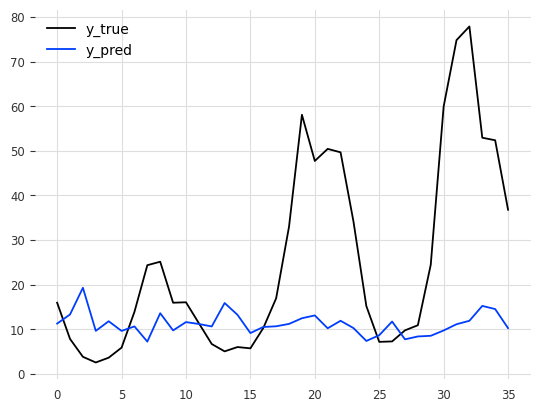

[I 2023-11-08 02:27:23,487] Trial 0 finished with value: 17.765683463558815 and parameters: {'learning_rate': 0.014600758926343185, 'n_estimators': 153, 'max_depth': 14, 'random_state': 293, 'likelihood': 'quantile', 'quantiles': [0.1, 0.5, 0.9], 'bagging_temperature': 34.04611388994619, 'border_count': 65, 'l2_leaf_reg': 0.26739848298346847, 'random_strength': 8.397490490268087}. Best is trial 0 with value: 17.765683463558815.
[I 2023-11-08 02:27:23,500] A new study created in memory with name: CatBoostModel


mean_squared_error: 649.0884
rmse: 25.47721262590212
mape: 0.8140507367883089
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


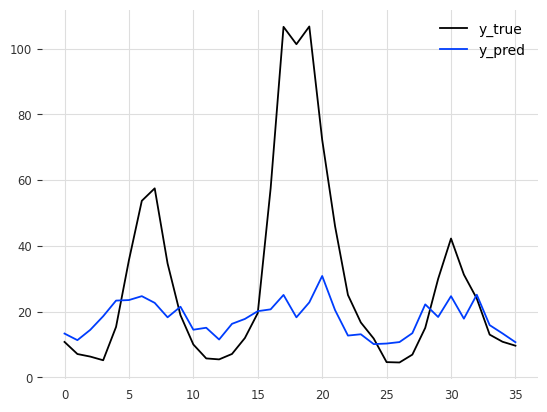

[I 2023-11-08 02:28:17,397] Trial 0 finished with value: 17.000942074755244 and parameters: {'learning_rate': 0.09970628928812411, 'n_estimators': 196, 'max_depth': 14, 'random_state': 13, 'likelihood': 'quantile', 'quantiles': None, 'bagging_temperature': 93.44828899094422, 'border_count': 208, 'l2_leaf_reg': 6.537658756509124, 'random_strength': 8.5900269211854}. Best is trial 0 with value: 17.000942074755244.
[I 2023-11-08 02:28:17,414] A new study created in memory with name: XGBModel


mean_squared_error: 787.2345
rmse: 28.057698654688107
mape: 0.6398698907936464
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  XGBModel
⭐️⭐️ City:  An Giang


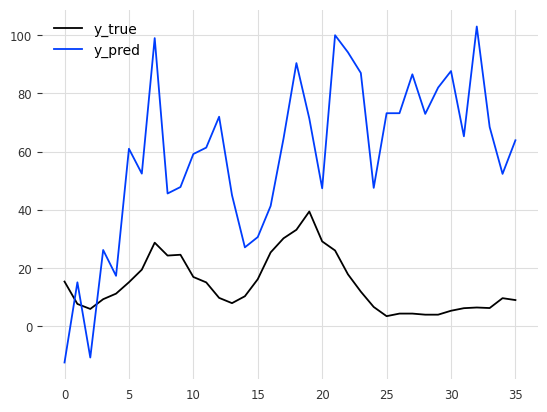

[I 2023-11-08 02:28:18,143] Trial 0 finished with value: 46.56837468532067 and parameters: {'random_state': 42, 'likelihood': 'quantile'}. Best is trial 0 with value: 46.56837468532067.
[I 2023-11-08 02:28:18,148] A new study created in memory with name: XGBModel


mean_squared_error: 2785.8524
rmse: 52.781174638020005
mape: 5.846628918477186
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


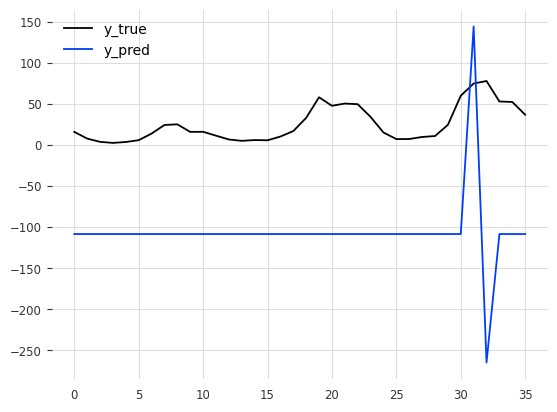

[I 2023-11-08 02:28:18,781] Trial 0 finished with value: 134.58519907254487 and parameters: {'random_state': 14, 'likelihood': 'quantile'}. Best is trial 0 with value: 134.58519907254487.
[I 2023-11-08 02:28:18,787] A new study created in memory with name: XGBModel


mean_squared_error: 19759.2184
rmse: 140.56748701132162
mape: 11.040634404459032
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


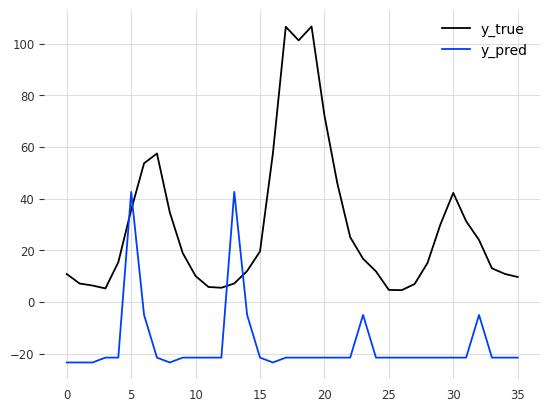

[I 2023-11-08 02:28:19,538] Trial 0 finished with value: 47.72838990918919 and parameters: {'random_state': 13, 'likelihood': 'quantile'}. Best is trial 0 with value: 47.72838990918919.
[I 2023-11-08 02:28:19,545] A new study created in memory with name: SVMRBF


mean_squared_error: 3177.4324
rmse: 56.36871810837871
mape: 2.6133492999938635
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  SVMRBF
⭐️⭐️ City:  An Giang


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
159           0.051149        0.516008            0.623693        0.707317   
160           0.574713        0.515872            0.388502        0.853658   
161           0.383333        0.567166            0.445122        0.707317   
162           0.535057        0.425817            0.462544        0.463415   
163           0.381609        0.445504            0.405923        0.585366   
164           0.405172        0.578474            0.671603        0.560976   
165           0.452299        0.338692            0.096690        0.439024   
166           0.562644        0.429837            0.636760        0.292683   
167           0.560345        0.363215            0.074913        0.390244   
168           0.258621        0.464578            0.423345        0.560976   
169           0.672414        0.482970            0.445122        0.560976   
170           0.402299        0.501362            0.675958        0.560976   
171           0.287356        0.557221            0.392857        0.560976   
172           0.419540        0.424387            0.371080        0.560976   
173           0.465517        0.451635            0.384146        0.560976   
174           0.362069        0.497956            0.462544        0.560976   
175           0.482759        0.423706            0.358014        0.560976   
176           0.379310        0.455041            0.384146        0.560976   
177           0.494253        0.515668            0.680314        0.560976   
178           0.597701        0.357629            0.140244        0.560976   
179           0.339081        0.447548            0.379791        0.560976   
180           1.000000        0.465259            0.436411        0.560976   
181           0.000000        0.480245            0.440767        0.560976   
182           0.436782        0.549046            0.593206        0.560976   
183           0.275862        0.487738            0.362369        0.560976   
184           0.660919        0.391689            0.349303        0.560976   
185           0.396552        0.551771            0.501742        0.560976   
186           0.614942        0.380109            0.375435        0.560976   
187           0.149425        0.509537            0.449477        0.560976   
188           0.454023        0.478202            0.471254        0.560976   
189           0.442529        0.447548            0.601916        0.560976   
190           0.563218        0.365123            0.061847        0.560976   
191           0.396552        0.465940            0.427700        0.560976   
192           0.465517        0.463215            0.418990        0.560976   
193           0.551724        0.463896            0.418990        0.560976   
194           0.431034        0.490463            0.479965        0.560976   
195           0.229885        0.535422            0.580139        0.560976   
196           0.511494        0.435286            0.344948        0.560976   
197           0.511494        0.465940            0.414634        0.560976   
198           0.494253        1.000000            0.401568        0.560976   
199           0.275862        0.000000            0.493031        0.560976   
200           0.465517        0.474796            0.475610        0.560976   
201           0.500000        0.354905            0.244774        0.560976   
202           0.574713        0.453678            0.523519        0.560976   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
159             0.645161                 0.194030                 0.684932   
160             0.290323                 0.268657                 0.383562   
161             0.403226                 0.179104                 0.383562   
162             0.629032                 0.358209                 0.561644   
163             0.596774                 0.358209                 0.589041   
164             0.451613  

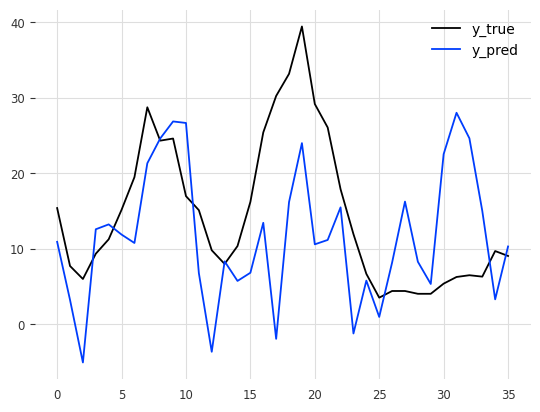

[I 2023-11-08 02:28:19,705] Trial 0 finished with value: 8.800169446910045 and parameters: {'max_iter': 132, 'epsilon': 0.02399188359245004}. Best is trial 0 with value: 8.800169446910045.
[I 2023-11-08 02:28:19,711] A new study created in memory with name: SVMRBF


mean_squared_error: 128.6168
rmse: 11.340935646789596
mape: 0.8362159274715186
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️⭐️ City:  BR Vũng Tàu


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
159           0.220451        0.527954            0.569514        0.605263   
160           0.885790        0.668229            0.707705        0.657895   
161           0.591634        0.369825            0.276382        0.394737   
162           0.600266        0.578842            0.636516        0.500000   
163           0.687915        0.319830            0.485762        0.157895   
164           0.509960        0.847562            0.615578        0.657895   
165           0.722444        0.000000            0.255444        0.000000   
166           0.775564        0.401406            0.410385        0.263158   
167           0.709827        0.463564            0.494137        0.315790   
168           0.739044        0.462895            0.489950        0.394737   
169           0.785525        0.466243            0.502513        0.394737   
170           0.526560        0.551055            0.820770        0.394737   
171           0.440239        0.590113            0.381072        0.394737   
172           0.553121        0.525388            0.448074        0.394737   
173           0.825365        0.476286            0.464824        0.394737   
174           0.685923        0.335677            0.481575        0.394737   
175           0.646082        0.567794            0.582077        0.394737   
176           0.626162        0.359112            0.393635        0.394737   
177           0.725764        0.496373            0.628141        0.394737   
178           0.606242        0.311126            0.305695        0.394737   
179           0.812085        0.424953            0.427136        0.394737   
180           0.599602        0.504185            0.640703        0.394737   
181           0.792165        0.458431            0.452261        0.394737   
182           0.480080        0.721794            0.477387        0.394737   
183           0.413679        0.250865            0.485762        0.394737   
184           0.938247        0.542127            0.540201        0.394737   
185           0.559761        0.524272            0.519263        0.394737   
186           0.792165        0.427185            0.485762        0.394737   
187           0.400398        0.498605            0.598827        0.394737   
188           0.838645        0.357996            0.427136        0.394737   
189           0.725764        0.366923            0.335008        0.394737   
190           0.758964        0.475170            0.561139        0.394737   
191           0.626162        0.448387            0.422948        0.394737   
192           0.785525        0.457315            0.481575        0.394737   
193           0.592962        0.462895            0.489950        0.394737   
194           0.612882        0.580069            0.690955        0.394737   
195           0.294157        0.458431            0.414573        0.394737   
196           0.832005        0.567794            0.502513        0.394737   
197           0.705843        0.506417            0.531826        0.394737   
198           0.699203        0.508649            0.519263        0.394737   
199           0.526560        0.409329            0.510888        0.394737   
200           0.739044        0.344604            0.414573        0.394737   
201           0.652722        0.459547            0.728643        0.394737   
202           0.832005        0.362459            0.201005        0.394737   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
159                0.775                 0.857143                 0.590909   
160                0.125                 0.380952                 0.068182   
161                0.175                 0.309524                 0.250000   
162                0.325                 0.523810                 0.363636   
163                0.625                 0.666667                 0.590909   
164                0.125  

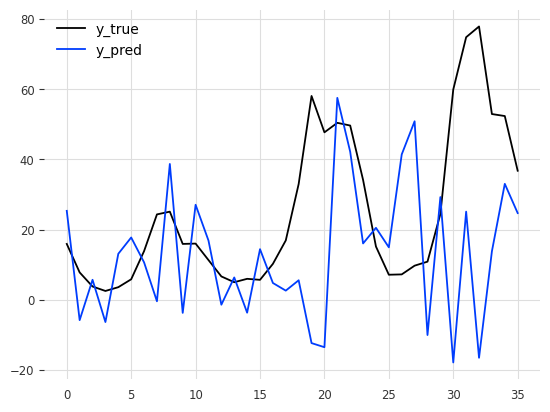

[I 2023-11-08 02:28:19,984] Trial 0 finished with value: 21.629808299189605 and parameters: {'max_iter': 130, 'epsilon': 1.758791565187852e-08}. Best is trial 0 with value: 21.629808299189605.
[I 2023-11-08 02:28:19,990] A new study created in memory with name: SVMRBF


mean_squared_error: 976.8104
rmse: 31.253966354846323
mape: 1.1775921981949118
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
⭐️⭐️ City:  Bình Phước


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
159           0.278640        0.478480            0.472043        0.611111   
160           0.634146        0.579585            0.592863        0.611111   
161           0.499630        0.597712            0.488901        0.638889   
162           0.501848        0.540326            0.480472        0.500000   
163           0.633407        0.556999            0.522619        0.472222   
164           0.515151        0.447169            0.441135        0.583333   
165           0.690318        0.337437            0.407418        0.305556   
166           0.822616        0.380671            0.393369        0.166667   
167           0.861050        0.493796            0.480472        0.333333   
168           0.556541        0.523265            0.550717        0.500000   
169           0.571323        0.616324            0.525428        0.500000   
170           0.504804        0.541683            0.522619        0.500000   
171           0.246120        0.536836            0.472043        0.500000   
172           0.586105        0.639589            0.511380        0.500000   
173           0.541759        0.686119            0.570385        0.500000   
174           0.652624        0.282862            0.384940        0.500000   
175           0.497413        0.500969            0.500140        0.500000   
176           0.623060        0.448624            0.429896        0.500000   
177           0.770880        0.424389            0.553526        0.500000   
178           0.830007        0.365258            0.460804        0.500000   
179           0.586105        0.453470            0.345603        0.500000   
180           0.593496        0.500969            0.477662        0.500000   
181           0.889135        0.516479            0.533858        0.500000   
182           0.172210        0.804381            0.958134        0.500000   
183           0.305248        0.315820            0.016859        0.500000   
184           0.696970        0.642497            0.581624        0.500000   
185           0.571323        0.838309            0.671537        0.500000   
186           0.674797        0.110314            0.278168        0.500000   
187           0.179601        0.763668            0.581624        0.500000   
188           0.756098        0.204343            0.337173        0.500000   
189           0.800443        0.474796            0.466423        0.500000   
190           1.000000        0.327452            0.438325        0.500000   
191           0.807834        0.482551            0.432706        0.500000   
192           0.778270        0.501939            0.488901        0.500000   
193           0.689579        0.523265            0.514189        0.500000   
194           0.157428        0.624079            0.545097        0.500000   
195           0.002217        0.646375            0.553526        0.500000   
196           0.719143        0.475766            0.491711        0.500000   
197           0.630451        0.661884            0.508570        0.500000   
198           0.549150        0.465103            0.553526        0.500000   
199           0.475240        0.380768            0.331554        0.500000   
200           0.778270        0.670609            0.764260        0.500000   
201           0.652624        0.138426            0.140489        0.500000   
202           0.793053        0.501939            0.438325        0.500000   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
159             0.602564                 0.524590                 0.621622   
160             0.282051                 0.196721                 0.243243   
161             0.397436                 0.377049                 0.337838   
162             0.461539                 0.377049                 0.378378   
163             0.564103                 0.704918                 0.418919   
164             0.397436  

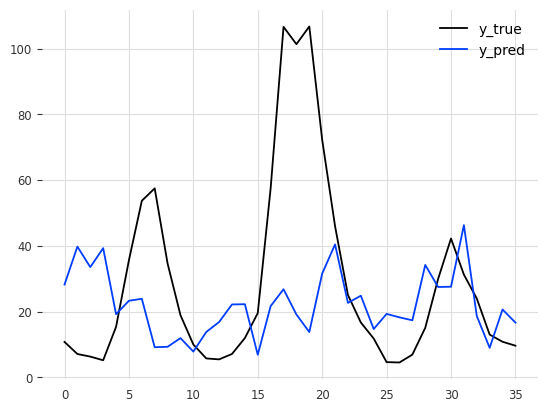

[I 2023-11-08 02:28:20,165] Trial 0 finished with value: 21.227781982457557 and parameters: {'max_iter': 196, 'epsilon': 0.061199517931186026}. Best is trial 0 with value: 21.227781982457557.
[I 2023-11-08 02:28:20,178] A new study created in memory with name: PoissonRegressor


mean_squared_error: 954.4421
rmse: 30.894046706175256
mape: 1.2193936976245545
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  PoissonRegressor
⭐️⭐️ City:  An Giang


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
159           0.051149        0.516008            0.623693        0.707317   
160           0.574713        0.515872            0.388502        0.853658   
161           0.383333        0.567166            0.445122        0.707317   
162           0.535057        0.425817            0.462544        0.463415   
163           0.381609        0.445504            0.405923        0.585366   
164           0.405172        0.578474            0.671603        0.560976   
165           0.452299        0.338692            0.096690        0.439024   
166           0.562644        0.429837            0.636760        0.292683   
167           0.560345        0.363215            0.074913        0.390244   
168           0.258621        0.464578            0.423345        0.560976   
169           0.672414        0.482970            0.445122        0.560976   
170           0.402299        0.501362            0.675958        0.560976   
171           0.287356        0.557221            0.392857        0.560976   
172           0.419540        0.424387            0.371080        0.560976   
173           0.465517        0.451635            0.384146        0.560976   
174           0.362069        0.497956            0.462544        0.560976   
175           0.482759        0.423706            0.358014        0.560976   
176           0.379310        0.455041            0.384146        0.560976   
177           0.494253        0.515668            0.680314        0.560976   
178           0.597701        0.357629            0.140244        0.560976   
179           0.339081        0.447548            0.379791        0.560976   
180           1.000000        0.465259            0.436411        0.560976   
181           0.000000        0.480245            0.440767        0.560976   
182           0.436782        0.549046            0.593206        0.560976   
183           0.275862        0.487738            0.362369        0.560976   
184           0.660919        0.391689            0.349303        0.560976   
185           0.396552        0.551771            0.501742        0.560976   
186           0.614942        0.380109            0.375435        0.560976   
187           0.149425        0.509537            0.449477        0.560976   
188           0.454023        0.478202            0.471254        0.560976   
189           0.442529        0.447548            0.601916        0.560976   
190           0.563218        0.365123            0.061847        0.560976   
191           0.396552        0.465940            0.427700        0.560976   
192           0.465517        0.463215            0.418990        0.560976   
193           0.551724        0.463896            0.418990        0.560976   
194           0.431034        0.490463            0.479965        0.560976   
195           0.229885        0.535422            0.580139        0.560976   
196           0.511494        0.435286            0.344948        0.560976   
197           0.511494        0.465940            0.414634        0.560976   
198           0.494253        1.000000            0.401568        0.560976   
199           0.275862        0.000000            0.493031        0.560976   
200           0.465517        0.474796            0.475610        0.560976   
201           0.500000        0.354905            0.244774        0.560976   
202           0.574713        0.453678            0.523519        0.560976   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
159             0.645161                 0.194030                 0.684932   
160             0.290323                 0.268657                 0.383562   
161             0.403226                 0.179104                 0.383562   
162             0.629032                 0.358209                 0.561644   
163             0.596774                 0.358209                 0.589041   
164             0.451613  

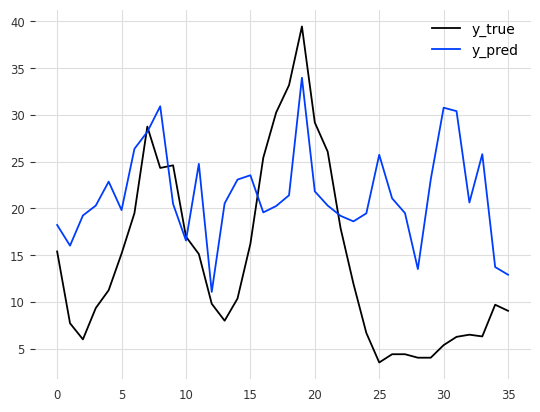

[I 2023-11-08 02:28:20,293] Trial 0 finished with value: 9.842096313363388 and parameters: {'max_iter': 147, 'alpha': 2.7871389588343554e-07}. Best is trial 0 with value: 9.842096313363388.
[I 2023-11-08 02:28:20,299] A new study created in memory with name: PoissonRegressor


mean_squared_error: 138.8022
rmse: 11.781434209138135
mape: 1.3923969118570954
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
🐰Bụt Đây!!
PARAMS:  {'max_iter': 147, 'alpha': 2.7871389588343554e-07}
⭐️⭐️ City:  BR Vũng Tàu


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
159           0.220451        0.527954            0.569514        0.605263   
160           0.885790        0.668229            0.707705        0.657895   
161           0.591634        0.369825            0.276382        0.394737   
162           0.600266        0.578842            0.636516        0.500000   
163           0.687915        0.319830            0.485762        0.157895   
164           0.509960        0.847562            0.615578        0.657895   
165           0.722444        0.000000            0.255444        0.000000   
166           0.775564        0.401406            0.410385        0.263158   
167           0.709827        0.463564            0.494137        0.315790   
168           0.739044        0.462895            0.489950        0.394737   
169           0.785525        0.466243            0.502513        0.394737   
170           0.526560        0.551055            0.820770        0.394737   
171           0.440239        0.590113            0.381072        0.394737   
172           0.553121        0.525388            0.448074        0.394737   
173           0.825365        0.476286            0.464824        0.394737   
174           0.685923        0.335677            0.481575        0.394737   
175           0.646082        0.567794            0.582077        0.394737   
176           0.626162        0.359112            0.393635        0.394737   
177           0.725764        0.496373            0.628141        0.394737   
178           0.606242        0.311126            0.305695        0.394737   
179           0.812085        0.424953            0.427136        0.394737   
180           0.599602        0.504185            0.640703        0.394737   
181           0.792165        0.458431            0.452261        0.394737   
182           0.480080        0.721794            0.477387        0.394737   
183           0.413679        0.250865            0.485762        0.394737   
184           0.938247        0.542127            0.540201        0.394737   
185           0.559761        0.524272            0.519263        0.394737   
186           0.792165        0.427185            0.485762        0.394737   
187           0.400398        0.498605            0.598827        0.394737   
188           0.838645        0.357996            0.427136        0.394737   
189           0.725764        0.366923            0.335008        0.394737   
190           0.758964        0.475170            0.561139        0.394737   
191           0.626162        0.448387            0.422948        0.394737   
192           0.785525        0.457315            0.481575        0.394737   
193           0.592962        0.462895            0.489950        0.394737   
194           0.612882        0.580069            0.690955        0.394737   
195           0.294157        0.458431            0.414573        0.394737   
196           0.832005        0.567794            0.502513        0.394737   
197           0.705843        0.506417            0.531826        0.394737   
198           0.699203        0.508649            0.519263        0.394737   
199           0.526560        0.409329            0.510888        0.394737   
200           0.739044        0.344604            0.414573        0.394737   
201           0.652722        0.459547            0.728643        0.394737   
202           0.832005        0.362459            0.201005        0.394737   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
159                0.775                 0.857143                 0.590909   
160                0.125                 0.380952                 0.068182   
161                0.175                 0.309524                 0.250000   
162                0.325                 0.523810                 0.363636   
163                0.625                 0.666667                 0.590909   
164                0.125  

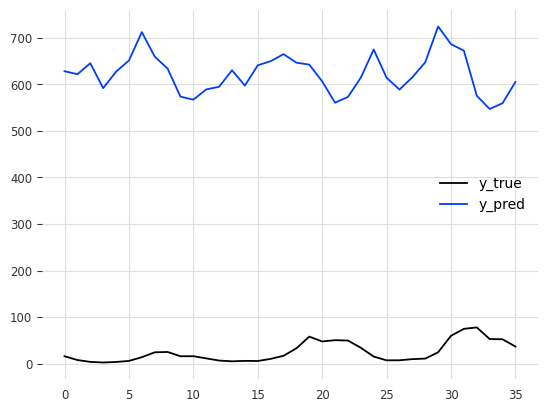

[I 2023-11-08 02:28:20,439] Trial 0 finished with value: 598.304779168172 and parameters: {'max_iter': 120, 'alpha': 1.1465142138296232}. Best is trial 0 with value: 598.304779168172.
[I 2023-11-08 02:28:20,451] A new study created in memory with name: PoissonRegressor


mean_squared_error: 360471.2543
rmse: 600.3925834444453
mape: 56.602456454984065
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
🐰Bụt Đây!!
PARAMS:  {'max_iter': 120, 'alpha': 1.1465142138296232}
⭐️⭐️ City:  Bình Phước


Total_Evaporation  Total_Rainfall  Max_Daily_Rainfall  n_raining_days  \
159           0.278640        0.478480            0.472043        0.611111   
160           0.634146        0.579585            0.592863        0.611111   
161           0.499630        0.597712            0.488901        0.638889   
162           0.501848        0.540326            0.480472        0.500000   
163           0.633407        0.556999            0.522619        0.472222   
164           0.515151        0.447169            0.441135        0.583333   
165           0.690318        0.337437            0.407418        0.305556   
166           0.822616        0.380671            0.393369        0.166667   
167           0.861050        0.493796            0.480472        0.333333   
168           0.556541        0.523265            0.550717        0.500000   
169           0.571323        0.616324            0.525428        0.500000   
170           0.504804        0.541683            0.522619        0.500000   
171           0.246120        0.536836            0.472043        0.500000   
172           0.586105        0.639589            0.511380        0.500000   
173           0.541759        0.686119            0.570385        0.500000   
174           0.652624        0.282862            0.384940        0.500000   
175           0.497413        0.500969            0.500140        0.500000   
176           0.623060        0.448624            0.429896        0.500000   
177           0.770880        0.424389            0.553526        0.500000   
178           0.830007        0.365258            0.460804        0.500000   
179           0.586105        0.453470            0.345603        0.500000   
180           0.593496        0.500969            0.477662        0.500000   
181           0.889135        0.516479            0.533858        0.500000   
182           0.172210        0.804381            0.958134        0.500000   
183           0.305248        0.315820            0.016859        0.500000   
184           0.696970        0.642497            0.581624        0.500000   
185           0.571323        0.838309            0.671537        0.500000   
186           0.674797        0.110314            0.278168        0.500000   
187           0.179601        0.763668            0.581624        0.500000   
188           0.756098        0.204343            0.337173        0.500000   
189           0.800443        0.474796            0.466423        0.500000   
190           1.000000        0.327452            0.438325        0.500000   
191           0.807834        0.482551            0.432706        0.500000   
192           0.778270        0.501939            0.488901        0.500000   
193           0.689579        0.523265            0.514189        0.500000   
194           0.157428        0.624079            0.545097        0.500000   
195           0.002217        0.646375            0.553526        0.500000   
196           0.719143        0.475766            0.491711        0.500000   
197           0.630451        0.661884            0.508570        0.500000   
198           0.549150        0.465103            0.553526        0.500000   
199           0.475240        0.380768            0.331554        0.500000   
200           0.778270        0.670609            0.764260        0.500000   
201           0.652624        0.138426            0.140489        0.500000   
202           0.793053        0.501939            0.438325        0.500000   

     Average_temperature  Max_Average_Temperature  Min_Average_Temperature  \
159             0.602564                 0.524590                 0.621622   
160             0.282051                 0.196721                 0.243243   
161             0.397436                 0.377049                 0.337838   
162             0.461539                 0.377049                 0.378378   
163             0.564103                 0.704918                 0.418919   
164             0.397436  

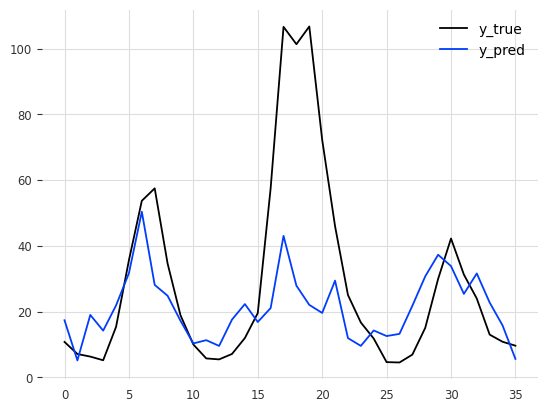

[I 2023-11-08 02:28:20,571] Trial 0 finished with value: 15.648702798498135 and parameters: {'max_iter': 193, 'alpha': 0.000366616924670788}. Best is trial 0 with value: 15.648702798498135.


mean_squared_error: 659.5931
rmse: 25.682544354698056
mape: 0.6835589812984368
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
🐰Bụt Đây!!
PARAMS:  {'max_iter': 193, 'alpha': 0.000366616924670788}


In [16]:
#########################
# Main cell for optimize ML algorithm
#########################
# Hai thuật toán này chưa chạy đc nhe, nên đừng truyền vô mảng để nó chạy nhoé!
# "PoissonRegressor"
# "SVMRBF"

model_name_list = [
     "RandomForest",
     "LinearRegressionModel",
    #  "LightGBMModel",
     "CatBoostModel",
     "XGBModel",
    "SVMRBF",
    "PoissonRegressor"
    
]


# Lưu thông tin traceback study và error city trong quá trình optimize
l_study_city ={}
l_errCity =[]

if __name__ == '__main__':
  for nstep in range(1,args.n_predicted_period_months+1):
    print("⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Nstep: ",nstep)
    lags_by_nstep = args.look_back + nstep - 1
    lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
    lags_past_covariates_in_str = f"{-lags_by_nstep+2},{-lags_by_nstep+1},{-lags_by_nstep}"
    for model_name in model_name_list: 
      print("⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name: ",model_name)
      best_param = pd.DataFrame()
      for city_index in range(len(cities)):
        print("⭐️⭐️ City: ",cities[city_index])
        # Use Tree-structured Parzen Estimator sampler to minimise RMSE
        sampler = optuna.samplers.TPESampler()
        study = optuna.create_study(sampler=sampler, direction='minimize', study_name = model_name)
        # truyền multiple param vào trong biến trial
        obj_func = lambda trial: objective(model_name, trial, cities[city_index], nstep = nstep)
        try:
          # Optimise over 100 trials
          study.optimize(obj_func, n_trials=args.ntry, n_jobs=args.njob)

          # Print results
          print("Study statistics for : ")
          print("  Number of finished trials: ", len(study.trials))
          print("Best trial of city: ",cities[city_index])

          best_trial = study.best_trial
          # lưu best param vào trong biến toàn cục

          if model_name == "LinearRegressionModel":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'LinearRegressionModel',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags' : lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'output_chunk_length': 1,
                                'random_state':best_trial.params['random_state'],
                                })
          elif model_name == 'XGBModel':
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'XGBModel',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags' : lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'output_chunk_length': 1,
                                'random_state':best_trial.params['random_state'],
                                'likelihood': best_trial.params['likelihood'],
                                })
          elif model_name == "LightGBMModel":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'LightGBMModel',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags': lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'multi_models': best_trial.params['multi_models'],
                                'num_leaves': best_trial.params['num_leaves'], 
                                'feature_fraction': best_trial.params['feature_fraction'], 
                                'min_child_samples': best_trial.params['min_child_samples'], 
                                'lambda_l1': best_trial.params['lambda_l1'], 
                                'lambda_l2': best_trial.params['lambda_l2'], 
                                'likelihood': best_trial.params['likelihood'], 
                                'learning_rate': best_trial.params['learning_rate']
                                })
          elif model_name == "CatBoostModel":
            quantitles = best_trial.params['quantiles']
            if quantitles == None:
              quantitles = "IsNone"
            else:
              quantitles = f"{quantitles[0]},{quantitles[1]},{quantitles[2]}"
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'CatBoost',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags' : lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'output_chunk_length': 1,
                                'learning_rate': best_trial.params['learning_rate'],
                                'n_estimators': best_trial.params['n_estimators'],
                                'max_depth': best_trial.params['max_depth'],
                                'random_state': best_trial.params['random_state'],
                                'likelihood': best_trial.params['likelihood'],
                                'quantiles': [quantitles],
                                'bagging_temperature': best_trial.params['bagging_temperature'],
                                'border_count': best_trial.params['border_count'],
                                'l2_leaf_reg': best_trial.params['l2_leaf_reg'],
                                'random_strength':best_trial.params['random_strength'],
                                })
          elif model_name == "RandomForest":
            one_city_param = pd.DataFrame({
                                'City':  cities[city_index],
                                'Alg_name': 'RandomForest',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'lags' : lags_by_nstep,
                                'lags_past_covariates': [lags_past_covariates_in_str],
                                'output_chunk_length': 1,
                                'n_estimators': best_trial.params['n_estimators'],
                                'max_depth': best_trial.params['max_depth'],
                                'random_state':best_trial.params['random_state'],
                                })
          elif model_name == "SVMRBF":
            one_city_param = pd.DataFrame({
                                'City':  [cities[city_index]],
                                'Alg_name': 'SVMRBF',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'max_iter':best_trial.params['max_iter'],
                                'kernel': 'rbf',
                                'epsilon': best_trial.params['epsilon'],
                                })
          elif model_name == "PoissonRegressor":
            print("🐰Bụt Đây!!")
            print("PARAMS: ",best_trial.params)
            one_city_param = pd.DataFrame({
                                'City':  [cities[city_index]],
                                'Alg_name': 'PoissonRegressor',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'max_iter':best_trial.params['max_iter'],
                                'fit_intercept': "False",
                                'alpha' : best_trial.params['alpha'],
                                })
          # file_path = 'opt_results/opt_res_ml_26102023/261023_DF_opt_hyperparam_'+ model_name + '_'+str(nstep)+'-nstep.xlsx'
          folder_path = f'opt_results/opt_res_ml_26102023/{model_name}/'
          file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_{nstep}-nstep.xlsx'
          if(os.path.isfile(file_path)):
              with pd.ExcelWriter(file_path,mode="a",engine="openpyxl",if_sheet_exists="overlay") as writer:
                  one_city_param.to_excel(writer, header=None, startrow=city_index+1,index=False)
          else:
              if(not (os.path.isdir(folder_path))):
                os.mkdir(folder_path)
              with pd.ExcelWriter(file_path,engine="openpyxl") as writer:
                  one_city_param.to_excel(writer, startrow=city_index,index=False)
        except:# có error thì lưu vào l_errCity để check lại sau 
          l_errCity.append(cities[city_index])
          #send_to_telegram(f'Tỉnh bị lỗi trong quá trình optimize bằng model {model_name}: {cities[city_index]}')

In [17]:
# send_to_telegram("Chạy xong optimize rùiii!!Vô check thuiii!!!" )